# ASHRAE Energy Prediction

## 1. Introduction 

## 2. EDA 1

## 3. Feature Engineering

## 4. EDA 2 

## 5. Modelling 

## 6. Results and Next Steps 

## 1. Introduction 

Predicting energy use by buildings can help customers understand how much they can expect to pay in the future and can help companies determine how much energy has been saved through retrofitting by comparing the energy consumption of the retrofitted buildings to the predicted energy consumption had they not been retrofitted. 

For this project, I used the [ASHRAE Great Energy Predictor III dataset](https://www.kaggle.com/c/ashrae-energy-prediction) to determine energy consumption in ~1500 buildings across fifteen. While there is no information to determine the location of these sites, we are provided with climate data for each location, which helps contextualize energy consumption. 

The evaluation metric specified for this project is RMSLE, which is relatively insensitive to outliers, in comparison to RMSE, but penalizes prediction results that underestimate the real value. The optimization of this specific metric will need to be taken into consideration through feature engineering and modelling. 

The last thing to note is that both the train and test datasets are very large, meaning that memory optimization will have to be a consistent consideration throughout this project. 

## 2. EDA 1

ASHRAE provides us with five data files: 

1. train.csv: contains the meter readings for every meter in each building over the year 2016. 
2. test.csv: contains the meters and the dates (2017/2018) over which predictions should be made for kaggle competition submission. 
3. building_metadata.csv: contains details (i.e. square footage, primary use) for every building for which we have data 
4. weather_test.csv/weather_train.csv: contains detailed weather data in each site for every day for which predictions need to be made. 

First, I'll load the relevant libraries, including functions I've built specifically for this project (the documentation for which can be found in energy_funct.py).  

The memory usage concerns start when we process and manupliate the datasets. Therefore, we do not need to to reduce file sizes while conducting a simple EDA. 

In [1]:
#import datasets 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime
import energy_funct as ef
warnings.filterwarnings('ignore')

filepath=os.getcwd()+'/'

In [2]:
#load files and start eda 

df=pd.read_csv(filepath+'train.csv')
df_test=pd.read_csv(filepath+'test.csv')
df_weather=pd.read_csv(filepath+'weather_train.csv')
df_weather_test=pd.read_csv(filepath+'weather_test.csv')
df_build=pd.read_csv(filepath+'building_metadata.csv') 

#we will start with exploring both the train and test data 
df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')

There are only four columns for the main train data, meaning the rest of the features we will use for prediction will need to be extracted from the additional files provided.

I will start by doing some summary statistics on each of these datasets 

building_id
Num nans:  0
% nan:  0.0
n unique:  1449
max:  1448
min:  0
mean:  799.2780003561518
median:  895.0
meter
Num nans:  0
% nan:  0.0
n unique:  4
max:  3
min:  0
mean:  0.662441173124391
median:  0.0
timestamp
Num nans:  0
% nan:  0.0
n unique:  8784
meter_reading
Num nans:  0
% nan:  0.0
n unique:  1688175
max:  21904700.0
min:  0.0
mean:  2117.1210762169394
median:  78.775


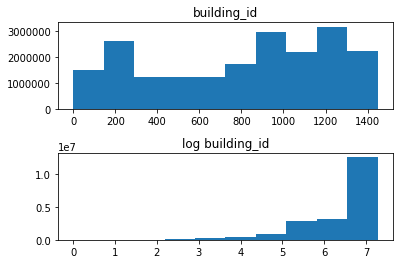

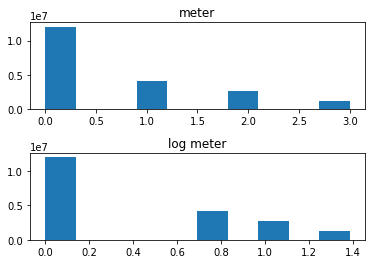

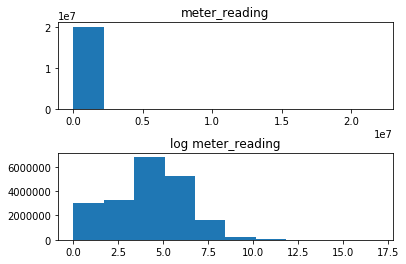

In [3]:
ef.sum_stats(df)

Some observations:

- there are no NaNs in this dataset
- 1449 unique buildings, numbered 0-1448
- '0' is the most common type of meter, though there may be multiple per building
- because a building may have multiple meters, it may therefore have multiple readings per timestamps
- the meter reading column appears to have a wide range of values and some extreme outliers. Currently, they are best read on a logarithmic scale. 

Let's explore these observations a bit more. 

As per the data description provided on Kaggle, the meter types are as follows: 0= electricity, 1= chilledwater, 2= steam, 3= hotwater. Meters 1-3 are all water-based. This may impact the way the readings are interpreted. 

Let's gather a bit more info on the timestamp variable 

In [4]:
type(df.timestamp[0])

str

These are string values. Let's convert them to datetime. I'm mostly interested in the date range, so I'll take a look at the minimum and maximum values. 

In [5]:
temp=pd.Series(df_weather['timestamp'].unique()).apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
print('min: ', min(temp))
print('max: ', max(temp))

min:  2016-01-01 00:00:00
max:  2016-12-31 23:00:00


The training dataset only spans a single year. This is important for several reasons. Firstly, it means that the 'year' will provide us with no insight. Secondly, it means that we have to be very careful with how we use the date data for training the model. If we want to train the model to predict meter readings outside of 2016, we should not include the day or day of year (and maybe even month) in the final training dataset as features. Otherwise, the model may overfit specifically to 2016. Something to note for later. 

Now, let's see how many different meter types each building has. 

(array([875.,   0.,   0., 230.,   0.,   0., 331.,   0.,   0.,  13.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

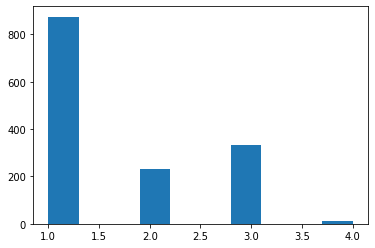

In [6]:
#grouping by building id and then counting the unique number of meter types
plt.hist(df.groupby('building_id')['meter'].nunique())

Most buildings seem to have only one type of meter.

Now, let's address the meter readings. 

Looking at the histogram as well as the discrepancy between the mean and median of the meter readings (from the sum_stats function), there are likely some outliers in the readings. Let's investigate. 

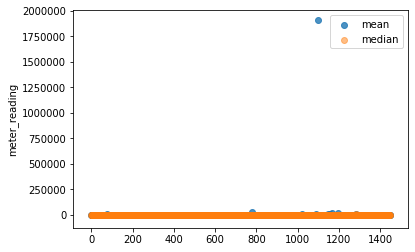

In [7]:
#first lets look at average (mean/median) meter reading for each building 
temp=df.groupby('building_id')['meter_reading'].agg(['mean','median'])

#lets take a look at the scatter plot
plt.scatter(list(range(len(temp))),temp['mean'], alpha=0.8)
plt.scatter(list(range(len(temp))),temp['median'], alpha=0.5)
plt.legend(['mean','median'])
plt.ylabel('meter_reading')
plt.show()

It looks as if a building may have some extreme meter reading outliers. Let's find out what building this. 

In [8]:
temp[temp['mean']==temp['mean'].max()].index.values

array([1099])

It looks as if building id 1099 contains the outlier. Let's take a look at building 1099 exclusively. 

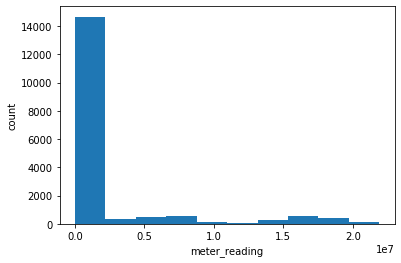

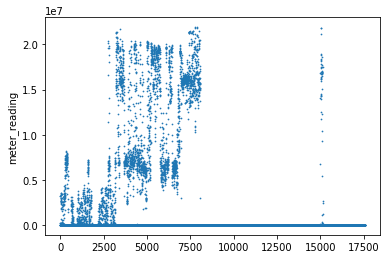

meter types [0 2]


In [9]:
temp=df[df.building_id==1099]
plt.hist(temp.meter_reading)
plt.ylabel('count')
plt.xlabel('meter_reading')
plt.show()

plt.scatter(list(range(len(temp))), temp.meter_reading,s=0.5)
plt.ylabel('meter_reading')
plt.show()

print('meter types', temp.meter.unique())

These readings look pretty strange. 

Looking at the unique meter types, this building has an electrical and water-based meter.

Let's plot by meter type to see if we can identify if the issue can be isolated to a specific meter. 

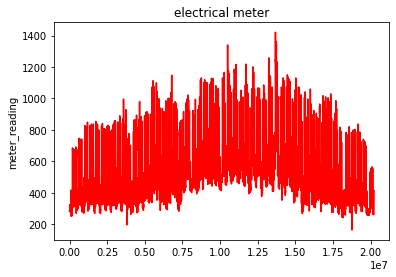

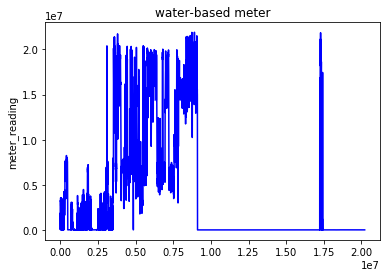

In [10]:
plt.plot(temp[temp.meter==0]['meter_reading'],c='r')
plt.title('electrical meter')
plt.ylabel('meter_reading')
plt.show()
plt.plot(temp[temp.meter==2]['meter_reading'],c='b')
plt.title('water-based meter')
plt.ylabel('meter_reading')
plt.show()

It seems as if it's the water-based meter (type 2) that has a potential issue. 

Just to make sure that this sort of reading is unusual, let's take a look at another building with this meter type to make sure this is not how all meter readings look.

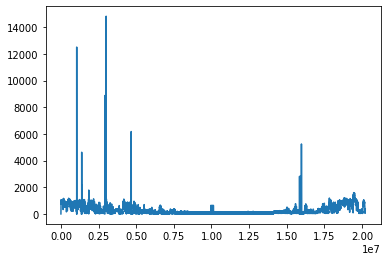

In [11]:
#I will at random choose the 100th's building with this meter type, just at random. 
temp=df[df.building_id==df[df.meter==2]['building_id'].unique()[100]]

plt.plot(temp[temp.meter==2]['meter_reading'])

While there do seem to be spikes in the data, it does not look like those in building 1099. Therefore, meter readings from meter 2 in building 1099 are likely dirty data. 

Moving on to my next observation. Looking at the meter_reading histograms from sum_stats, there seem to be a number of instances in which the meter reading is 0. I want to determine if these readings make sense or if they are an error. Let's take a look at the percentage of '0' meter readings for each type of meter and building id.

0 4.395762840449021


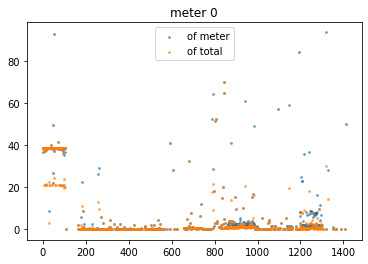

1 15.6966746683754


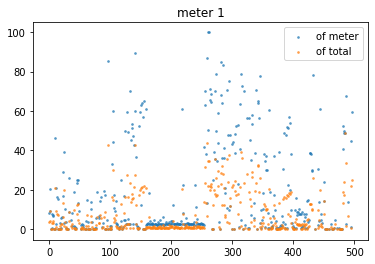

2 12.80903513956628


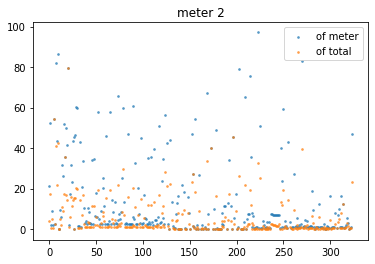

3 26.925082098071496


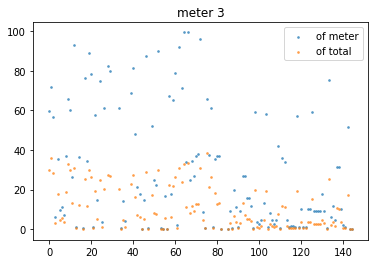

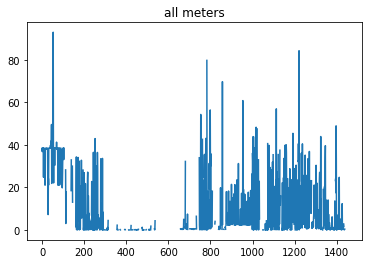

In [12]:
for x in sorted(df.meter.unique()):
    #conduct analysis for each type of meter 
    temp=df[df.meter==x]
    #count the percentage of meter readings that are 0 
    print(x, (len(temp[df.meter_reading==0])/len(temp)*100))
    #plot what % of meter values are 0 for this meter type 
    plt.scatter(list(range(temp.building_id.nunique())),
                (temp[temp.meter_reading==0].groupby('building_id')['building_id'].count()/temp.groupby('building_id')['building_id'].count())*100,
            alpha=0.6, s=3,label='of meter')
    #plot what % of meter values are 0 as a percentage of all readings 
    plt.scatter(list(range(temp.building_id.nunique())),
                (temp[temp.meter_reading==0].groupby('building_id')['building_id'].count()/df[df.building_id.isin(temp.building_id)].groupby('building_id').count()['meter'])*100, 
            alpha=0.6, s=3,label='of total')
    plt.legend()
    plt.title('meter '+str(x))
    plt.show()

plt.plot((df[df.meter_reading==0].groupby('building_id')['building_id'].count()/df.groupby('building_id')['building_id'].count())*100)
plt.title('all meters')
plt.show()

Water-based meters (1-3) appear to have substantially more 0-readings than electricity meters (0). However, there seem to be a large number of electricity meters (in building nos. ~0-200) that seem to have 0-readings.  

Based on [this thread](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054), water systems are expected to have 0 readings, while electricity meters do not. With this information we can conclude that it is likely irregular for the electricity meters in these buildings to have 0-readings. 

With this information, I am interested in two things. First, is I want to look at the meter readings of buildings in which more > 50% of all meter readings = 0, then I want to look at the electrical meter readings of those first ~150-200 buildings to determine why there are so many 0-readings. 

In [13]:
#first the buildings with >50%= 0 meter_readings 
temp=df[df.building_id.isin(df.groupby('building_id').count()
                            .index[(df[df.meter_reading==0].groupby('building_id')['building_id']
                                    .count()/df.groupby('building_id')['building_id'].count())*100>=50])]

print(len(temp))
print(temp.building_id.nunique())

123695
12


It appears that 12 buildings have >50% 0-readings. Let's take a look at the meter readings by meter type. 

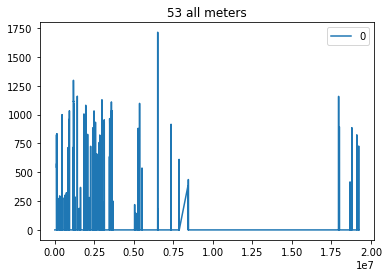

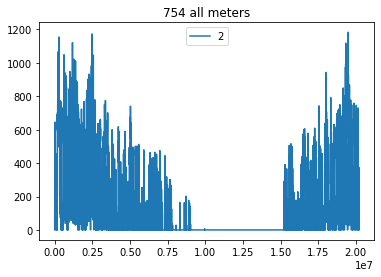

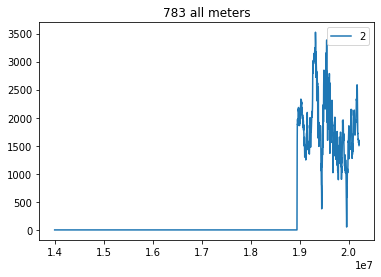

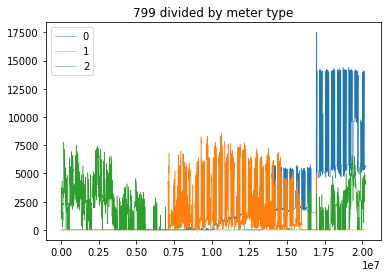

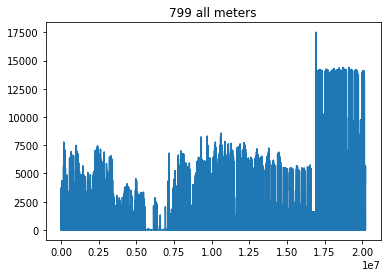

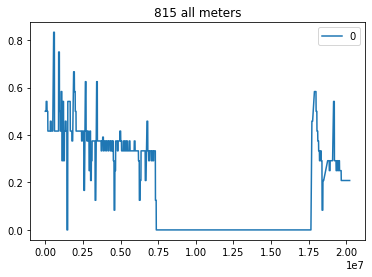

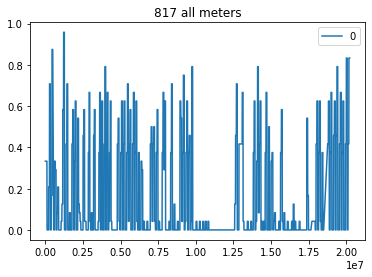

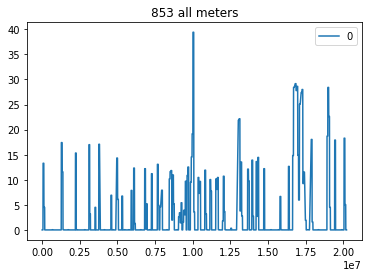

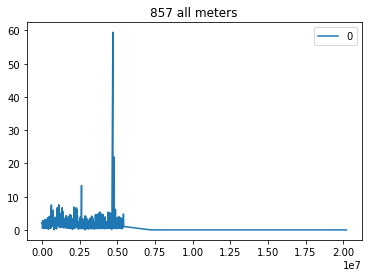

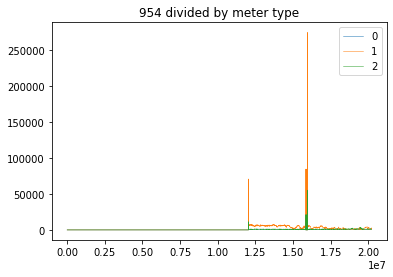

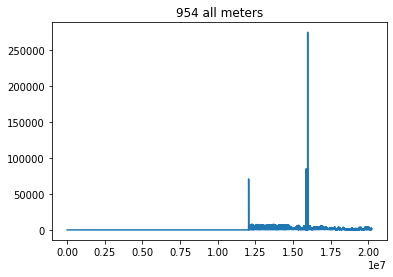

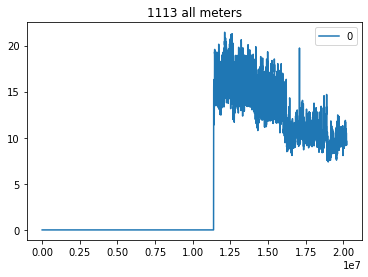

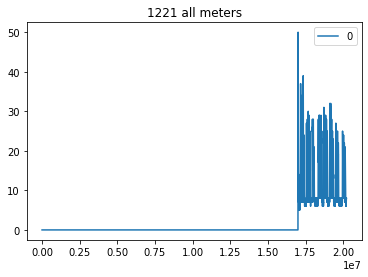

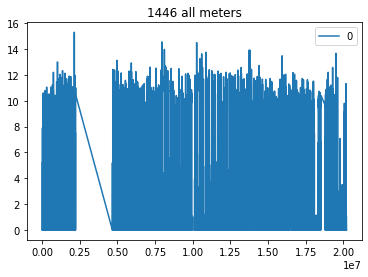

In [14]:
for x in sorted(temp.building_id.unique()):
    #plot each building indivudally 
    temp2=temp[temp.building_id==x]
    #if there is more than one type of meter, plot the readings for each meter
    if temp2.meter.nunique()>1:
        for y in sorted(temp2.meter.unique()):
            plt.plot(temp2[temp2.meter==y].meter_reading,label=str(y),lw=0.5)
        plt.legend()
        plt.title(str(x)+' divided by meter type')
        plt.show()
    #plot all meters together/for the meters that only have one type  
    plt.plot(temp2.meter_reading)
    #indicate which meter meter type it is, if there is only one type of meter
    if temp2.meter.nunique()==1:
        plt.legend(temp2.meter.unique())
    plt.title(str(x)+' all meters')
    plt.show()
    

It looks like in the majority of these buildings, a substantial number of 0-readings come from electric meters. It is likely that there are more buildings with these 0-readings that did not meet the >50% 0-reading threshold I set. In order to catch more of these instances, I would need to develop an algorithm that tracks the change in meter readings over time. I could assign a threshold value for ${\Delta}$meter_reading for which a flag would be raised, indicating that the data needs to be reviewed for potential error. 

In order to properly assess whether these are dirty data that need to be taken out, I would need to consult domain expert. 

Now let's take a look at the first ~150 buildings to determine why so many of the electrical readings are 0. 

Since we are only interested in the electrical meter readings, for which we know 0-readings should not be too common, we can subset from the electrical-reading data exclusively. 

In [15]:
#will start with the first 180 buildings and subset from there, if needed
#assigned threshold = 20% based on the above visualizations. 
temp=df[(df.building_id<180)&(df.meter==0)&(df.building_id.isin(df.groupby('building_id').count()
                            .index[(df[df.meter_reading==0].groupby('building_id')['building_id']
                                    .count()/df.groupby('building_id')['building_id'].count())*100>=20]))]

print(temp.building_id.nunique())

#i'll save these for later
zero_build=temp.building_id.unique()

112


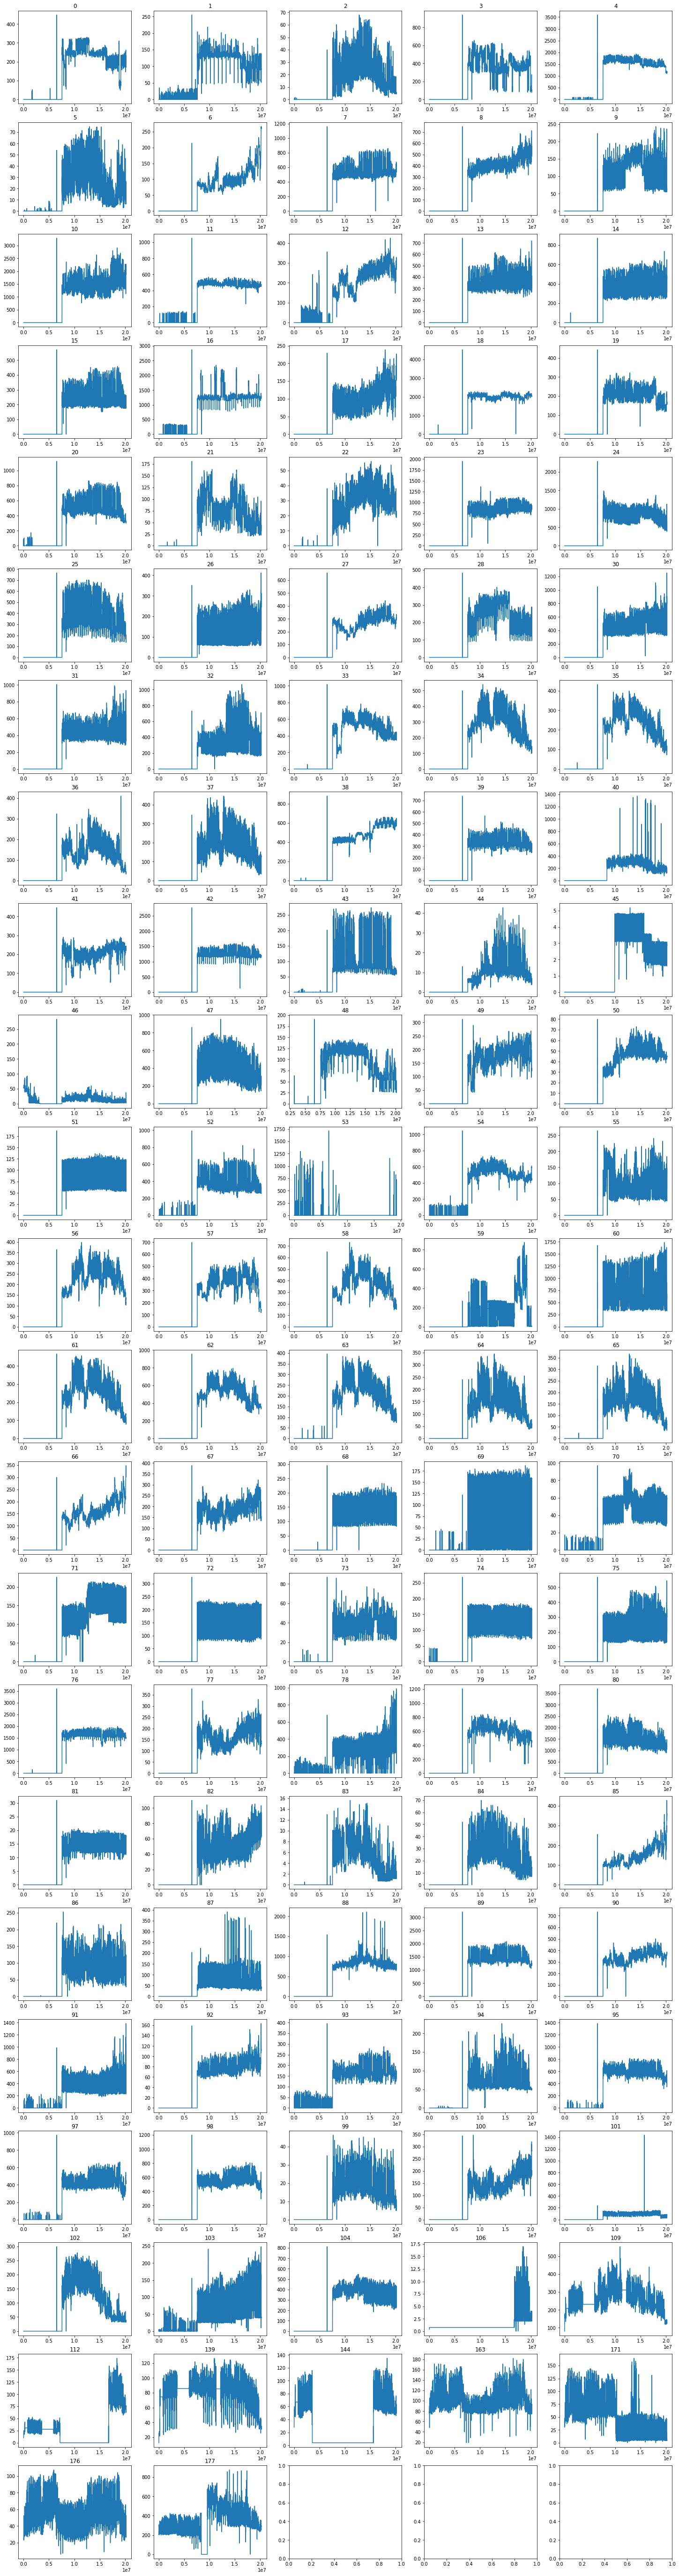

In [16]:
#we have 112 unique buildings in which more than 20% of the readings are 0. Let's visualize them individually.

fig, ax=plt.subplots(23,5, figsize=(25,100))
ax=ax.ravel()
for count, x in enumerate(sorted(temp.building_id.unique())): 
    ax[count].plot(temp[temp.building_id==x]['meter_reading'])
    ax[count].set_title(x)
    

The majority of these 0-readings appear to occur in the first part of the year. These data are likely the result of an error. This is good to note and will be taken into consideration at a later time. 

I now want to compare these training data to the test data to determine what sorts of differences they may have. 
Understanding how the training data relates to the test data may provide us with useful insights. 

row_id
Num nans:  0
% nan:  0.0
n unique:  41697600
max:  41697599
min:  0
mean:  20848799.5
median:  20848799.5
building_id
Num nans:  0
% nan:  0.0
n unique:  1449
max:  1448
min:  0
mean:  807.5823529411765
median:  900.0
meter
Num nans:  0
% nan:  0.0
n unique:  4
max:  3
min:  0
mean:  0.6642857142857143
median:  0.0
timestamp
Num nans:  0
% nan:  0.0
n unique:  17520


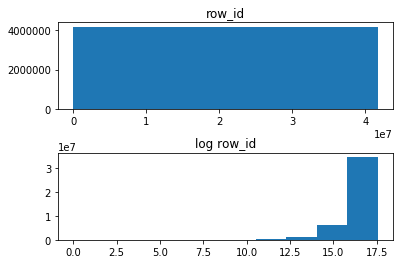

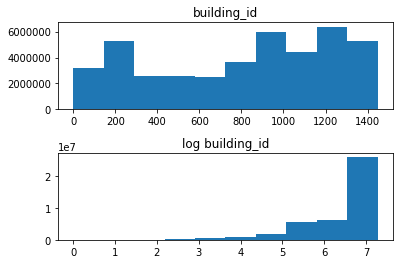

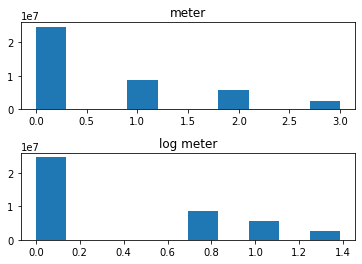

In [17]:
ef.sum_stats(df_test)

The test data contains the same building ids as the training data. This means we are creating predictions for the same buildings rather than approximating meter readings based on weather, use type, etc. This also means we can use building_id in our training data.

Let's check to see the timespan of the test dataset. 

In [18]:
temp=pd.Series(df_test['timestamp'].unique()).apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
print('min: ', min(temp))
print('max: ', max(temp))

min:  2017-01-01 00:00:00
max:  2018-12-31 23:00:00


The test data span 2017-2018. This means that it is extremely important that we do not overfit our model to 2016 conditions. We will not be able to use day of year, week of year, etc. as a feature. We will consider using 'month' as a feature, as it might be general enough to provide insight (i.e. special holidays, general climate conditions not caught by climate data, etc.).

Now that we have investigated the train/test datasets, let's look at the building data. 

site_id
Num nans:  0
% nan:  0.0
n unique:  16
max:  15
min:  0
mean:  6.9523809523809526
median:  5.0
building_id
Num nans:  0
% nan:  0.0
n unique:  1449
max:  1448
min:  0
mean:  724.0
median:  724.0
primary_use
Num nans:  0
% nan:  0.0
n unique:  16
cannot plot
val_counts:  Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64
square_feet
Num nans:  0
% nan:  0.0
n unique:  1397
max:  875000
min:  283
mean:  92111.77639751

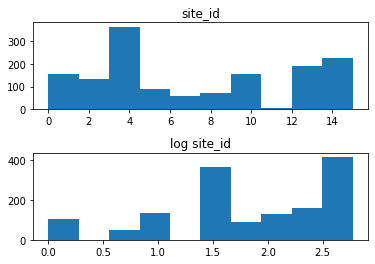

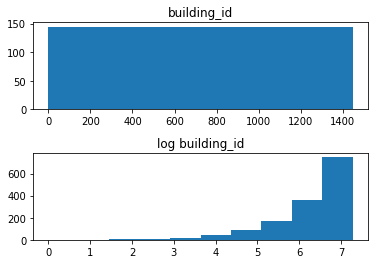

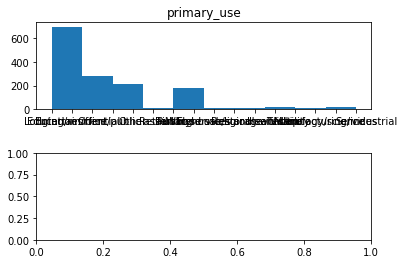

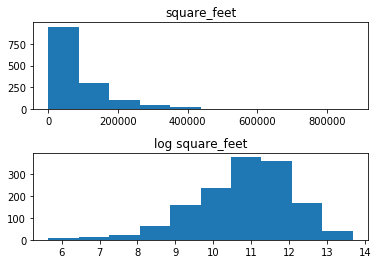

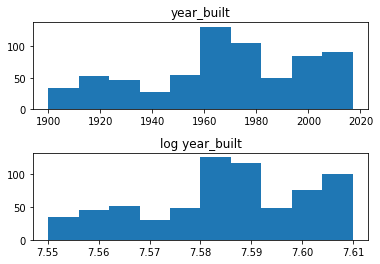

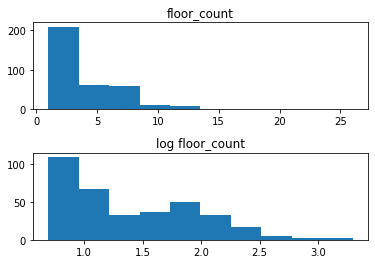

In [19]:
ef.sum_stats(df_build)

Some observations: 

- there are 16 unique sites. There are few buildings on site 11 and many buildings on site 4
- there are 16 primary use classifications for buildings, the majority of these appear to be 'office' and 'education'
- the square footage is generally small and can be more easily viewed with a logarithmic scale 
- the 'year_built' column is missing ~50% of the data, likely making the column unusable. 
- there also seem to be some non numerical values in year built, so we'll have to look at those if column gets used 
- the 'floor_count' column is missing ~70% of the data, likely making the column unusable. 

There's a lot we should address here. Let's start with site id. Let's look at the distribution of primary_use type and square_feet based on site id. 

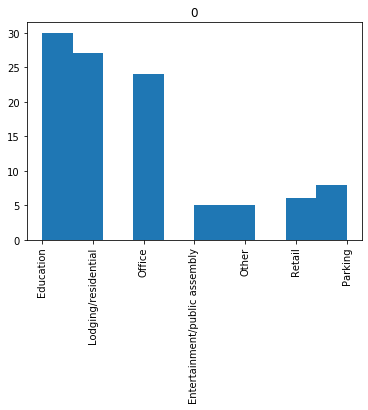

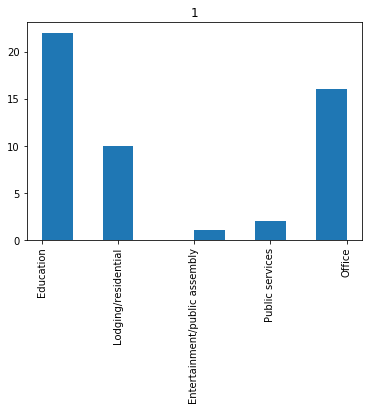

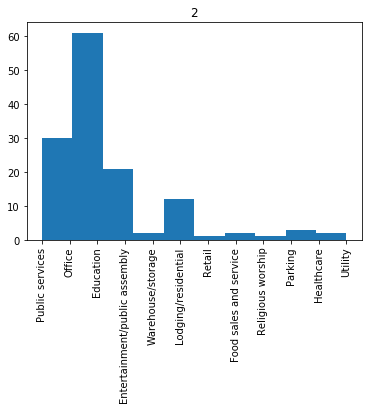

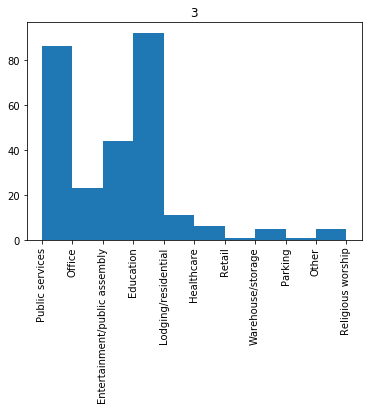

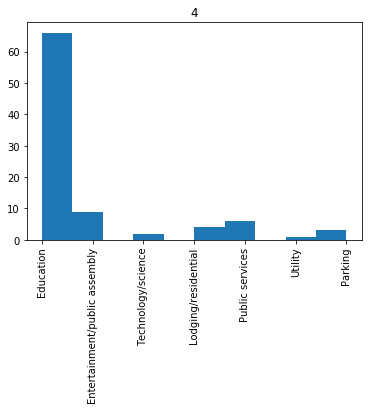

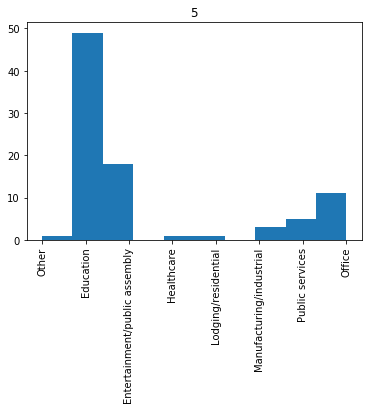

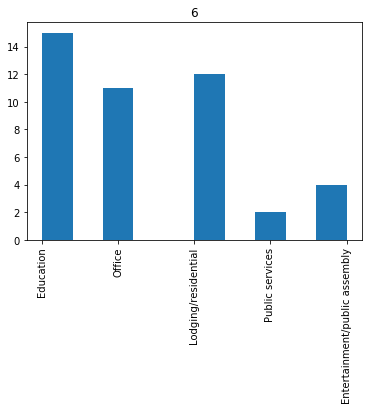

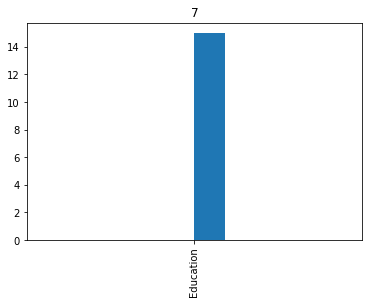

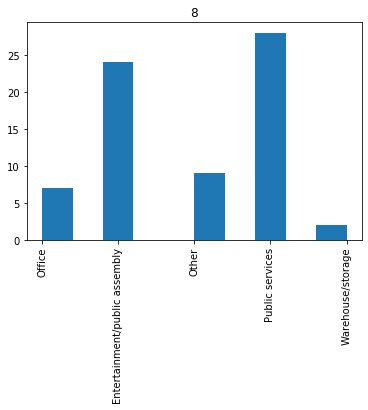

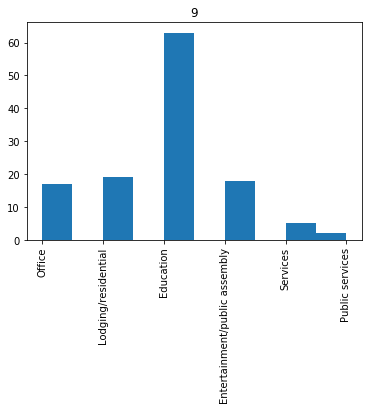

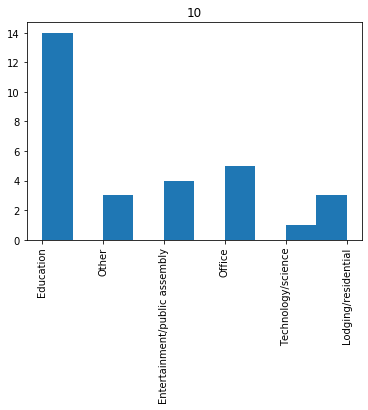

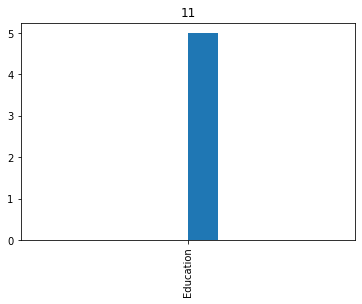

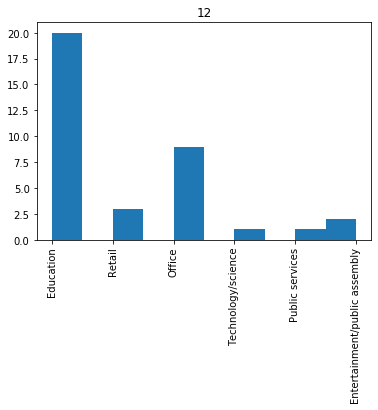

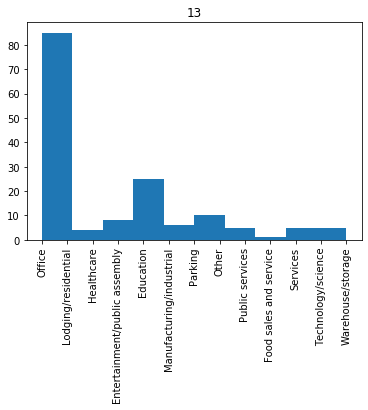

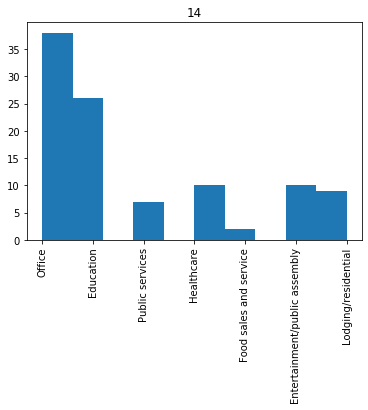

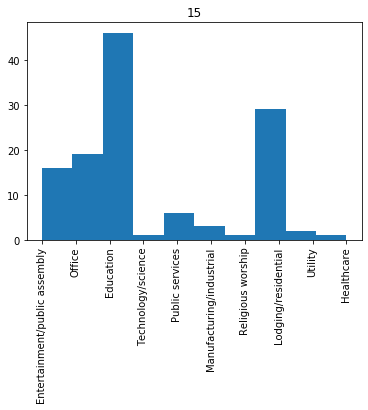

In [20]:
for x in df_build.site_id.unique():
    plt.hist(df_build[df_build.site_id==x]['primary_use'])
    plt.title(x)
    plt.xticks(rotation=90)
    plt.show()

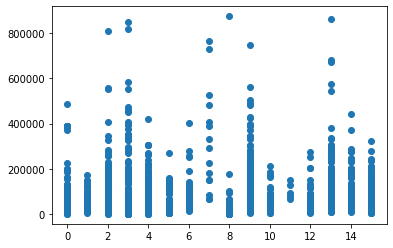

<function matplotlib.pyplot.show(*args, **kw)>

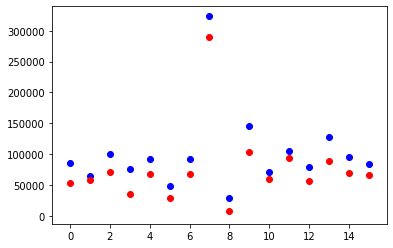

In [21]:
#7 and 11 are education only, will be interesting to see how this breaks down with climate and meter data
#now onto the square feet vs site id 

plt.scatter(df_build.site_id, df_build.square_feet)
plt.show() 

temp=df_build.groupby('site_id')['square_feet'].agg(['mean','median'])
plt.scatter(temp.index.values,temp['mean'].values,c='b')
plt.scatter(temp.index.values,temp['median'].values,c='r')
plt.show

Buildings in site 7 are on average larger, but this site contains fewer buildings, all of which are classified as 'education'. Comparison of the mean/median 'square_feet' indicate that no region has a substantial number of outliers to skew the mean values too much.

Now let's also look at how square_feet breaks down with 'primary_use'. 

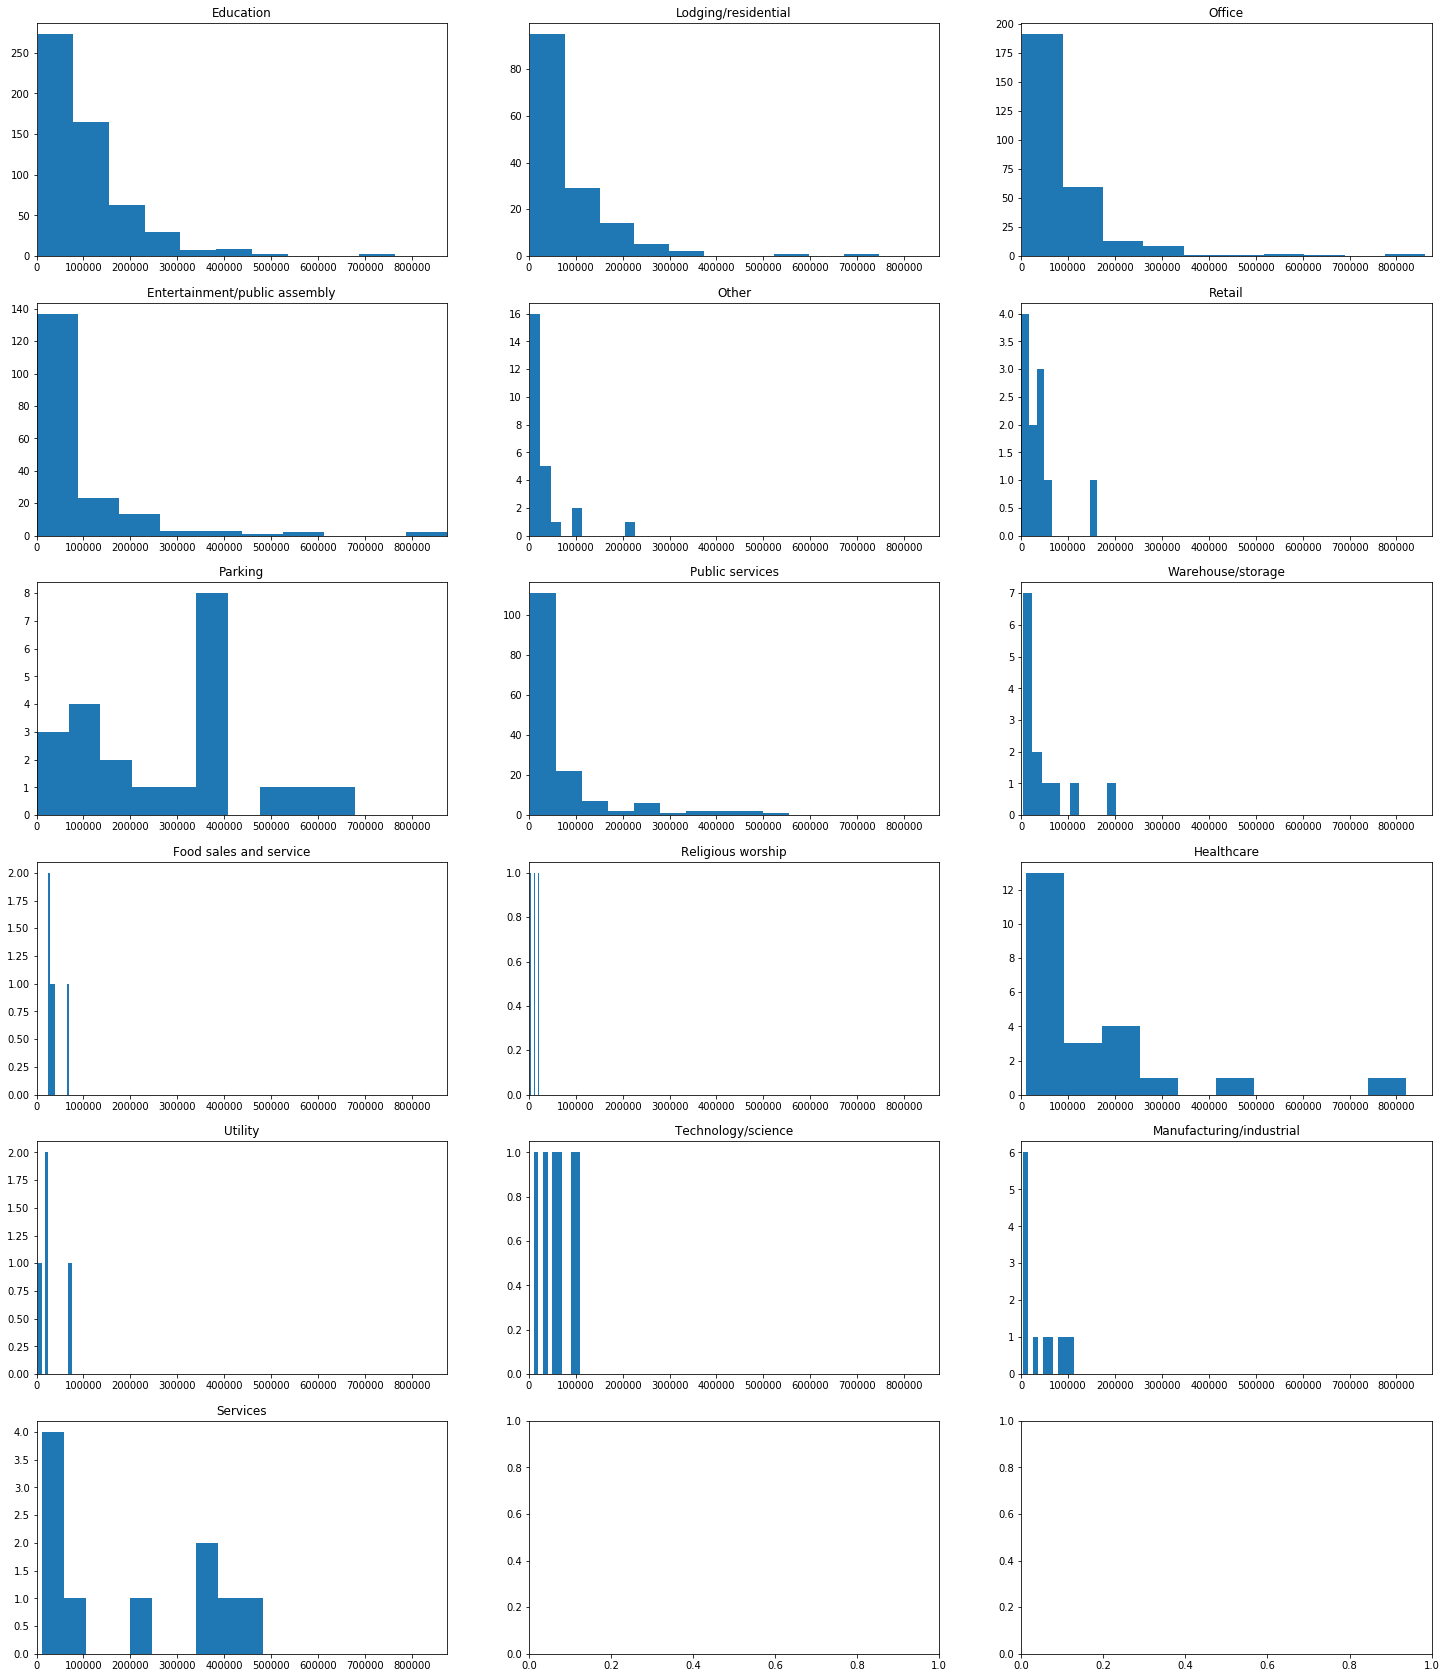

In [22]:
fig, ax=plt.subplots(6,3, figsize=(25,30))
ax=ax.ravel()
for count, x in enumerate(df_build.primary_use.unique()):
    ax[count].hist(df_build[df_build.primary_use==x]['square_feet'])
    ax[count].set_title(x)
    #constrain x axis so comparable between different plots
    ax[count].set_xlim([0,df_build.square_feet.max()])
plt.show()

It appears that the largest square footage belongs to buildings in 'healthcare',' 'services', and 'parking'.

Now that we have a good understanding of the information found in the buildings dataset, let's take a look at the weather data, starting with the training weather data. 

site_id
Num nans:  0
% nan:  0.0
n unique:  16
max:  15
min:  0
mean:  7.4789766263870705
median:  7.0
timestamp
Num nans:  0
% nan:  0.0
n unique:  8784
air_temperature
Num nans:  55
% nan:  0.03934951671639015
n unique:  619
cannot plot
max:  47.2
min:  -28.9
mean:  14.41810647160751
median:  15.0
cloud_coverage
Num nans:  69173
% nan:  49.48952945132465
n unique:  10
max:  9.0
min:  0.0
mean:  2.1493059490084985
median:  2.0
dew_temperature
Num nans:  113
% nan:  0.08084537070821976
n unique:  522
cannot plot
max:  26.1
min:  -35.0
mean:  7.350158241443597
median:  8.3
precip_depth_1_hr
Num nans:  50289
% nan:  35.97905174819171
n unique:  128
cannot plot
max:  343.0
min:  -1.0
mean:  0.9830472486701534
median:  0.0
sea_level_pressure
Num nans:  10618
% nan:  7.596603063538737
n unique:  709
max:  1045.5
min:  968.2
mean:  1016.1580380163505
median:  1016.4
wind_direction
Num nans:  6268
% nan:  4.484414014151517
n unique:  43
max:  360.0
min:  0.0
mean:  180.52663196134975
median: 

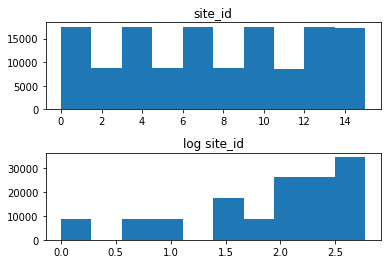

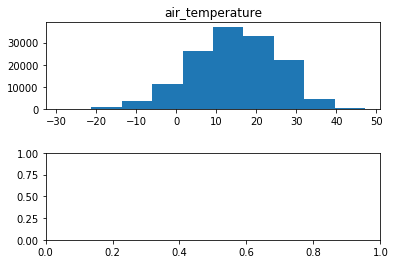

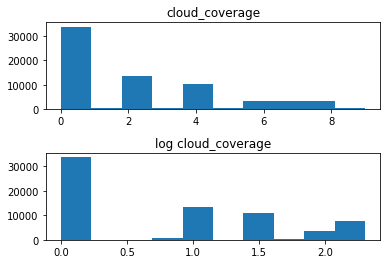

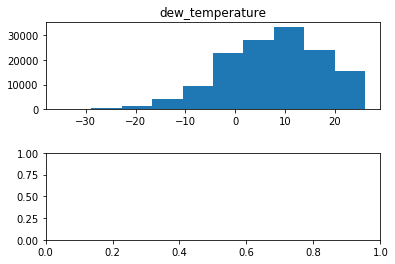

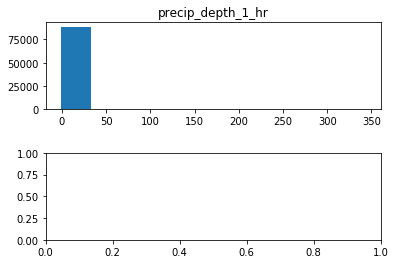

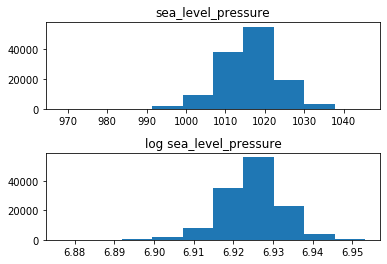

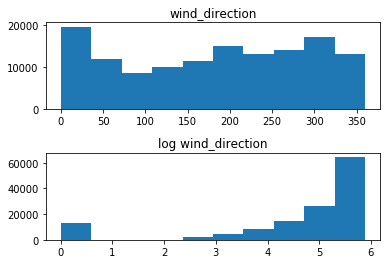

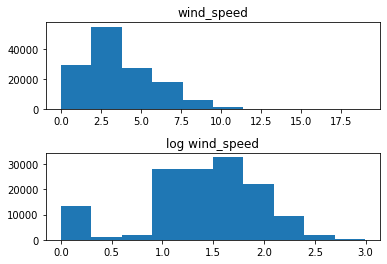

In [23]:
ef.sum_stats(df_weather)

Some observations: 
- the 'air_temperature' column has 55 nans; we will have to determine the location of the nans and fill them in.
- 'dew_temperature' and 'wind_speed columns' have some nans, but again, not many
- 'precipitation_depth_1_hr' and 'sea_level_pressure'have a substantial number of missing data. We will need to think carefully regarding what to do with them.

First, let's visualize the nan values in a little more detail, by region. 

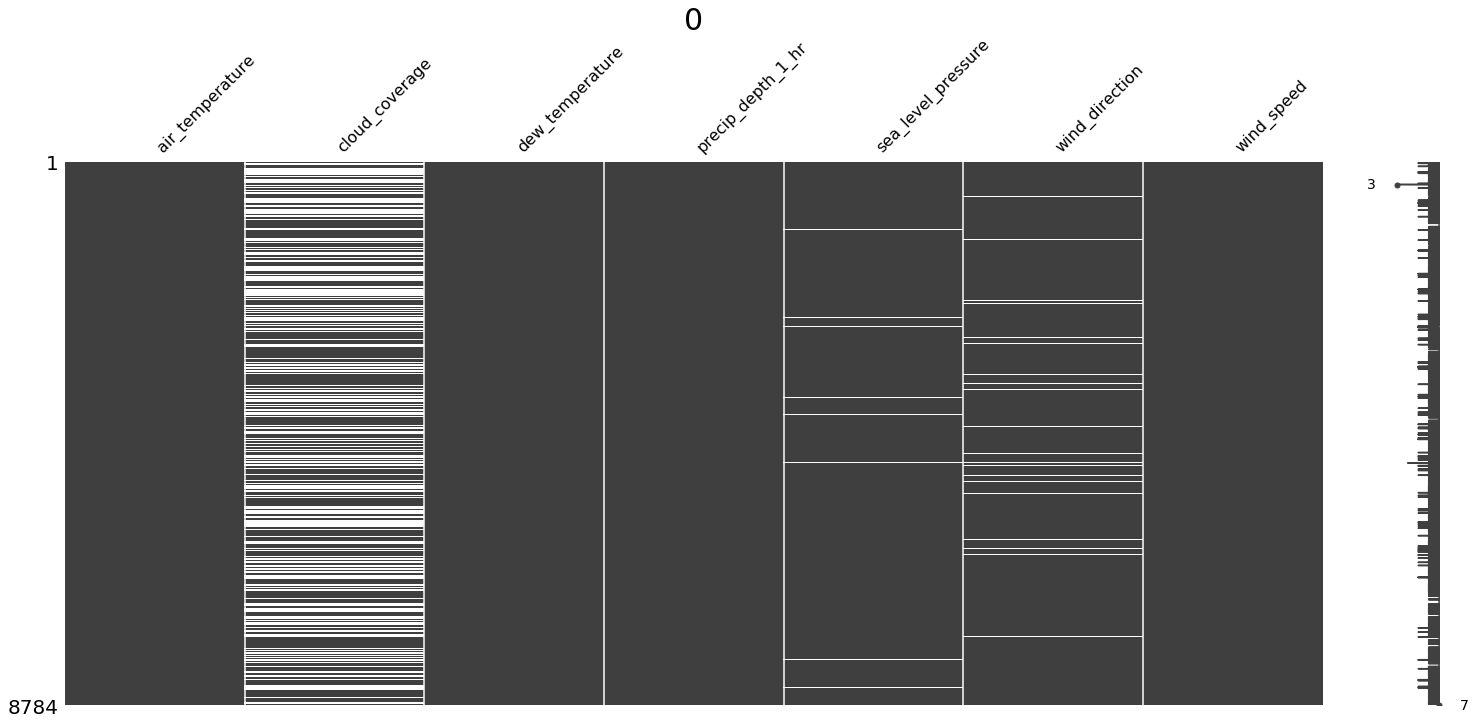

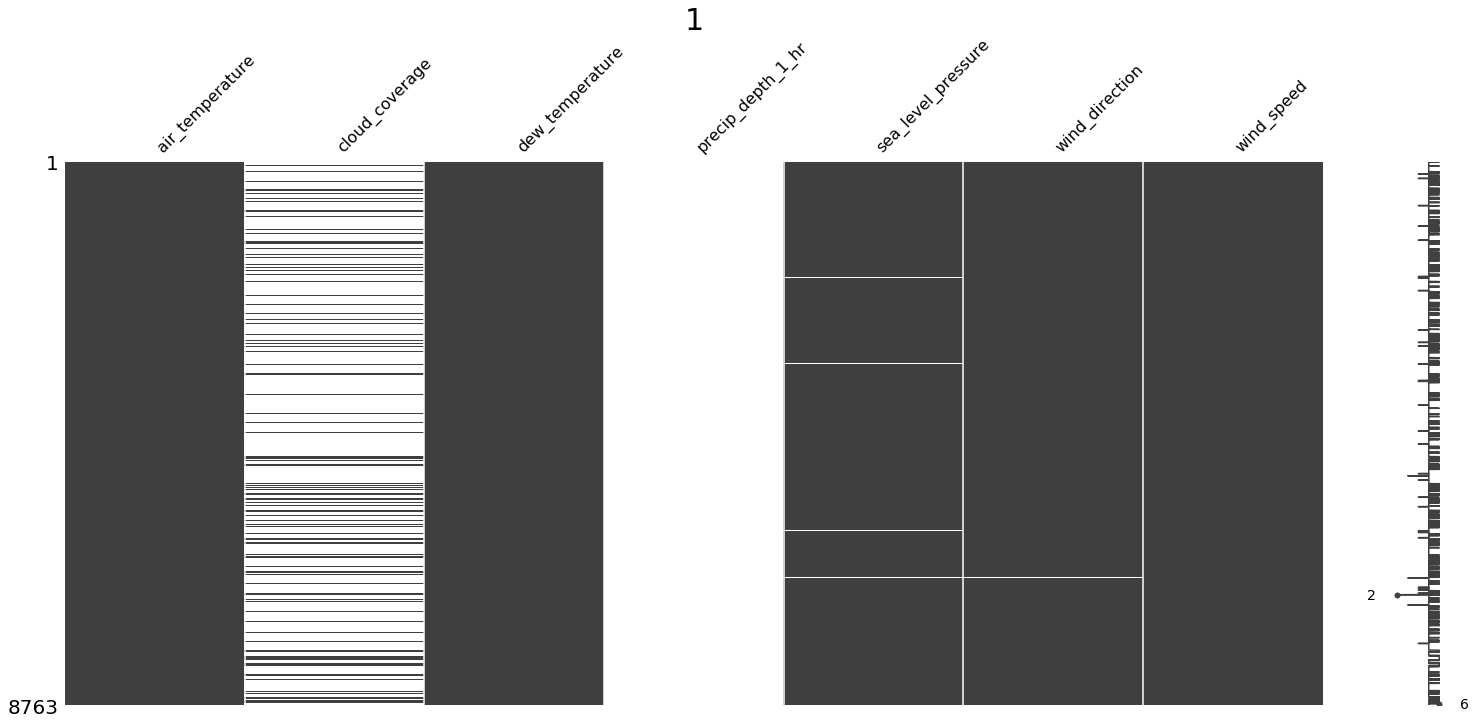

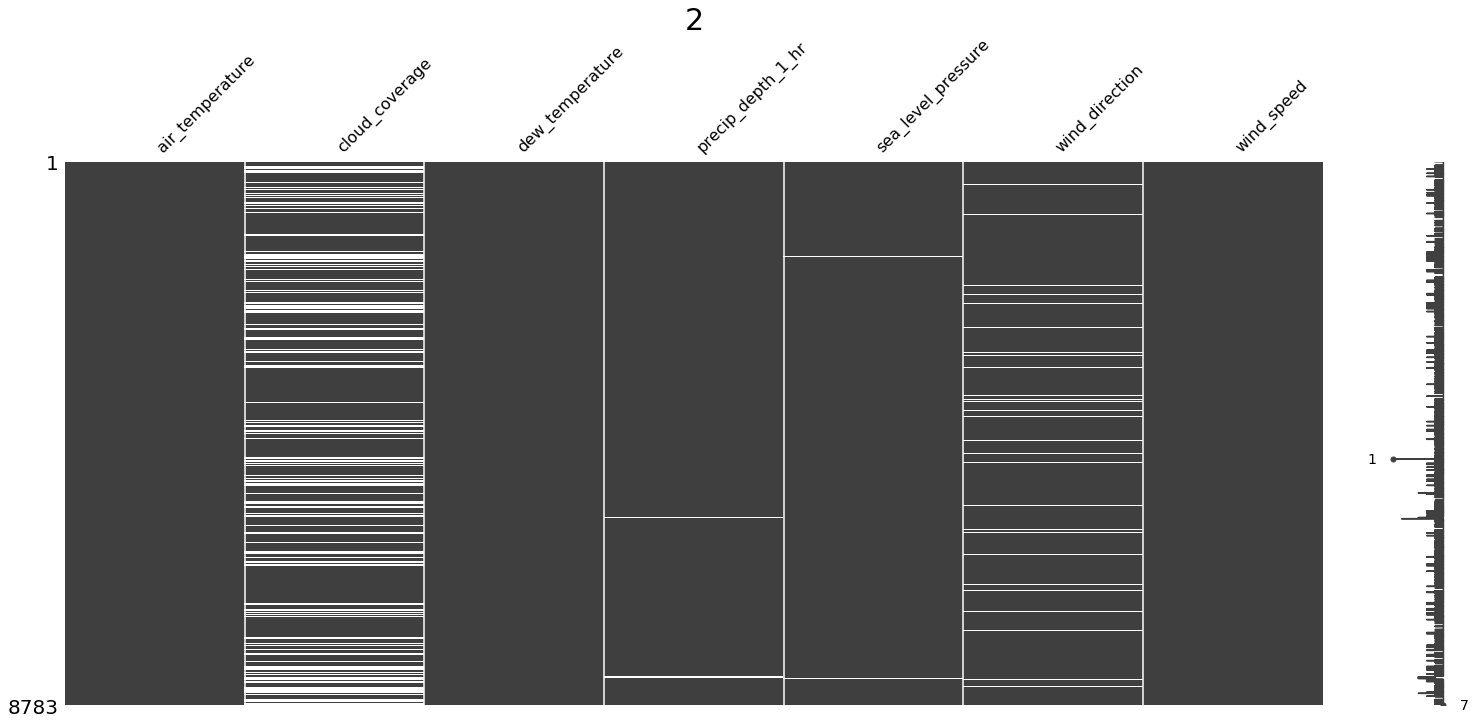

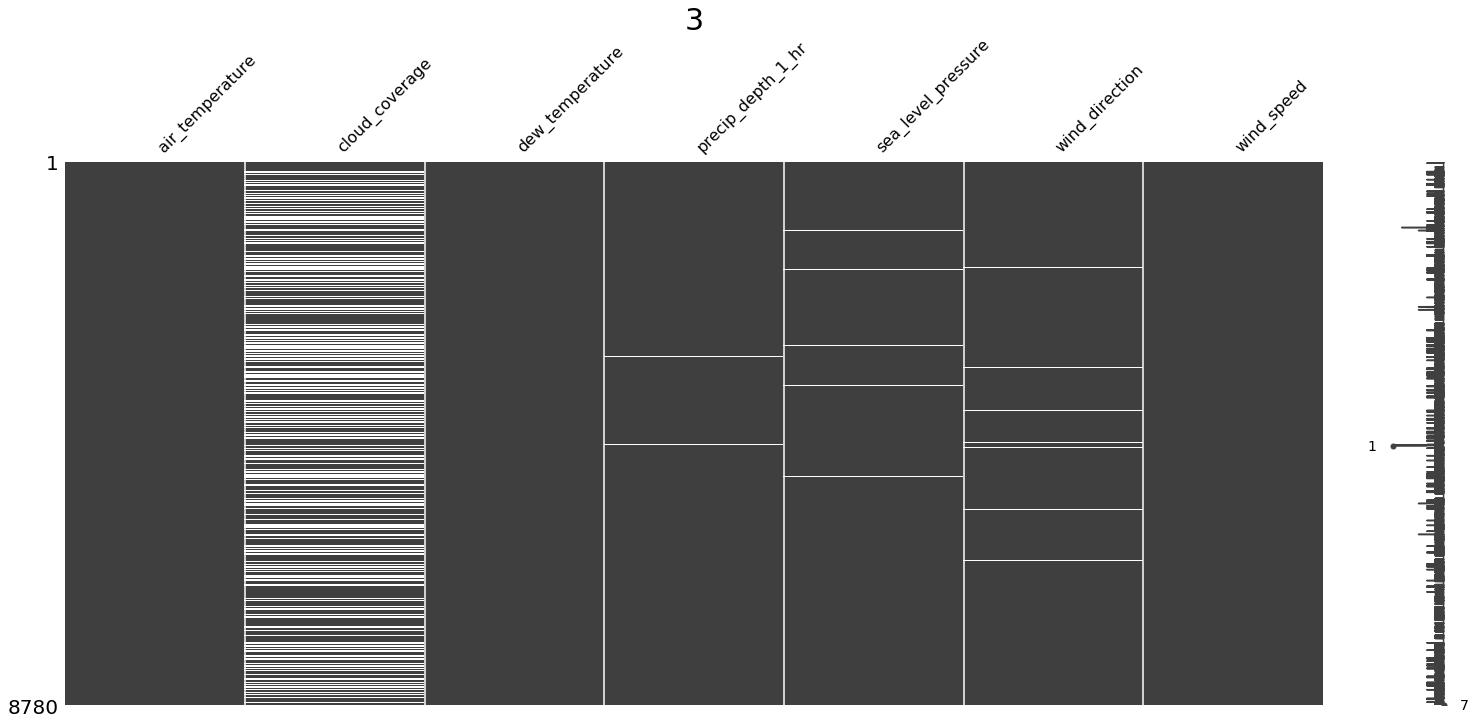

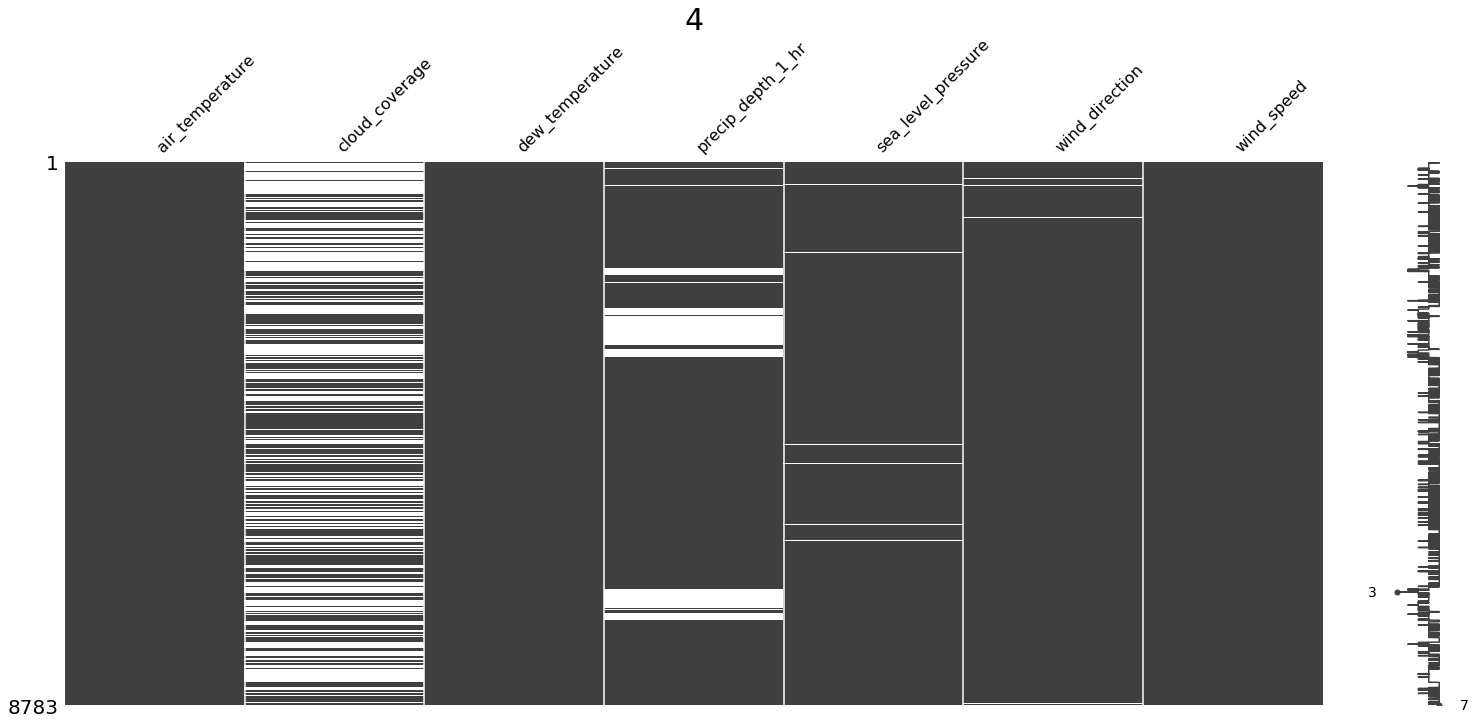

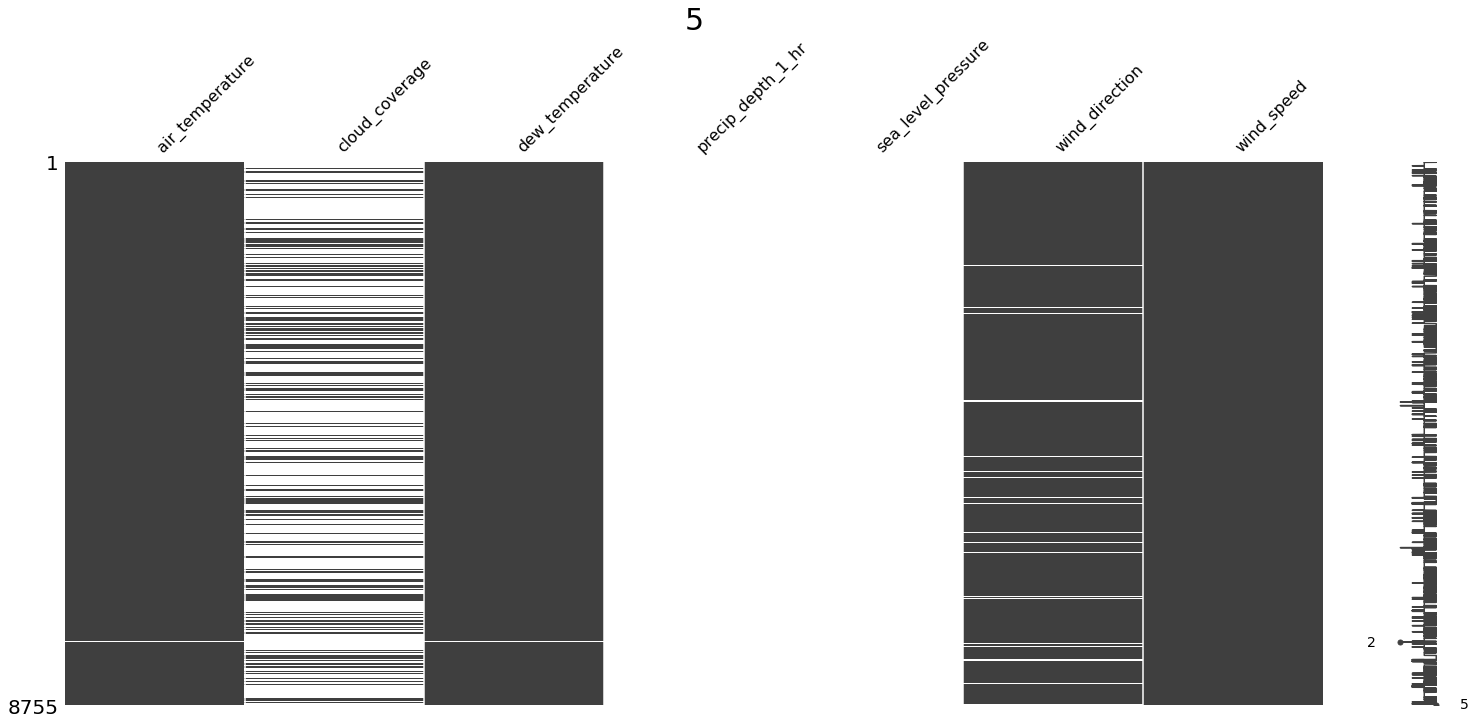

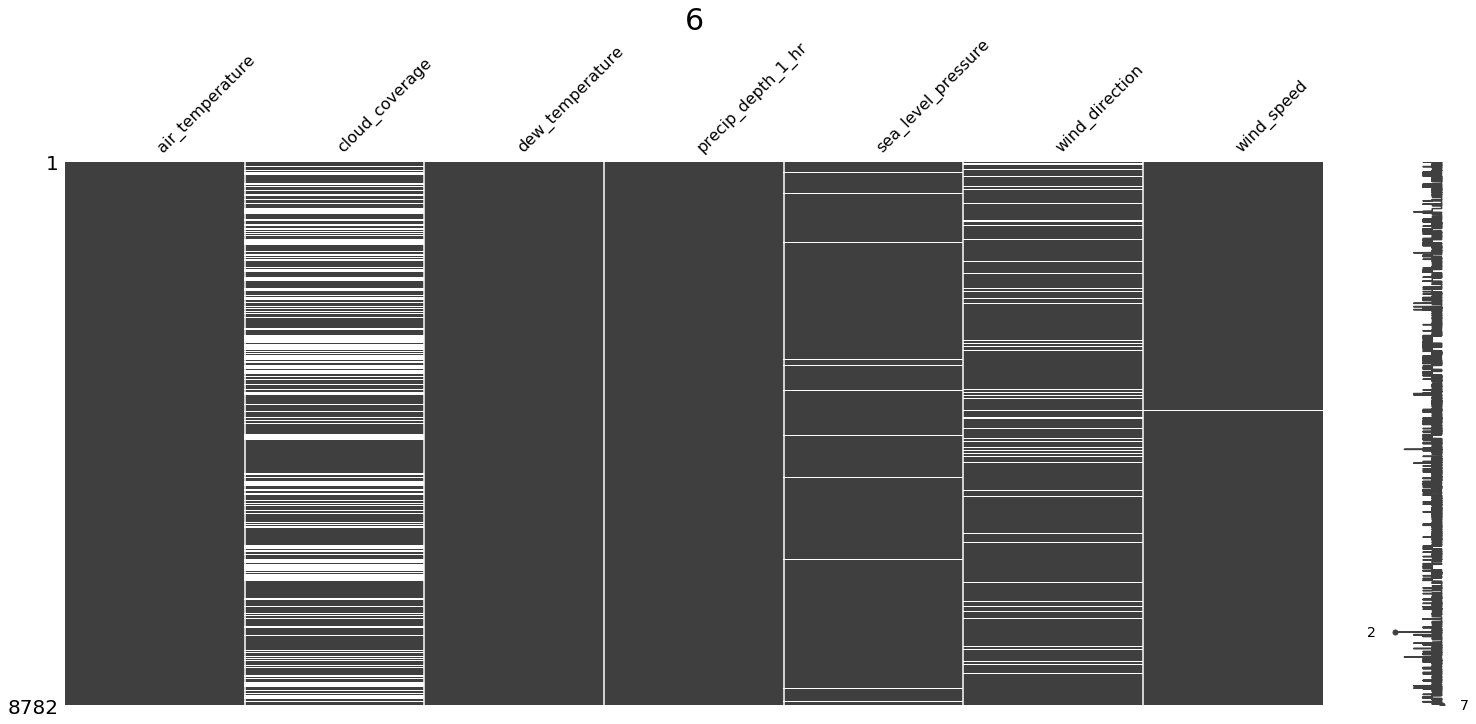

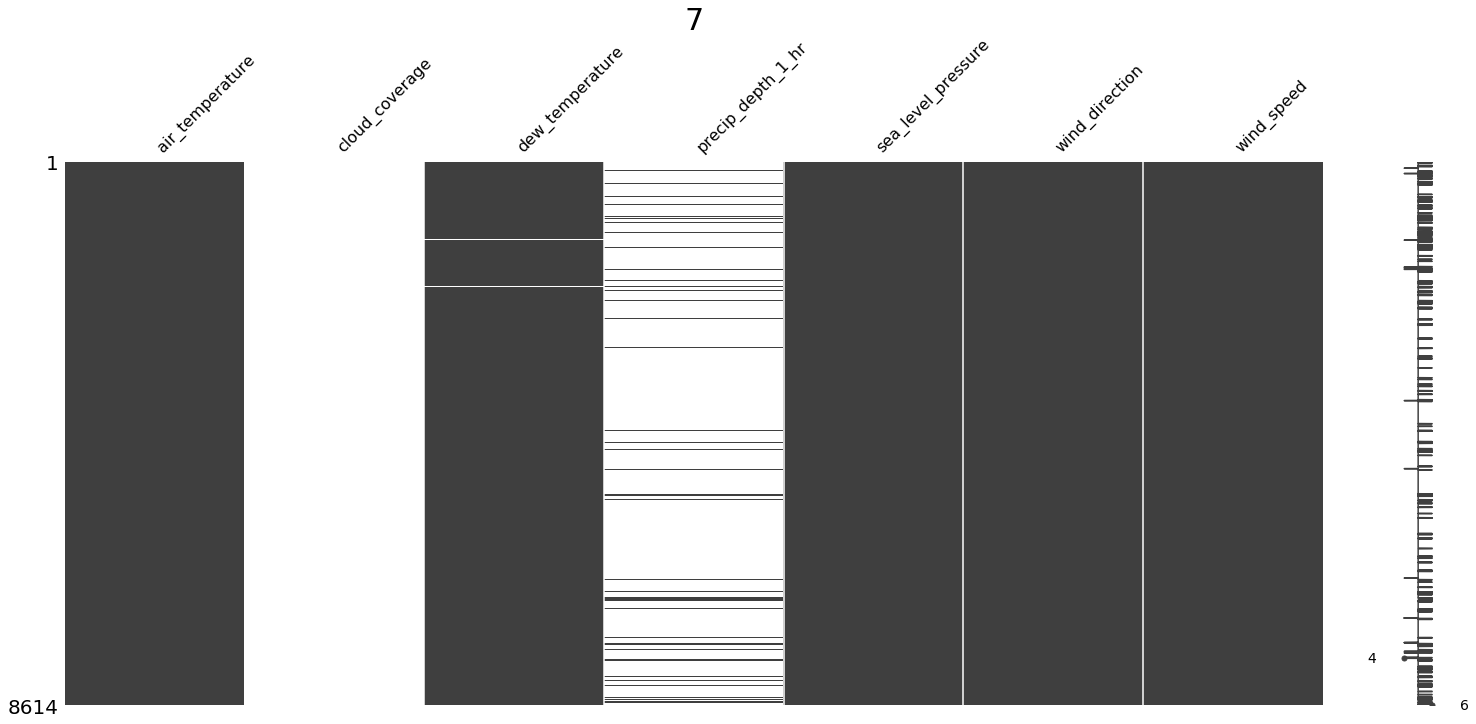

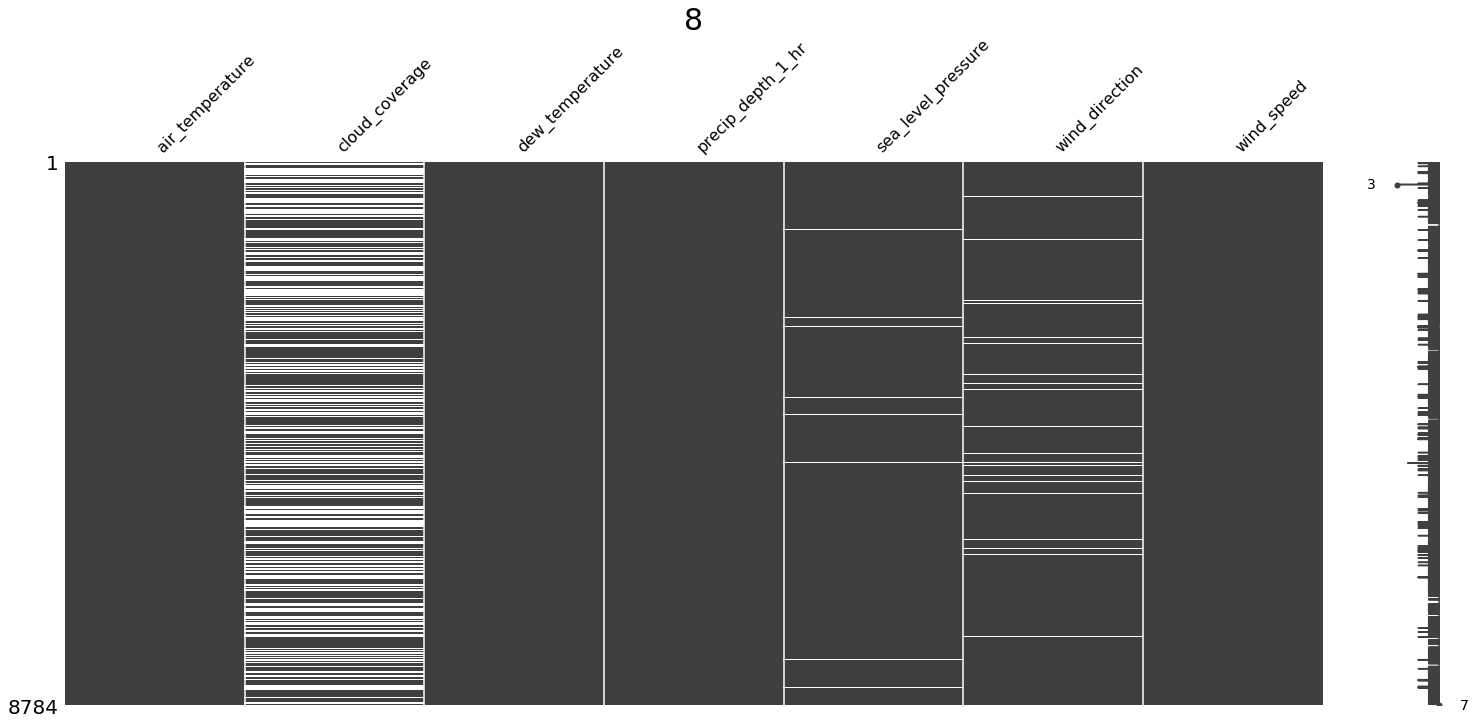

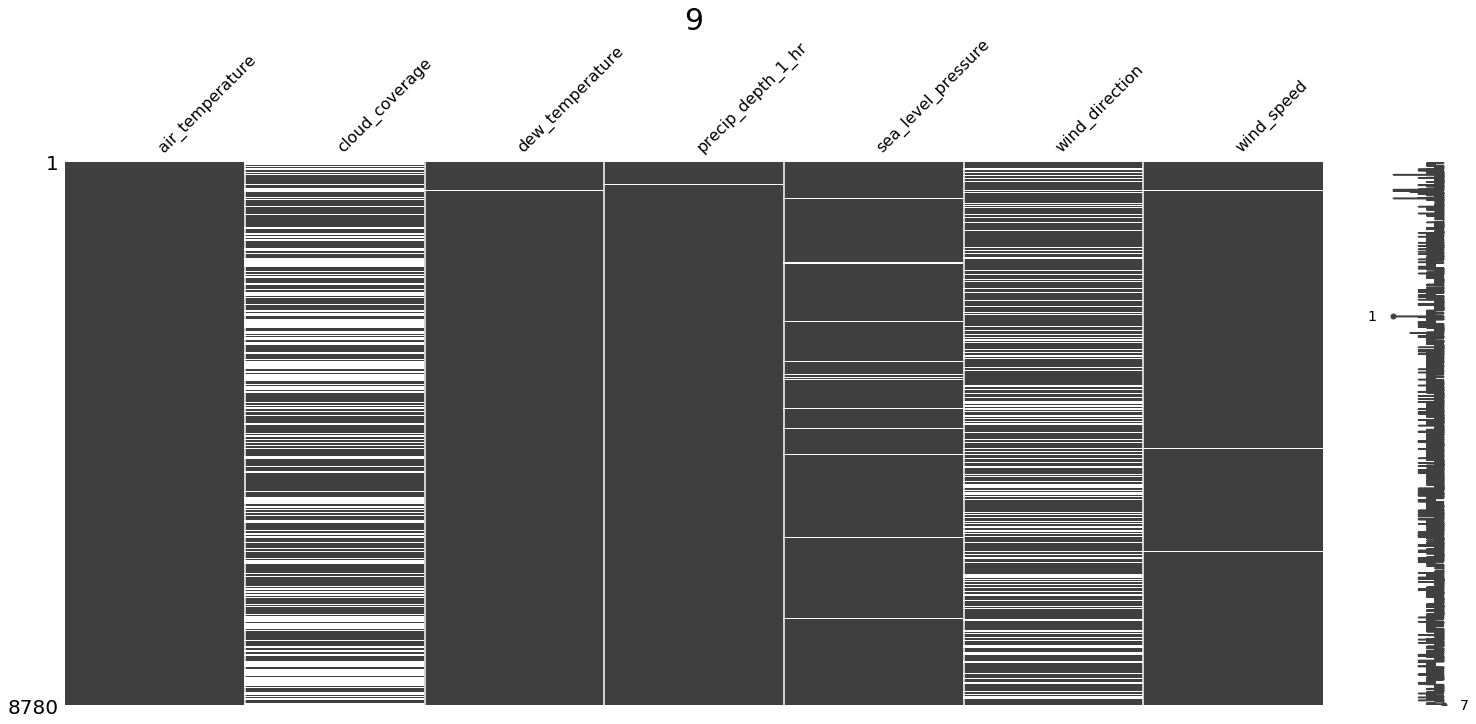

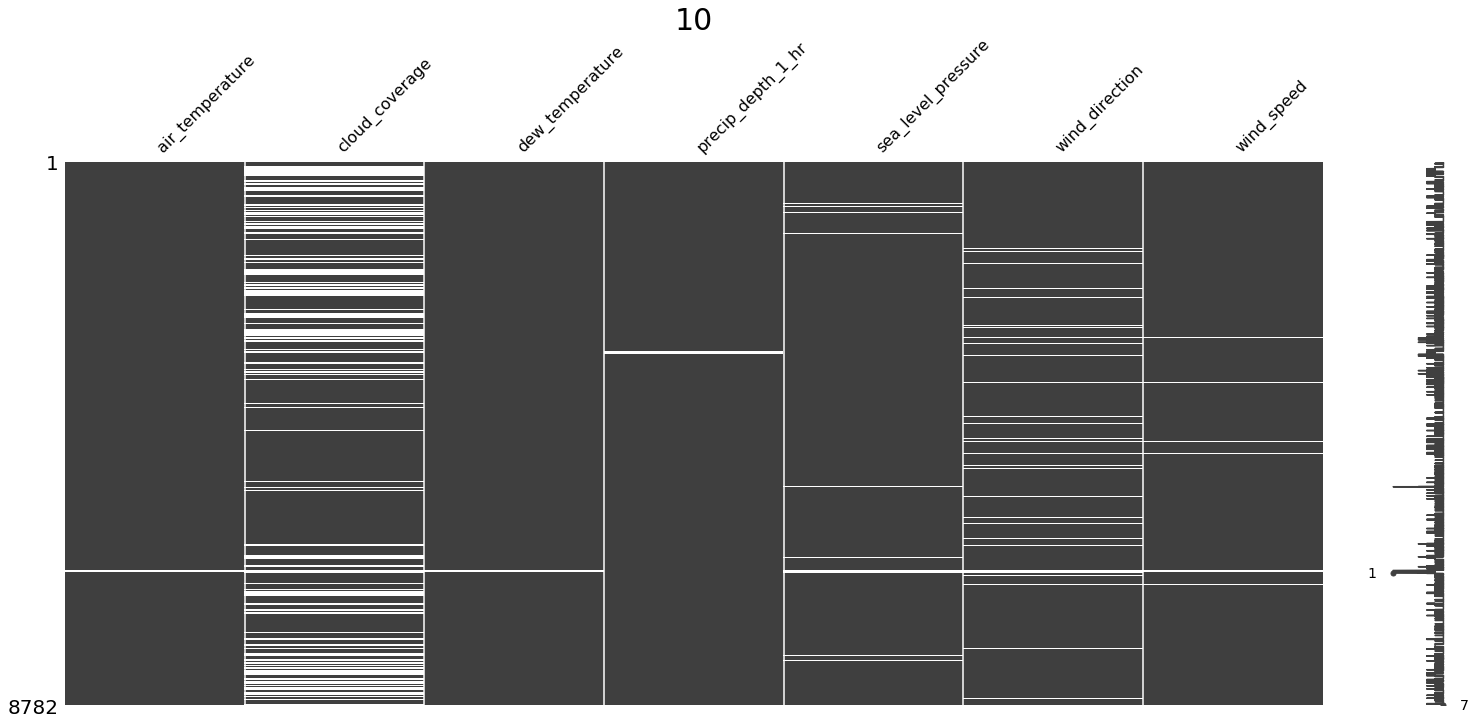

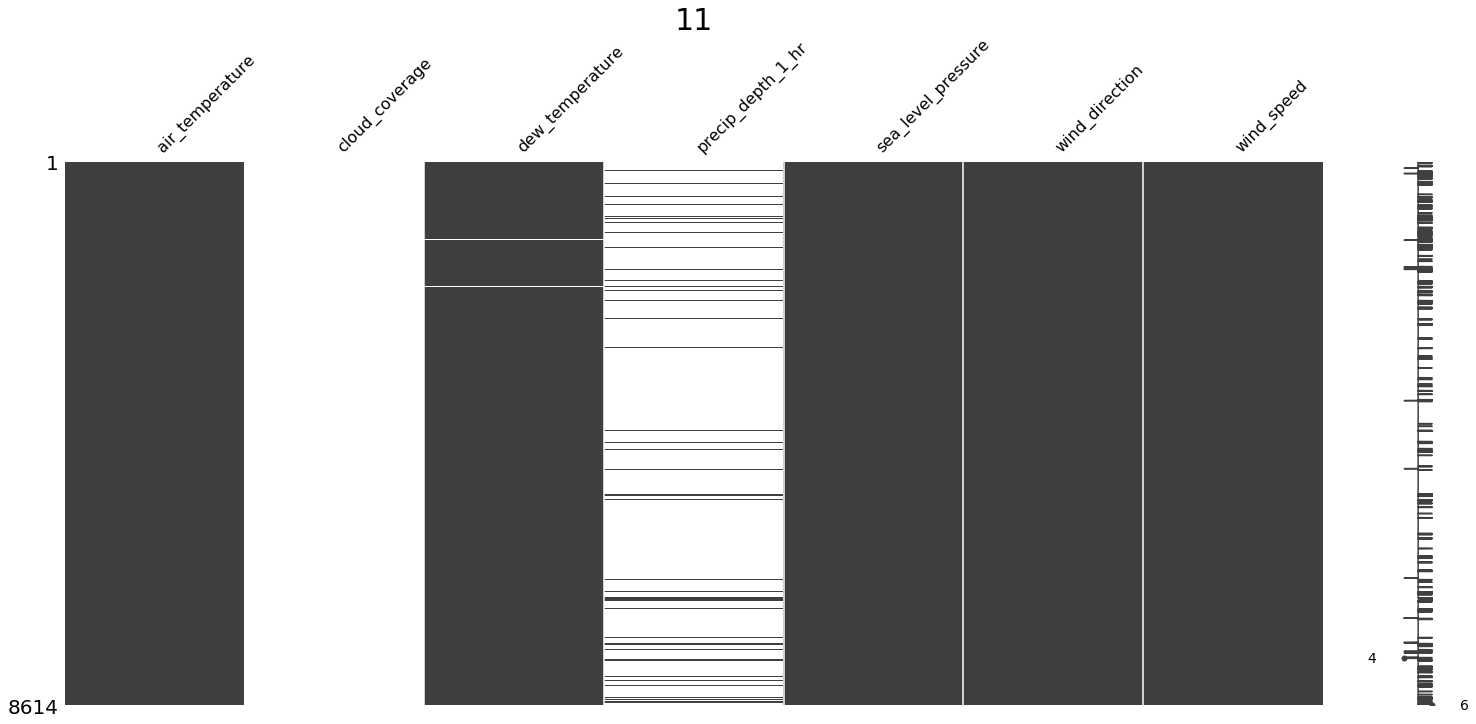

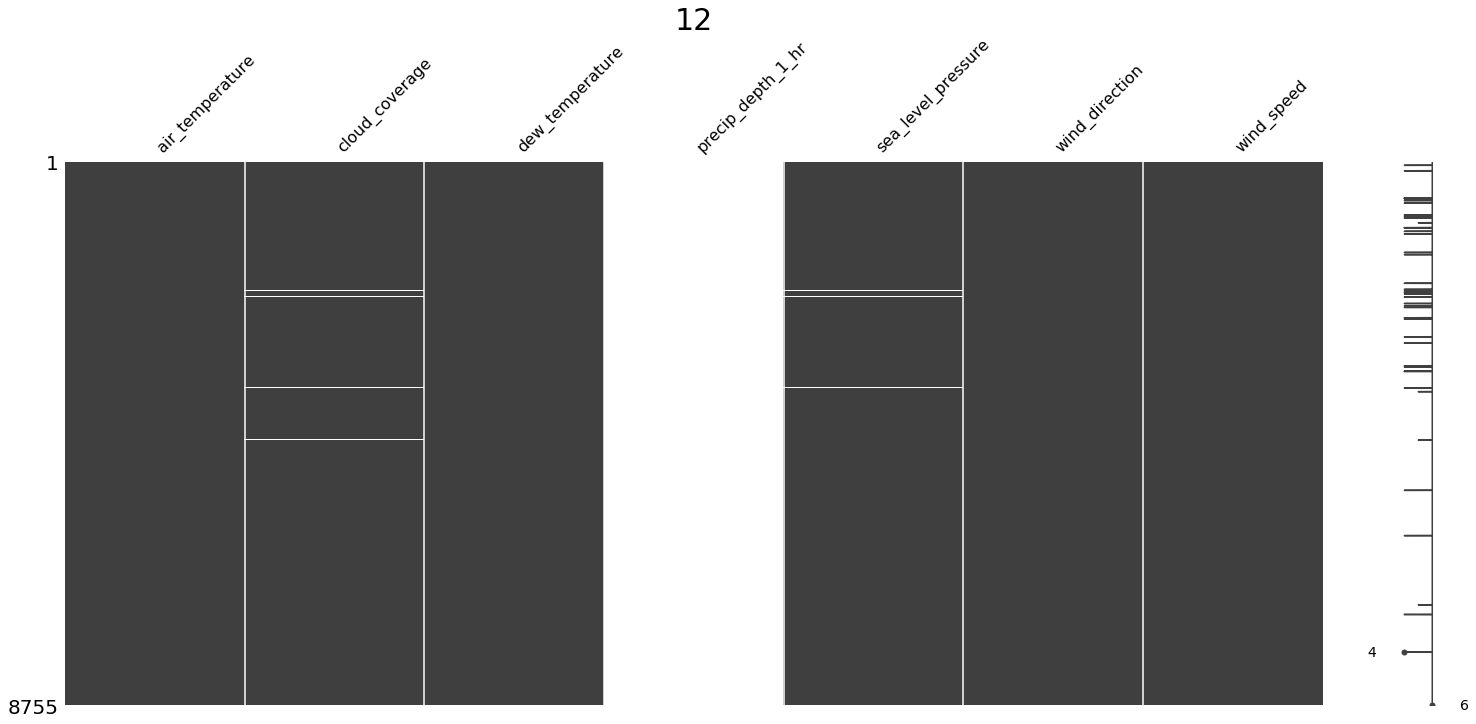

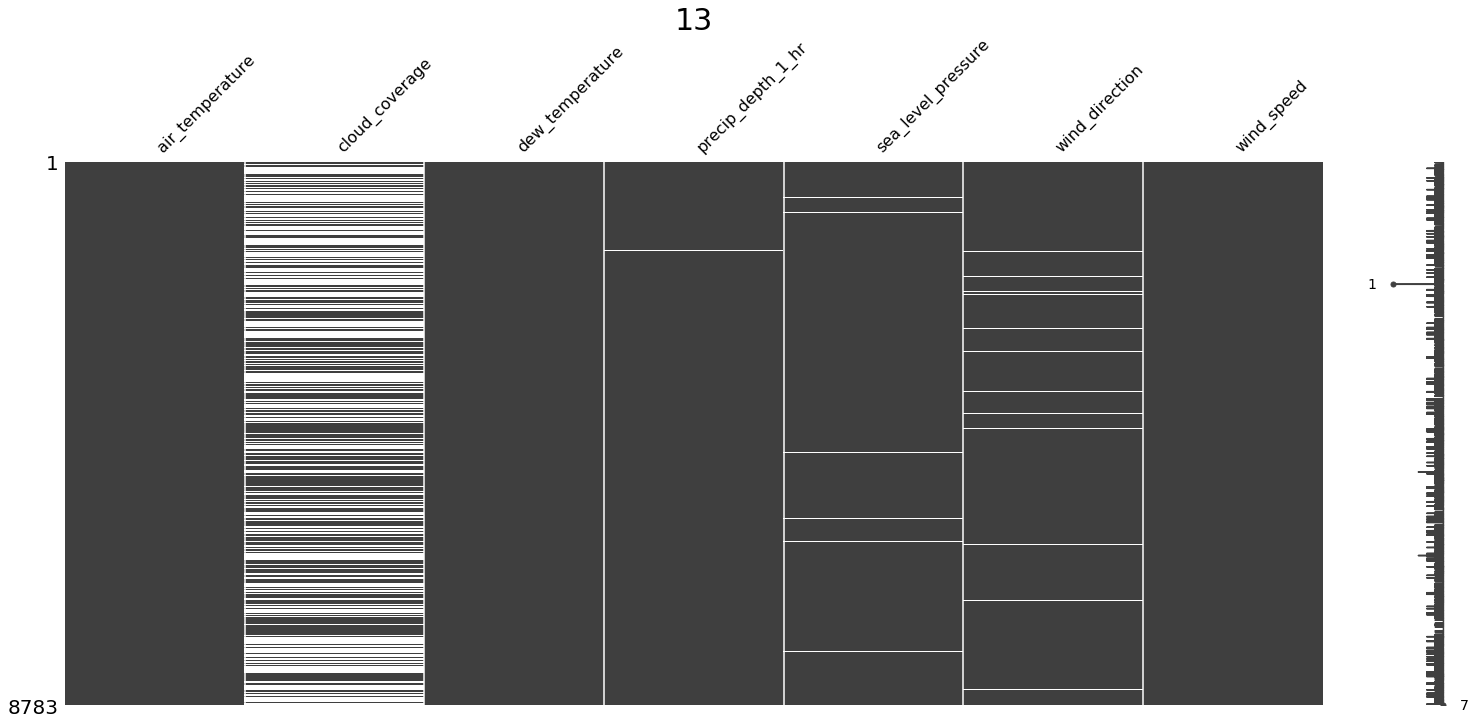

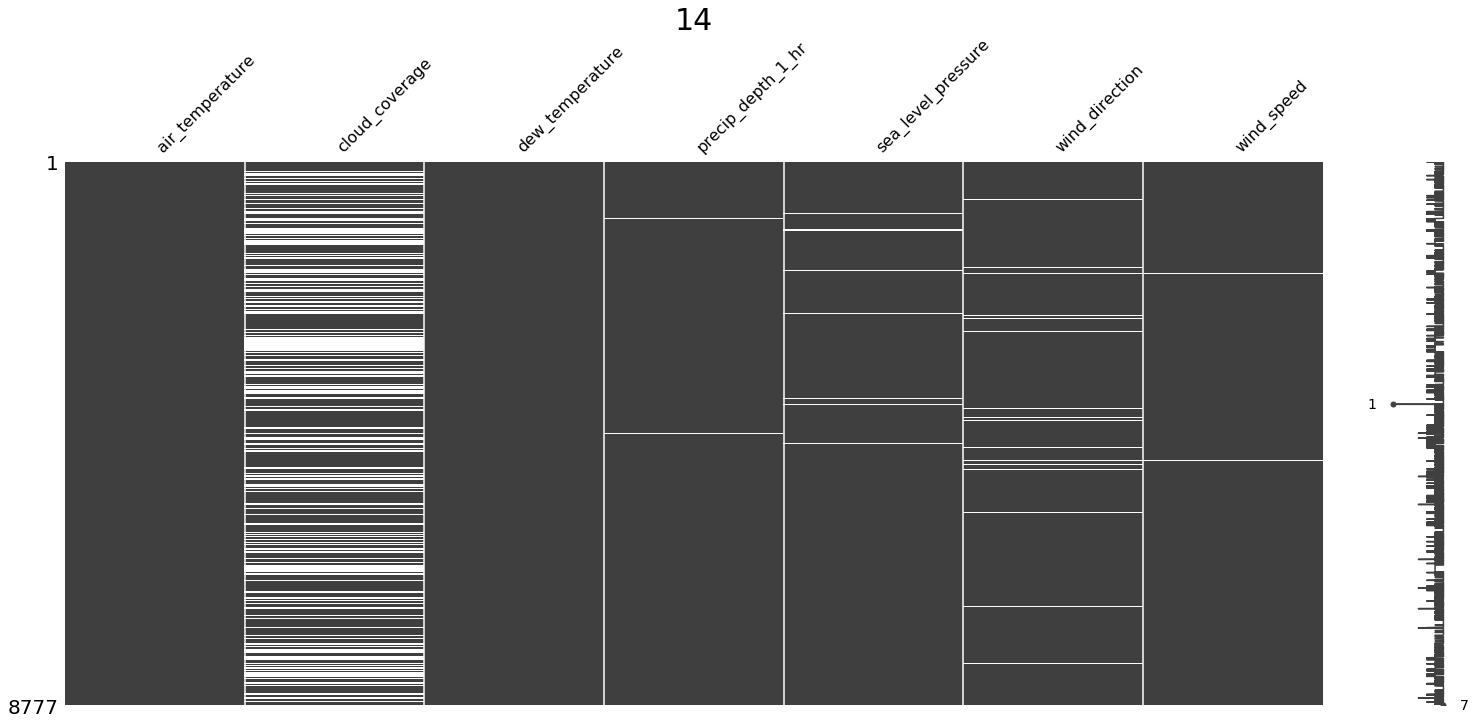

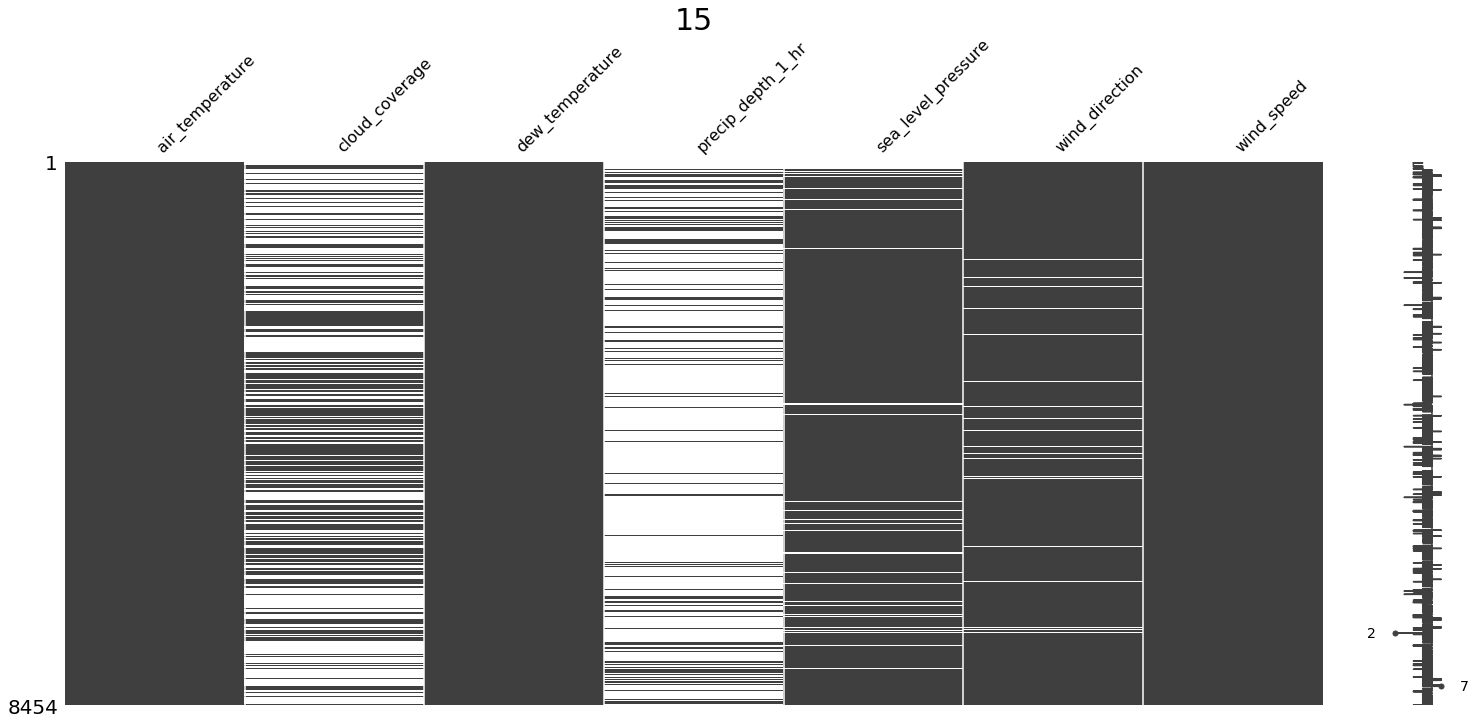

In [24]:
import missingno as mn

for x in df_weather.site_id.unique():
    mn.matrix(df_weather[df_weather['site_id']==x][df_weather.columns[2:]])
    plt.title(x, fontsize=30)
    plt.show()

- site 2 has no precip depth , site 5 has chunks missing from precip depth 
- site 5 is missing both precip depth and sea level pressure 
- site 8 is missing cloud coverage, and precip depth 
- site 12 is missing both cloud coverage and precip depth 
- site 13 and 16 missing precip depth 
    
- cloud coverage is super patchy, wind direction relatively easy, 
- precip depth seems to be missing huge chunks at a time 
- sea level pressure mostly ok, except for one area where there are no data at all 

From this, we can make some decisions for feature engineering. 

1. Aside from cloud coverage and precipitation depth, the majority of nan values will benefit from being filled in by forward/back propagation of the last known value. This method is likely to bring better results than averaging the daily values, as temperature, precipitation, etc. can change substantially throughout a day. (However, a variety of methods, including daily averaging, and a combination of back/forward propagation and averaging can be 
2. For cloud coverage and precip depth, we are making the assumption that nan=0, as in, there were no values. We can test model performance with a different interpretation if needed. 
3. For sea level pressure in region 5, the current assumption is that sea level pressure is missing because this site is too far away from the ocean. We will therefore put a value of 0 for the site when feature engineering. 

Now, let's create a summary of how different climate variables interact with each other.

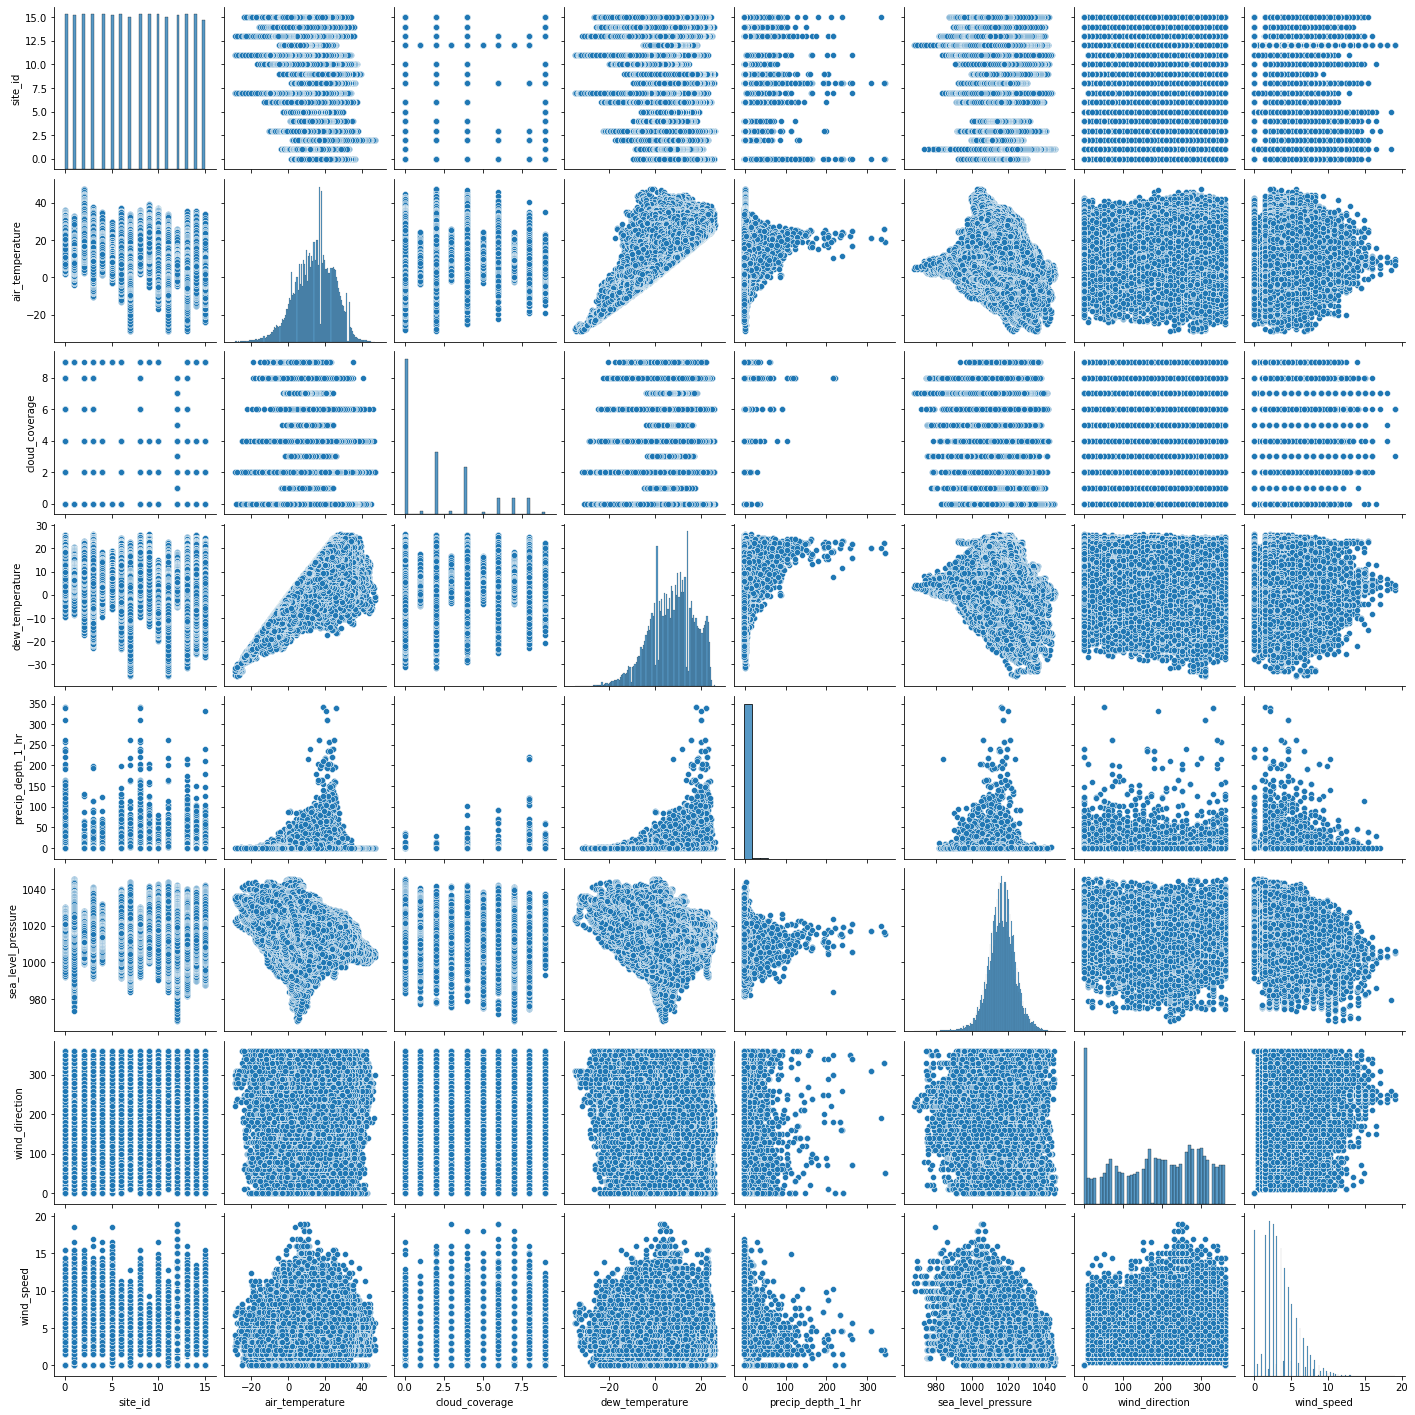

In [25]:
sns.pairplot(df_weather.drop('timestamp',axis=1))

Observations from this pairplot:

- site_id vs.:
    - air_temperature: we can see some variation in the temperature with site id, suggesting that some regions are colder than others 

- air_temperature vs.: 
    - dew_temperature: always <= air_temperature; the variability of dew_temperature increases as temp increases 
    - precipitation: occurs between ~-10 to 30C, beyond which air doesnt hold much moisture 

- dew_temperature: 
    - precipitation: ppt and dew temp appear to have a positive correlation 

- precipitation: 
    - sea_level_pressure: there seems to be a sweet spot between ~1000-1300 slp at which ppt occurs 
    - wind_speed: ppt seems more likely at lower wind speed 
    
    
Now, I would like to see how/if temperature varies across different regions, which may substantially impact energy consumption. 

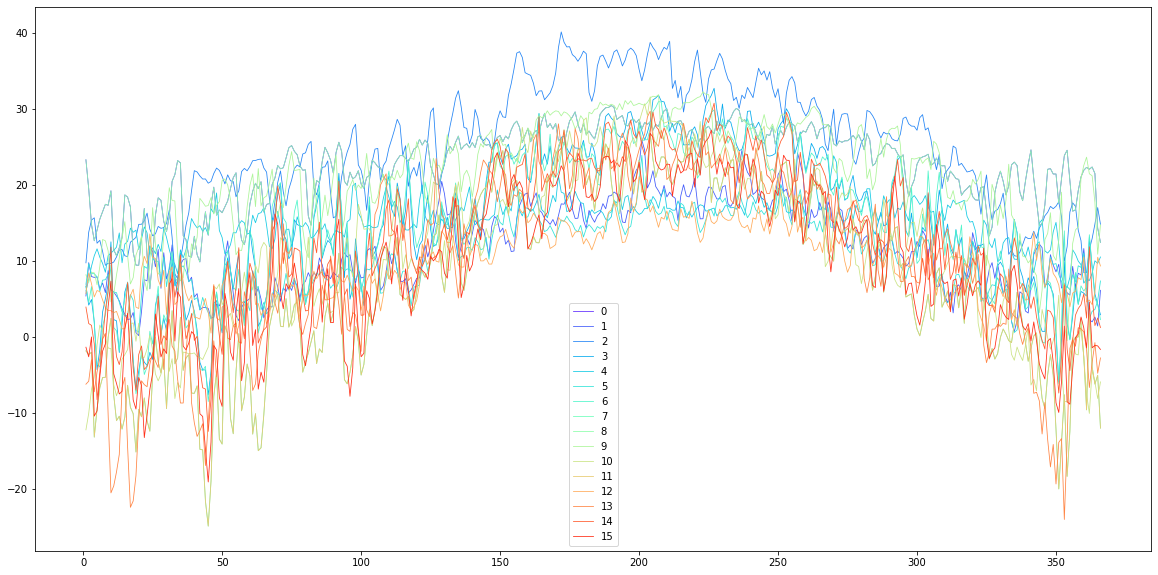

In [26]:
plt.subplots(figsize=(20,10))
cols=sns.color_palette("rainbow", 16)
for x in df_weather.site_id.unique():
    temp=df_weather[df_weather.site_id==x].reset_index(drop=True)
    temp['day']=temp['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')).apply(lambda x: x.dayofyear)
    plt.plot(temp.groupby('day').mean()['air_temperature'], lw=0.8, label=int(x), c=cols[int(x)])
    #print(x, 'mean: ', np.mean(temp['air_temperature']), 'max: ', max(temp['air_temperature']), 'min: ',min(temp['air_temperature']))
plt.legend()
plt.show()

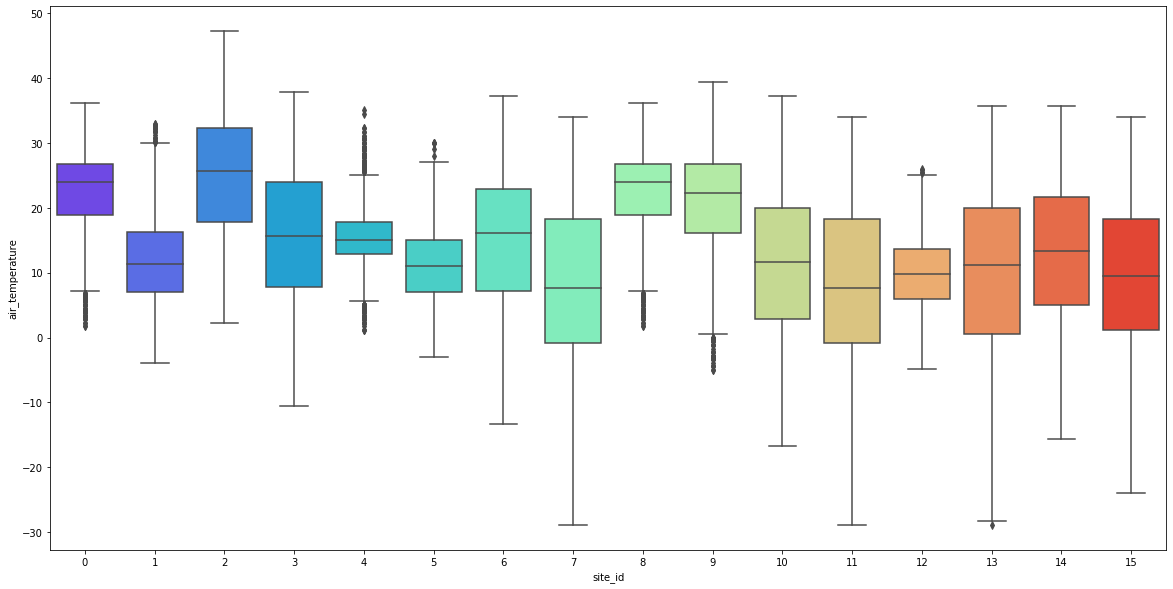

In [27]:
plt.subplots(figsize=(20,10))
sns.boxplot(x='site_id',y='air_temperature',data=df_weather, palette='rainbow')

There do not appear to be any major temperature outliers, however, these sites have a variety of annual temperature ranges. Most notably, site 2 appears to have the highest annual temperature mean and max, while sites 7 and 11 have the lowest mean and min. 

The temperature variability varies across site, with sites 12 and 4, for example, having low temperature variability while sites 7, 11, and 13 (etc). 

Now, let's look at the test weather data. We want to see if the distribution of missing values is the same, if there are major differences in climate, etc. This will help us better understand the best way to engineer our features for prediction. 

site_id
Num nans:  0
% nan:  0.0
n unique:  16
max:  15
min:  0
mean:  7.484654256374372
median:  7.0
timestamp
Num nans:  0
% nan:  0.0
n unique:  17520
air_temperature
Num nans:  104
% nan:  0.037512218523100674
n unique:  639
cannot plot
max:  48.3
min:  -28.1
mean:  14.276862873864685
median:  15.0
cloud_coverage
Num nans:  140448
% nan:  50.658808337811955
n unique:  10
max:  9.0
min:  0.0
mean:  2.1873167878942943
median:  2.0
dew_temperature
Num nans:  327
% nan:  0.11794707170244155
n unique:  559
cannot plot
max:  26.7
min:  -31.6
mean:  7.48765835126872
median:  8.4
precip_depth_1_hr
Num nans:  95588
% nan:  34.47805715563603
n unique:  174
cannot plot
max:  597.0
min:  -1.0
mean:  1.095395117117613
median:  0.0
sea_level_pressure
Num nans:  21265
% nan:  7.670166604747459
n unique:  717
max:  1050.1
min:  972.0
mean:  1016.1957621358058
median:  1016.3
wind_direction
Num nans:  12370
% nan:  4.461789837795725
n unique:  60
max:  360.0
min:  0.0
mean:  180.42602303745568
medi

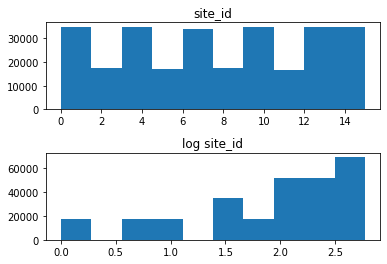

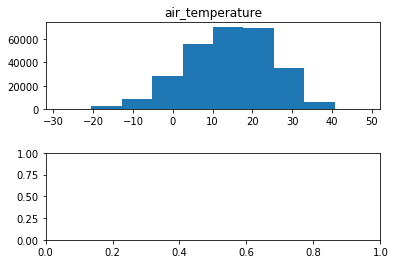

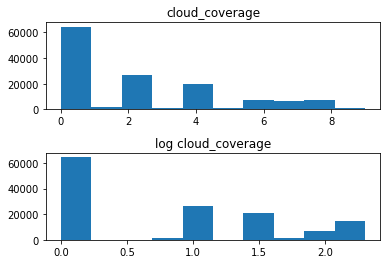

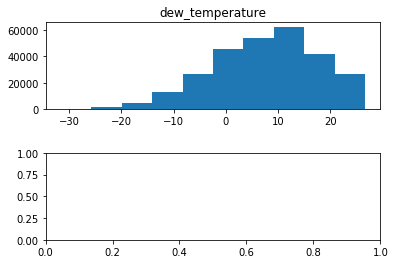

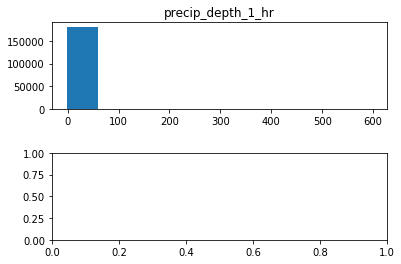

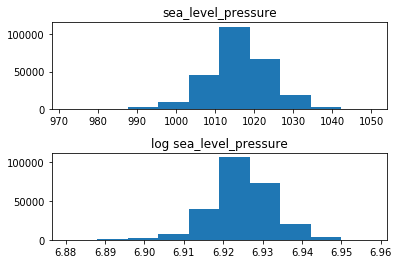

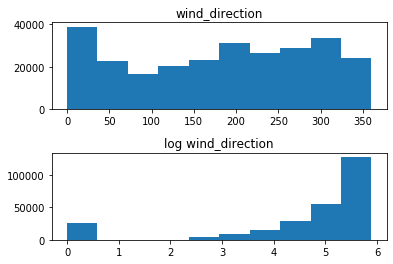

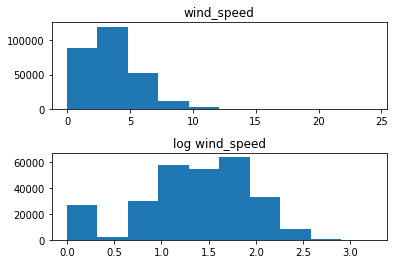

In [28]:
ef.sum_stats(df_weather_test)

This dataset seems to have a relatively similar makeup (based on the nan values, min/max, histograms) to the train dataset, which is good news! It means that the weather data will likely make good predictors. 

Let's take a closer look at the distribution of NaN values, to see if our aforementioned feature engineering approach makes sense. 

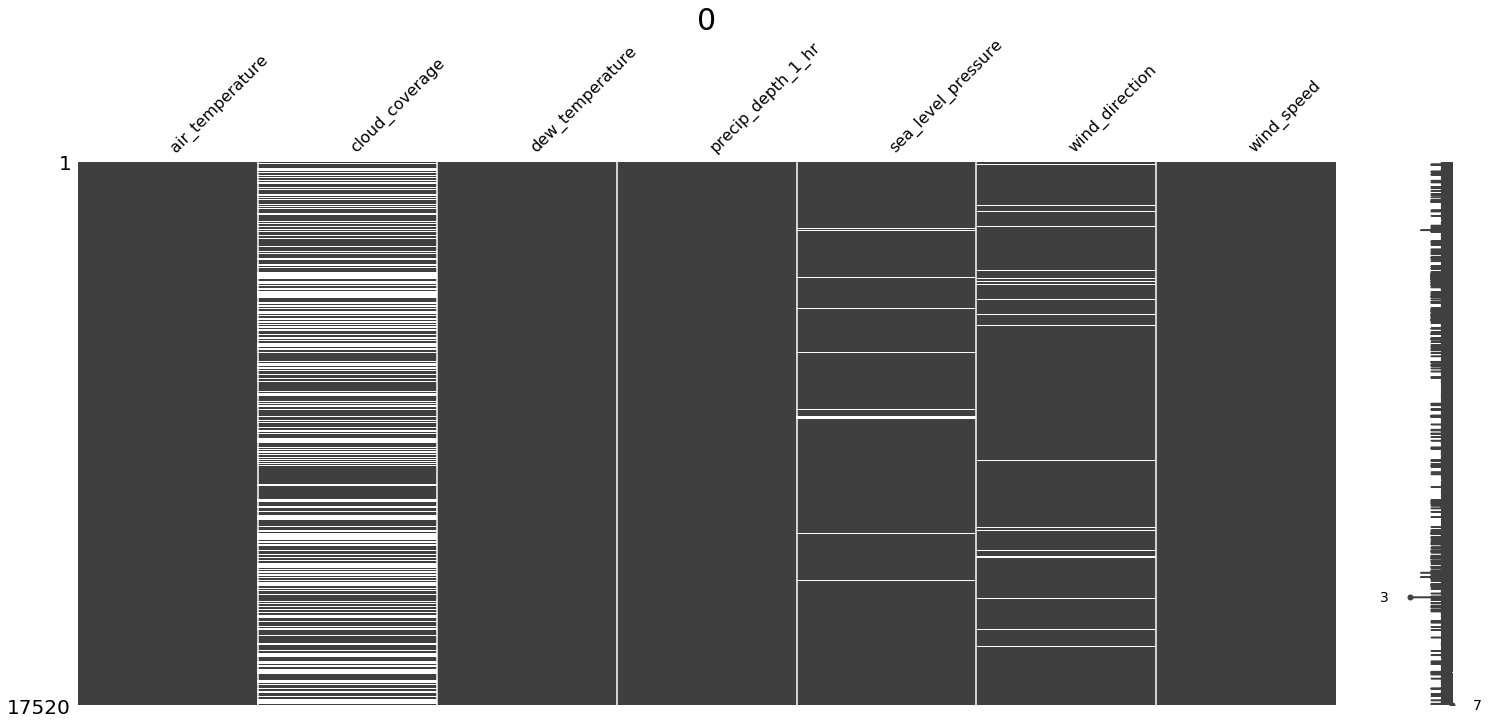

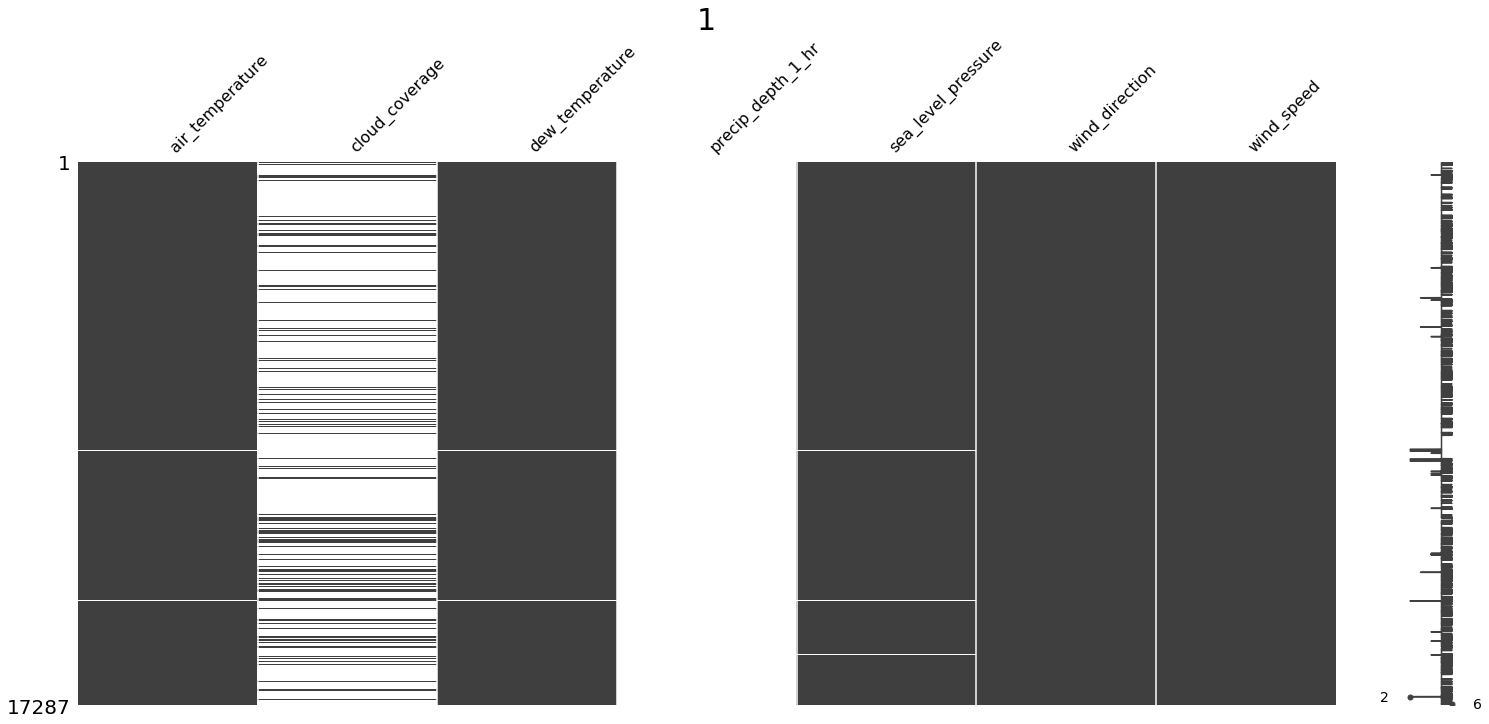

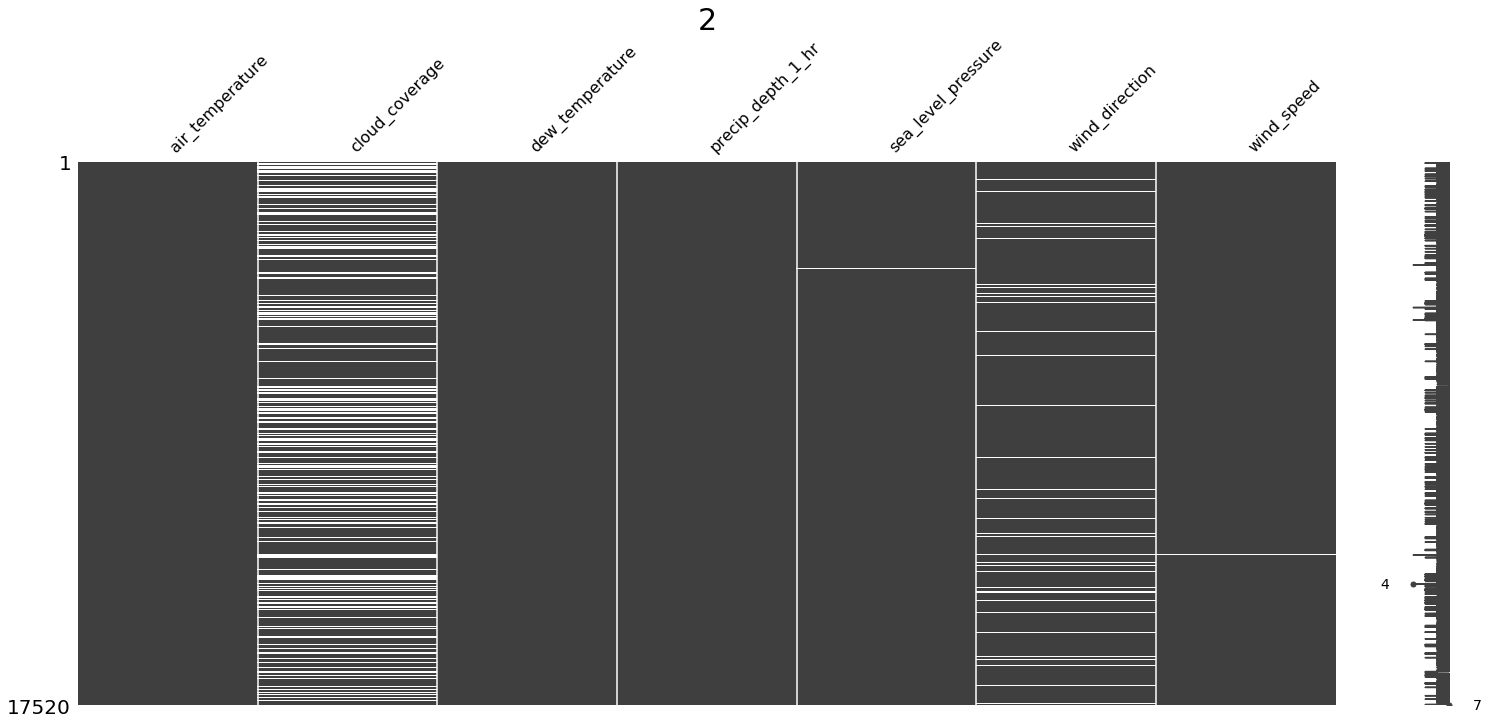

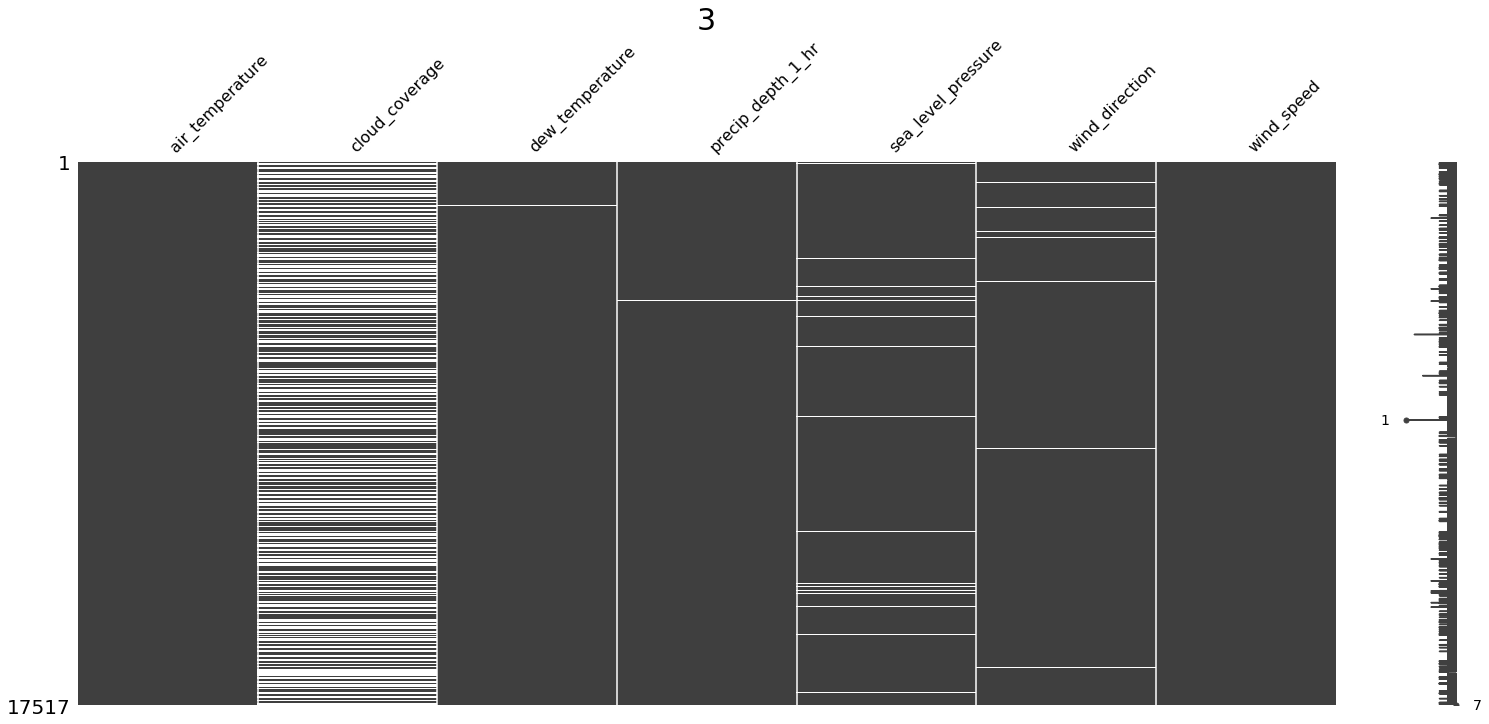

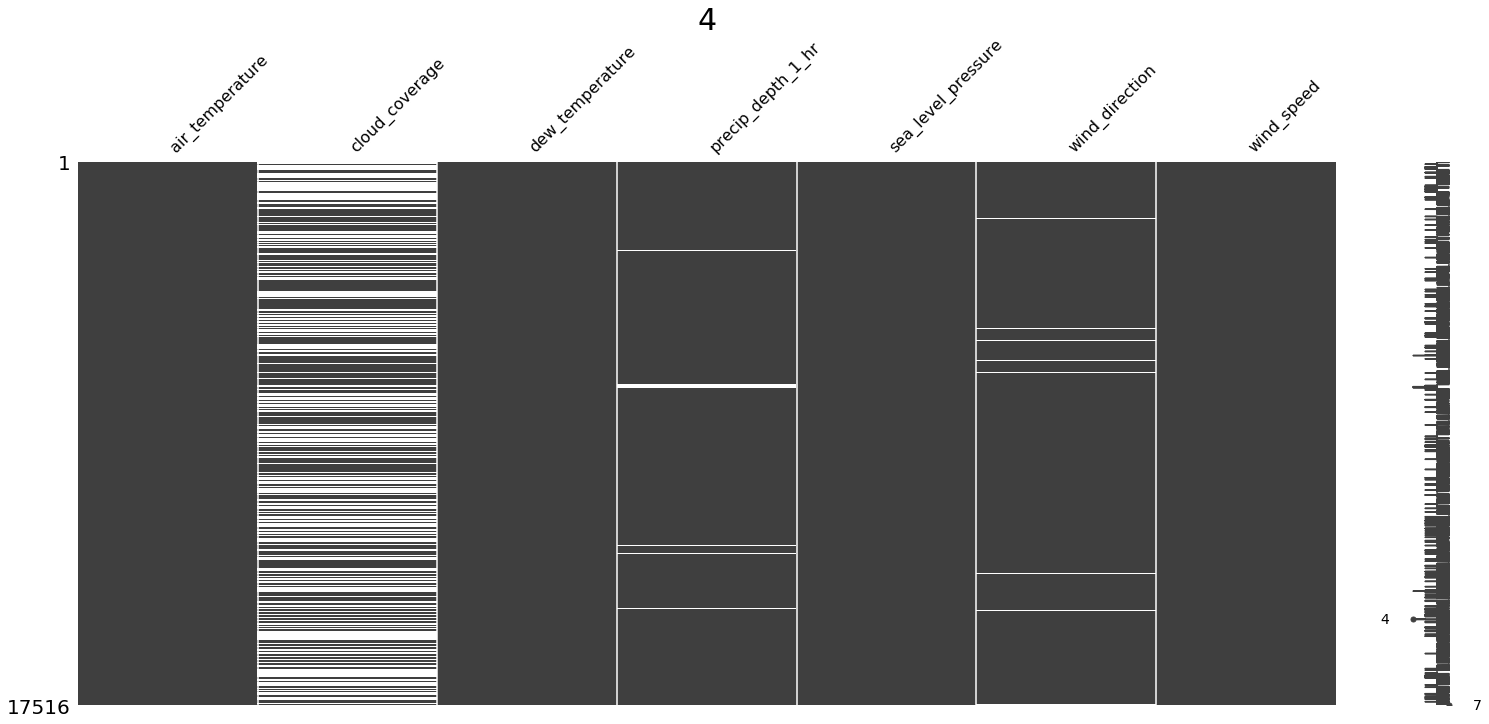

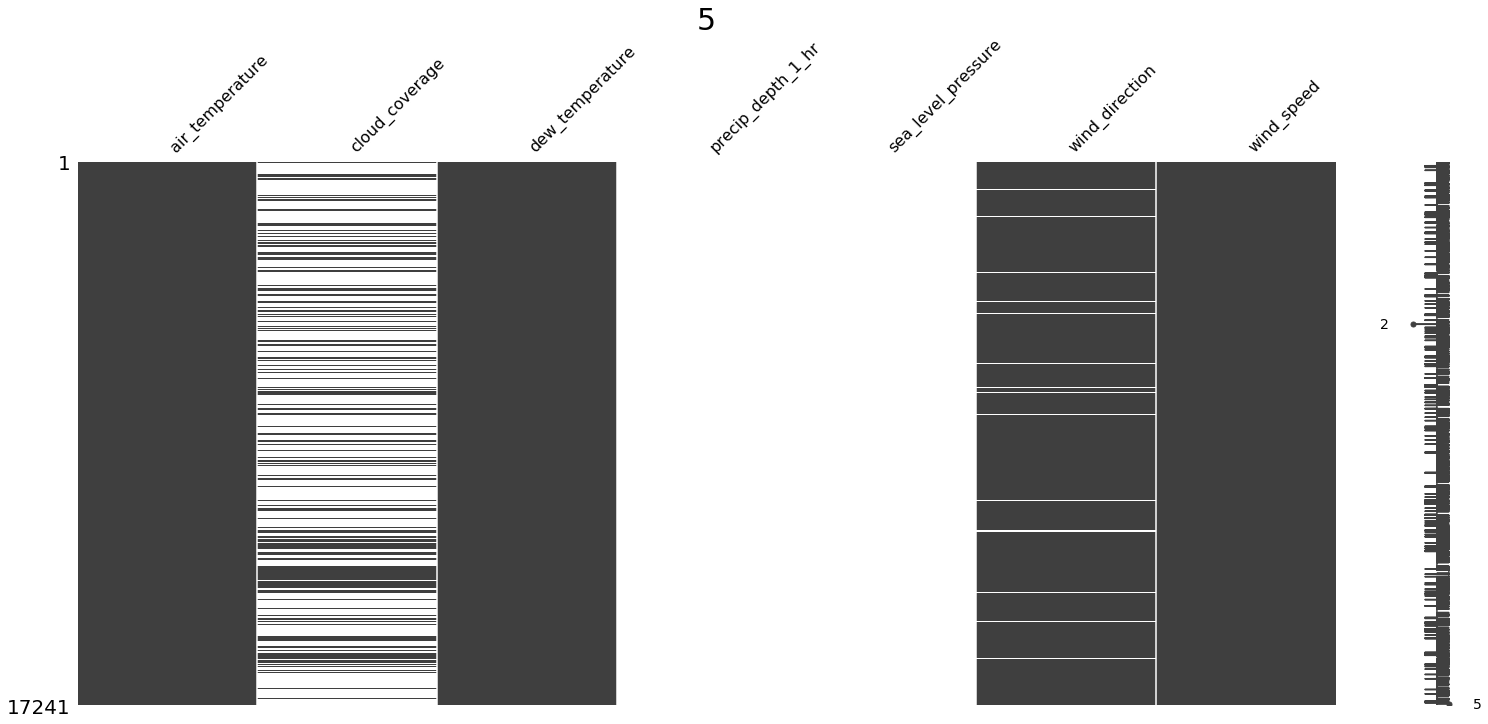

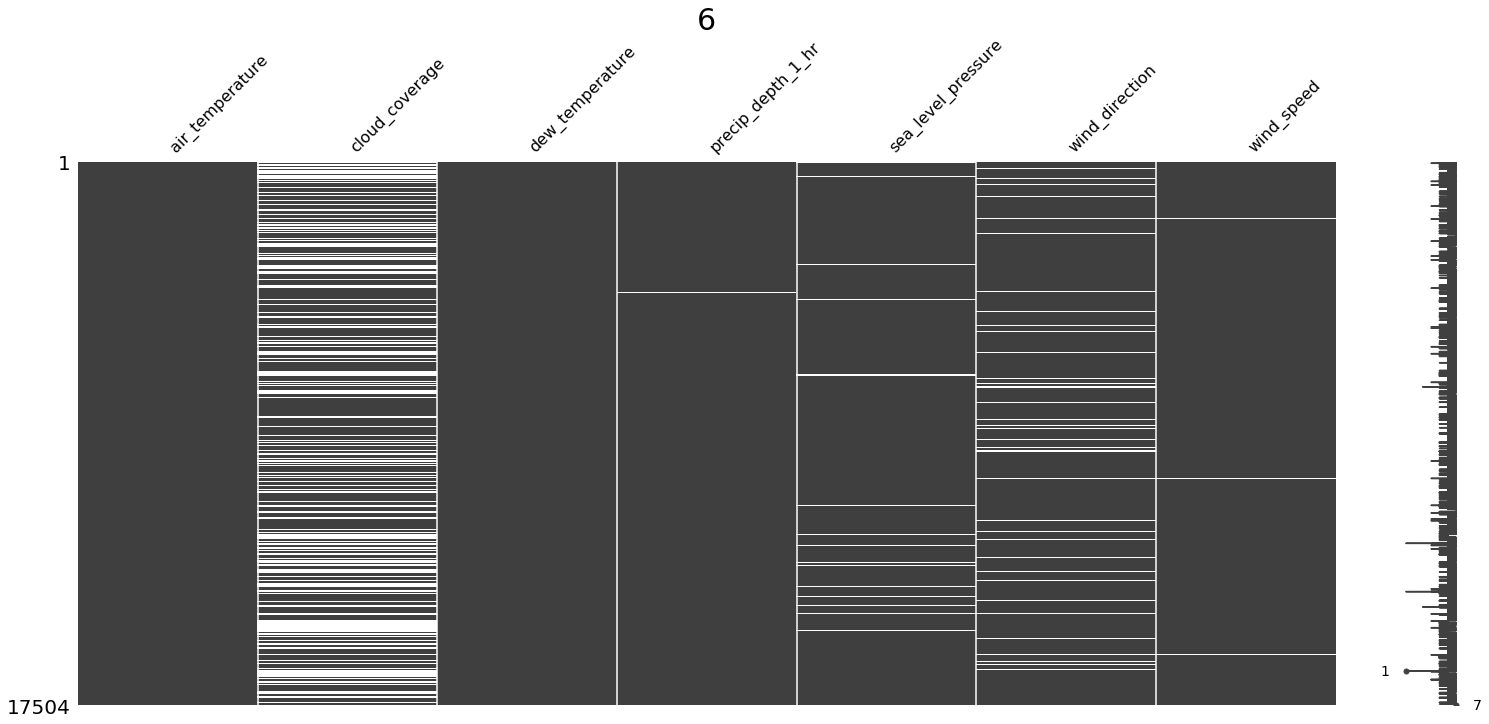

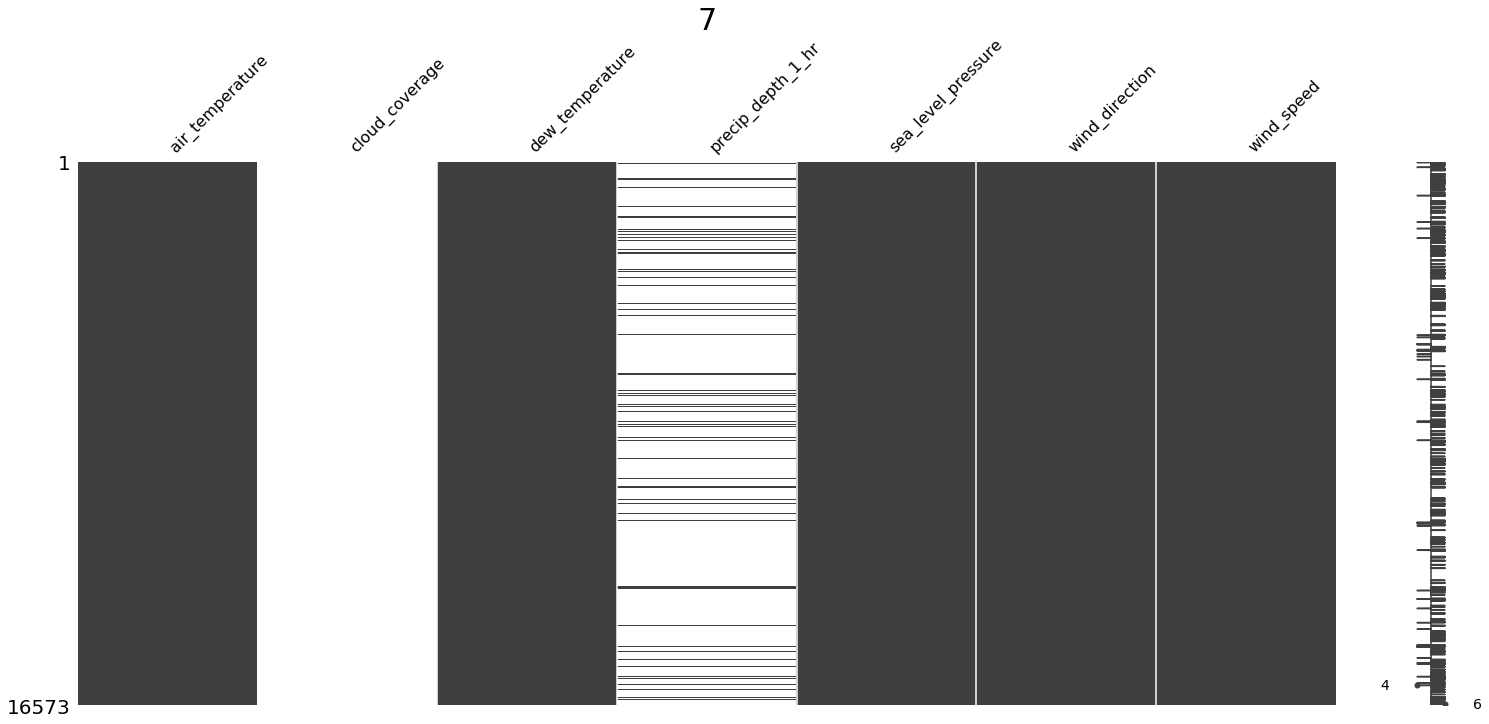

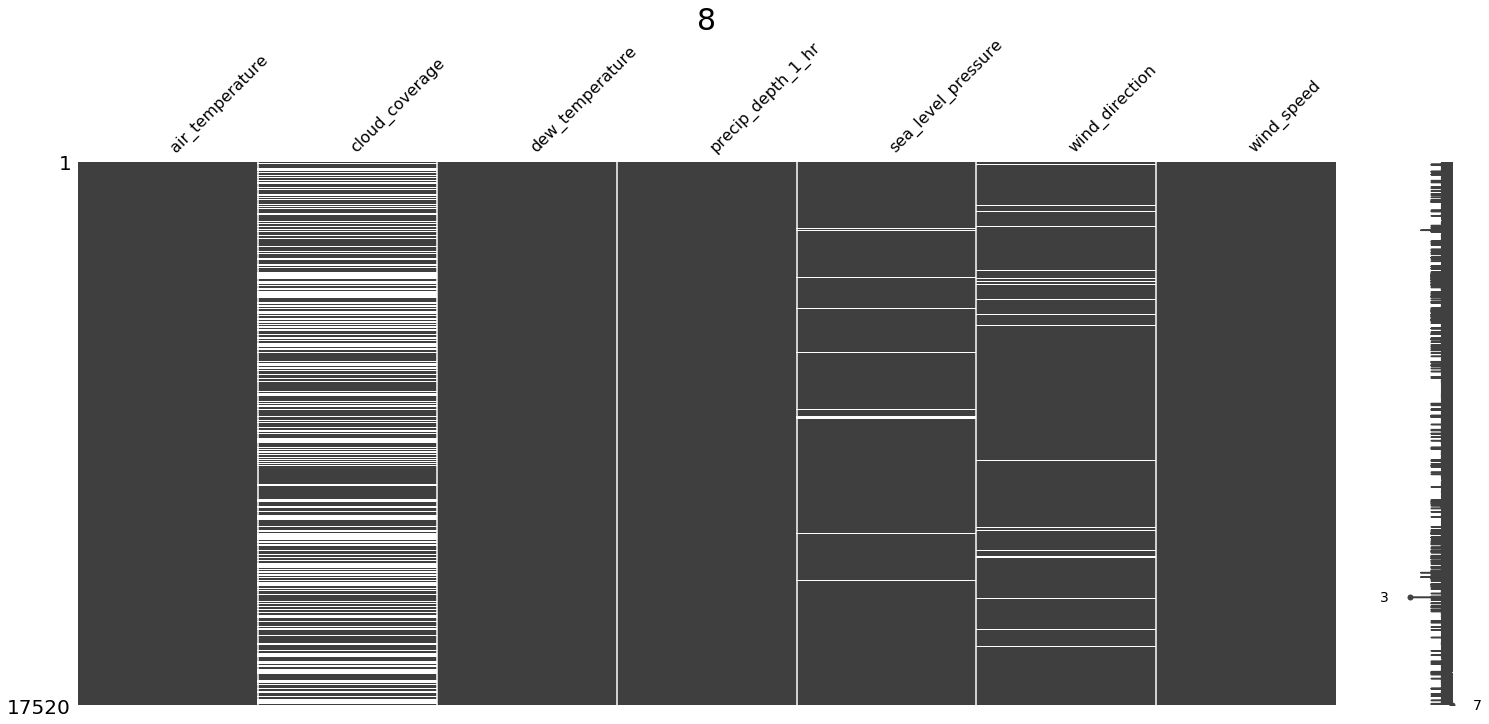

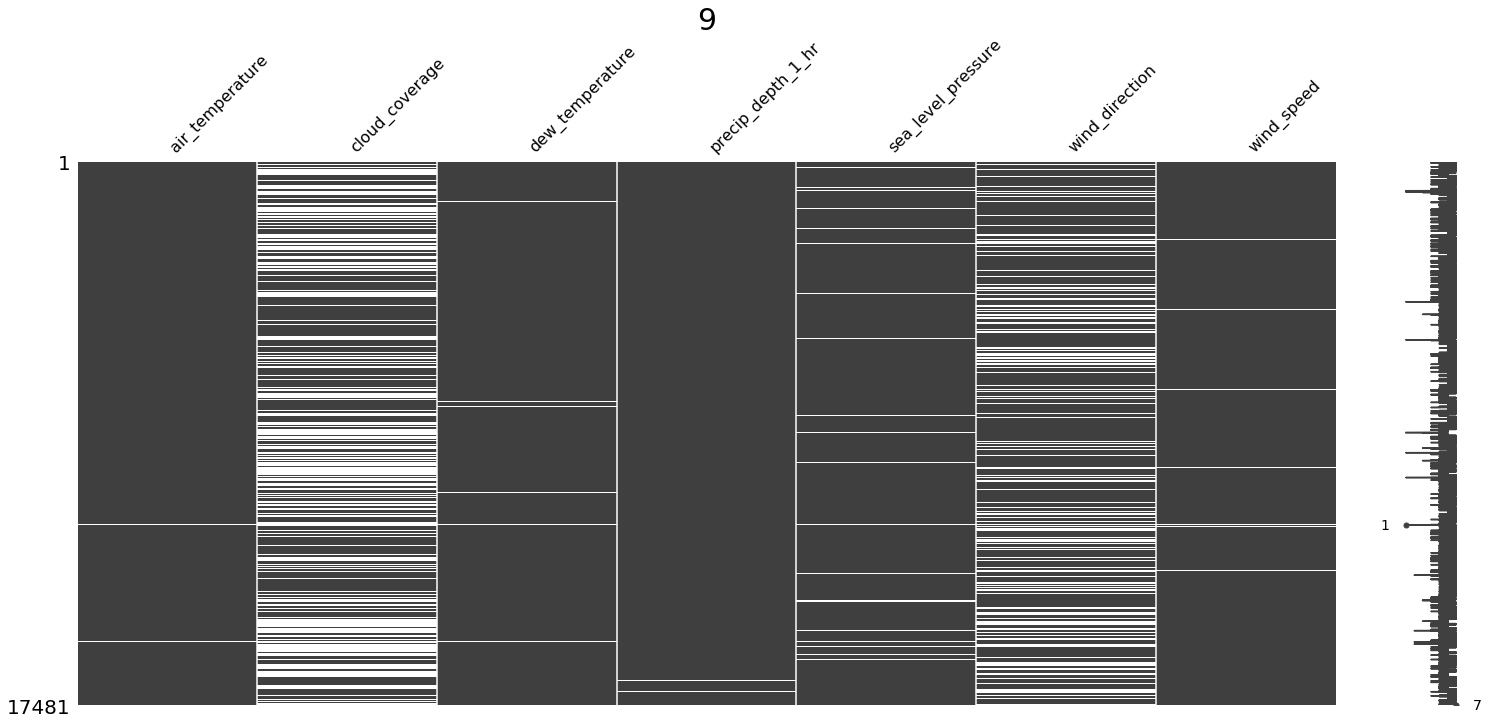

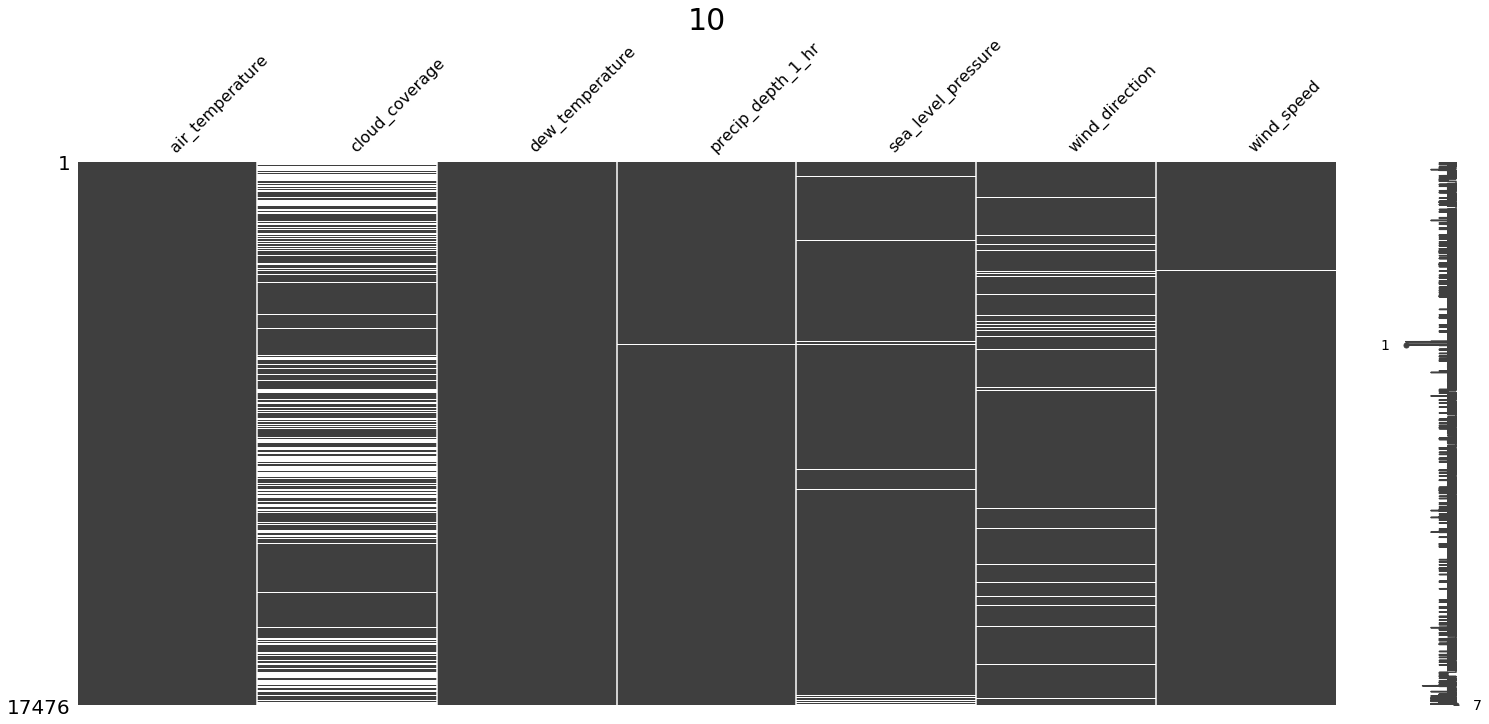

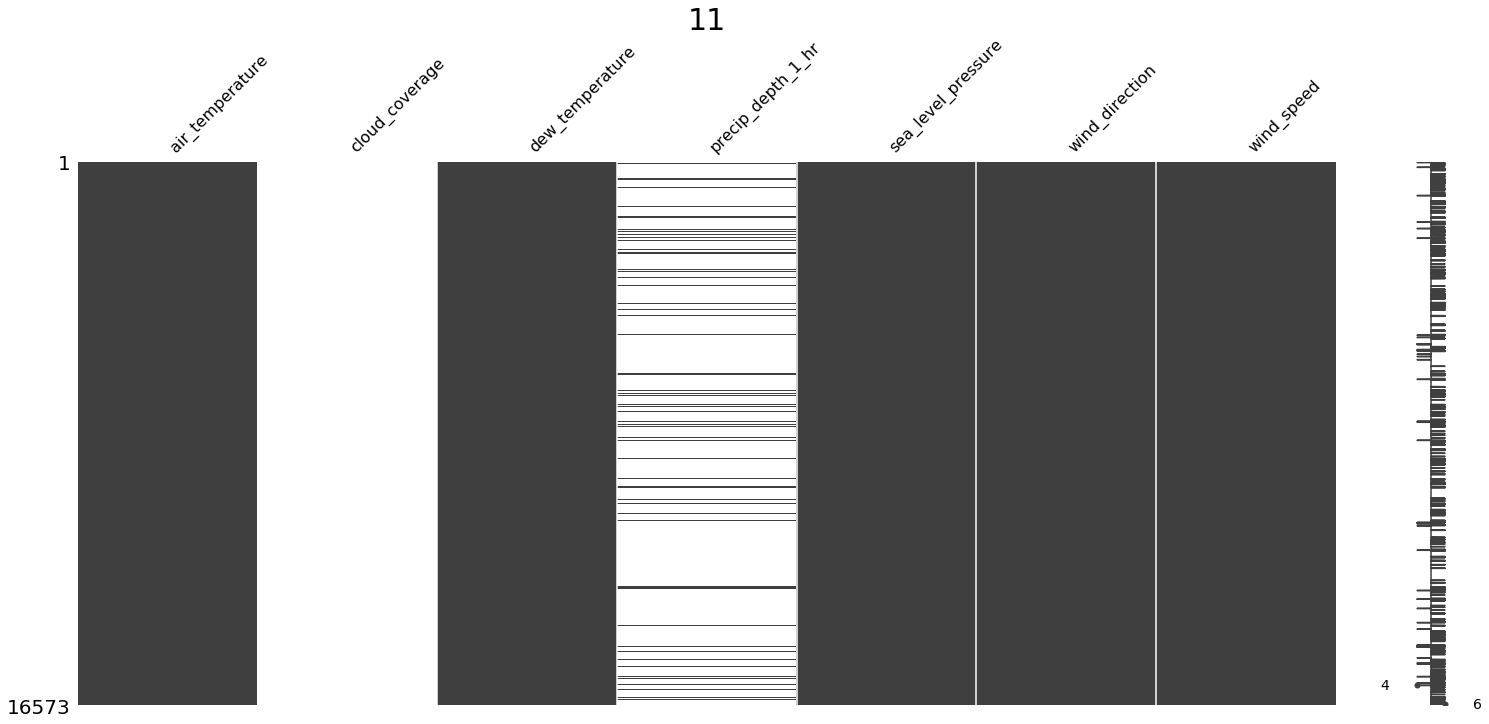

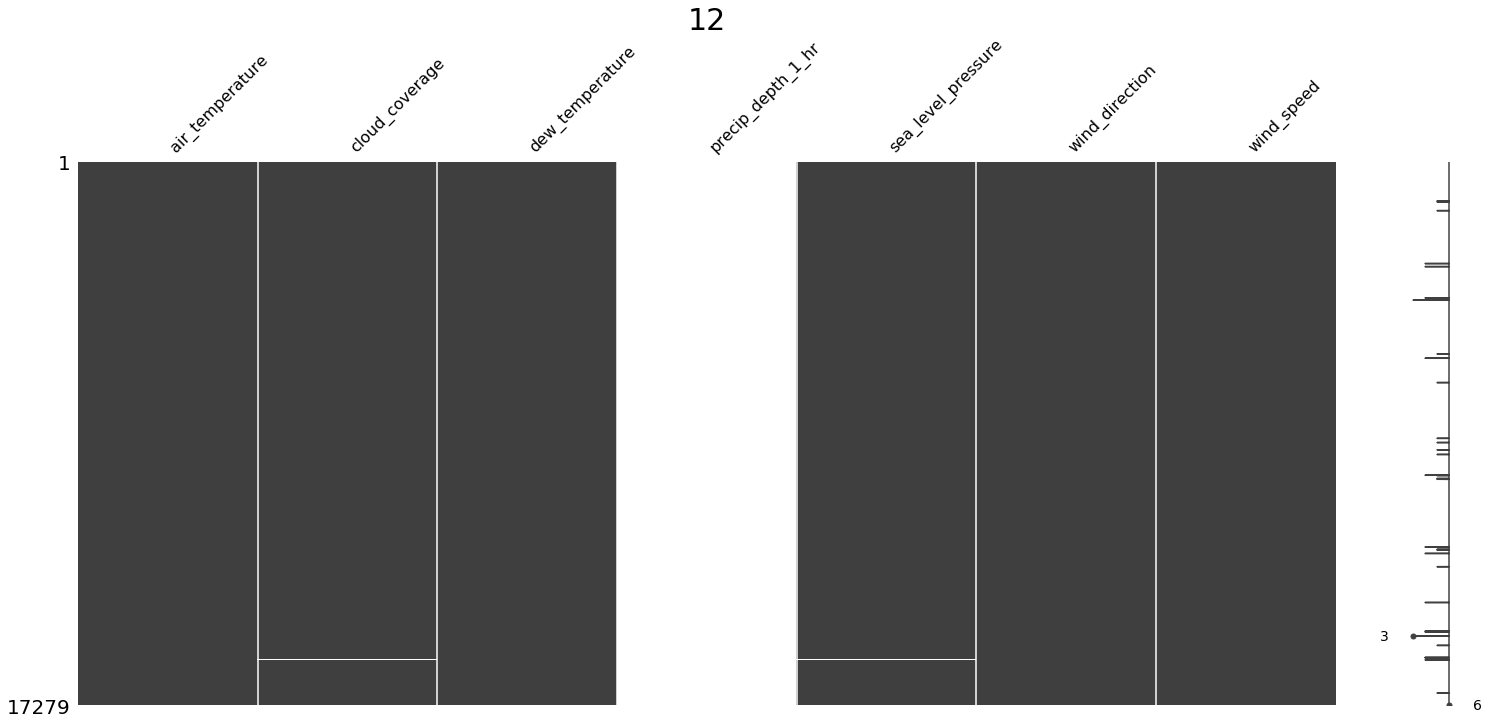

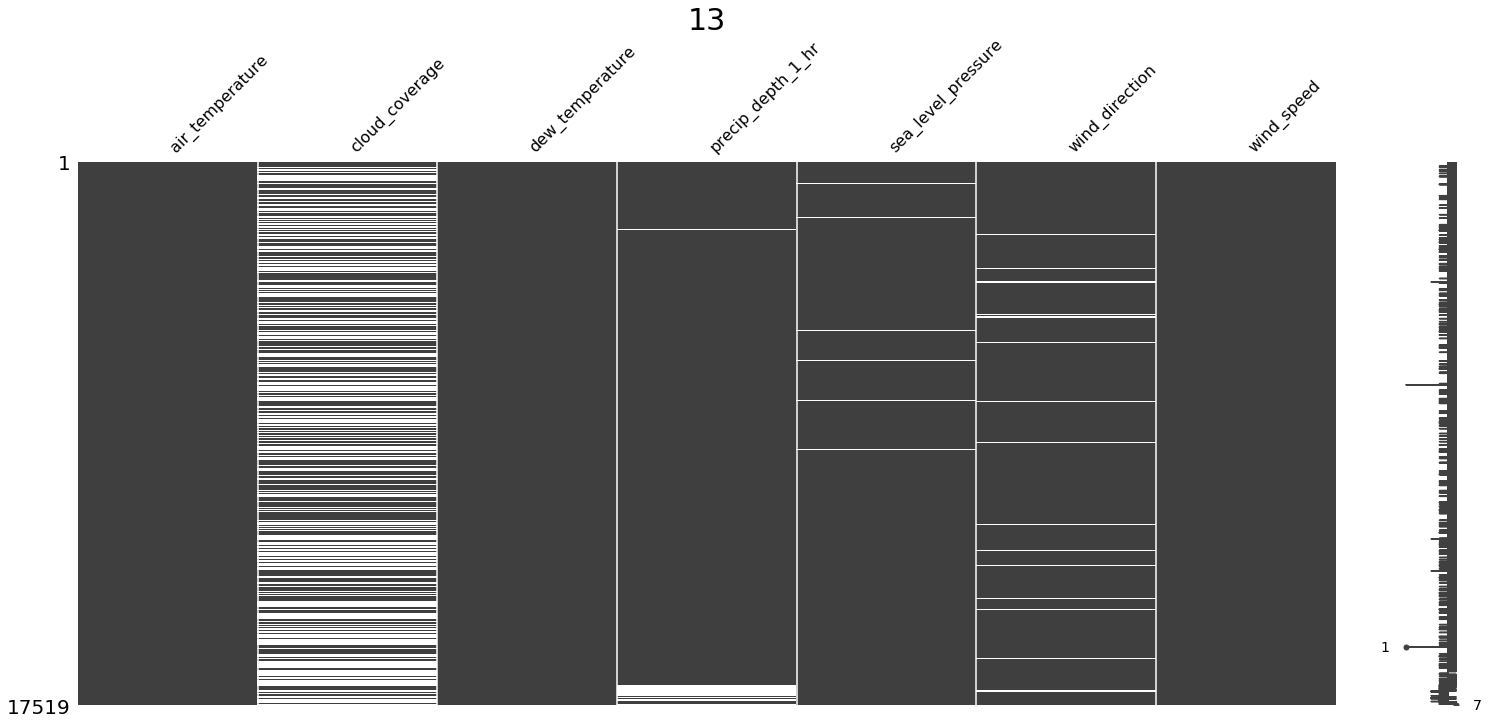

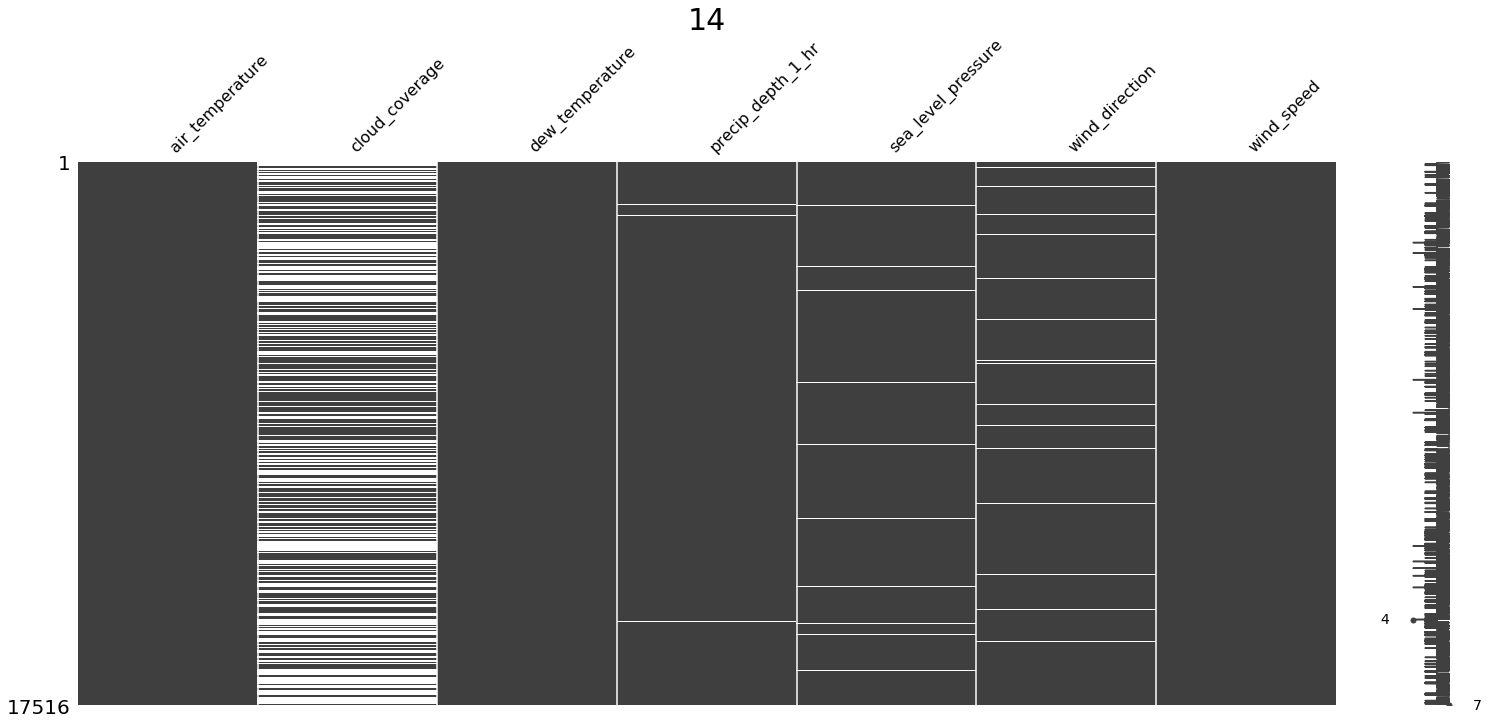

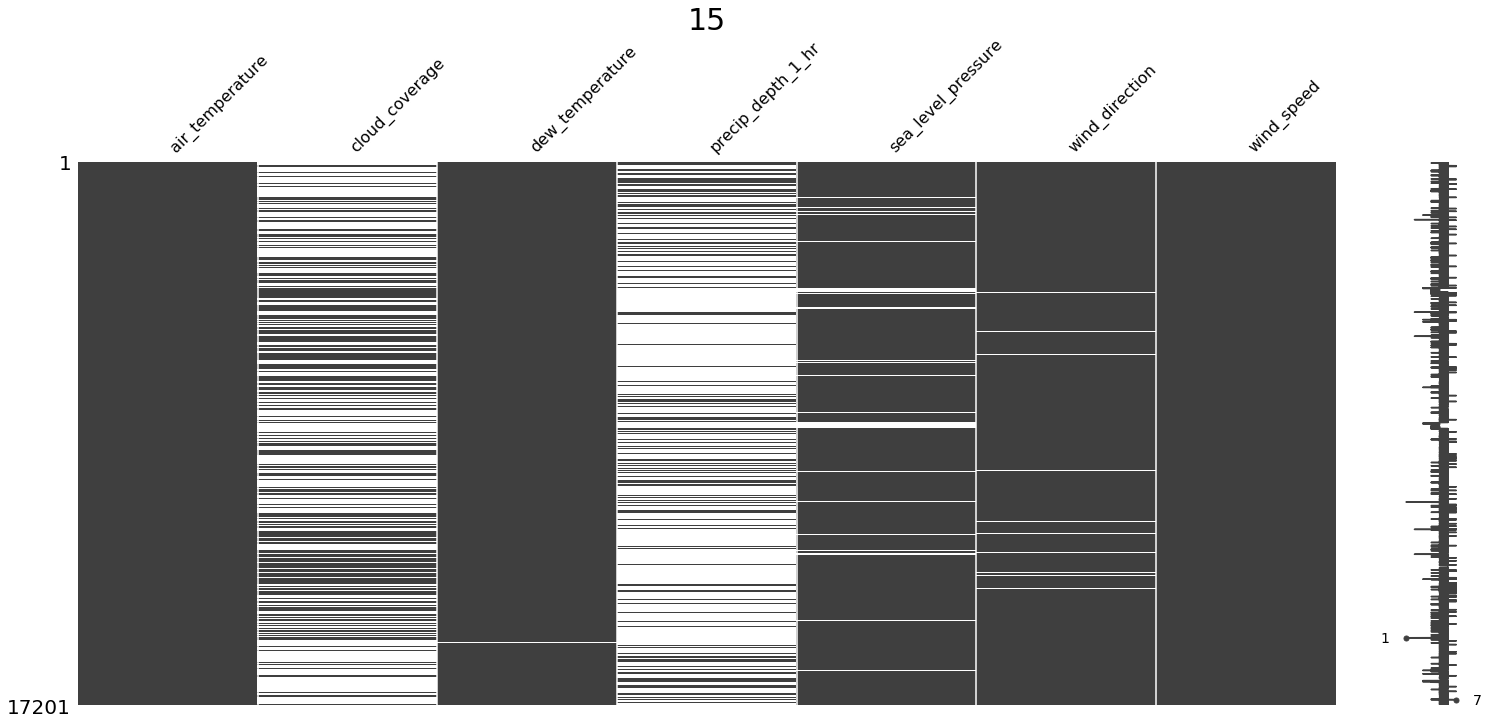

In [29]:
for x in df_weather_test.site_id.unique():
    mn.matrix(df_weather_test[df_weather_test['site_id']==x][df_weather_test.columns[2:]])
    plt.title(x, fontsize=30)
    plt.show()

The distribution of nan values seems relatively similar. This means we can feature engineer and merge all data into a final dataframe without issue. 

## 3. Feature Engineering 

Now that we've explored some of the features individually, let's merge the datasets together into one large dataset that will be used for model prediction. 

Both the training and test datasets have building/time combinations without reported climate data. There are several things which could be done in such a scenario, if the data cannot be retrieved  

- The values could be removed from both the training and the test dataset, which may not be an option in scenarios in which a prediction is required or preferred. 
- If the data points with missing climate data have to go into the model, and removing these rows is not an option, they can be filled with a value that indicates a nan (such as -99), or a 0 value, though both of these will impact model performance 
- Alternatively, these rows can be filled with mean or adjacent climate data.

I have decided to use forward/back fill to replace the missing values.

In [30]:
#for now, will keep month and drop year built and # of floors. 
# first, let's reduce the memory usage of all of our datasets to speed up the process, will do this to the final dataset as well

df=ef.reduce_mem_usage(df, True)
df_build=ef.reduce_mem_usage(df_build, True)
df_weather=ef.reduce_mem_usage(df_weather, True)

df_final=ef.feat_eng(df,df_weather, df_build, log=True, doy=True)

df_final.head()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%
preprocess weather data
merging datasets
extract data from datetime
filling missing data


building_id  meter  meter_reading  site_id primary_use  square_feet  \
0            0      0            0.0        0   Education     8.913685   
1            1      0            0.0        0   Education     7.908755   
2            2      0            0.0        0   Education     8.589886   
3            3      0            0.0        0   Education    10.072639   
4            4      0            0.0        0   Education    11.666573   

   air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
0             25.0             6.0             20.0                0.0   
1             25.0             6.0             20.0                0.0   
2             25.0             6.0             20.0                0.0   
3             25.0             6.0             20.0                0.0   
4             25.0             6.0             20.0                0.0   

   sea_level_pressure  wind_direction  wind_speed  month  weekday  hour  \
0              1019.5             0.0         0.0      1        4     0   
1              1019.5             0.0         0.0      1        4     0   
2              1019.5             0.0         0.0      1        4     0   
3              1019.5             0.0         0.0      1        4     0   
4              1019.5             0.0         0.0      1        4     0   

   dayofyear  
0          1  
1          1  
2          1  
3          1  
4          1

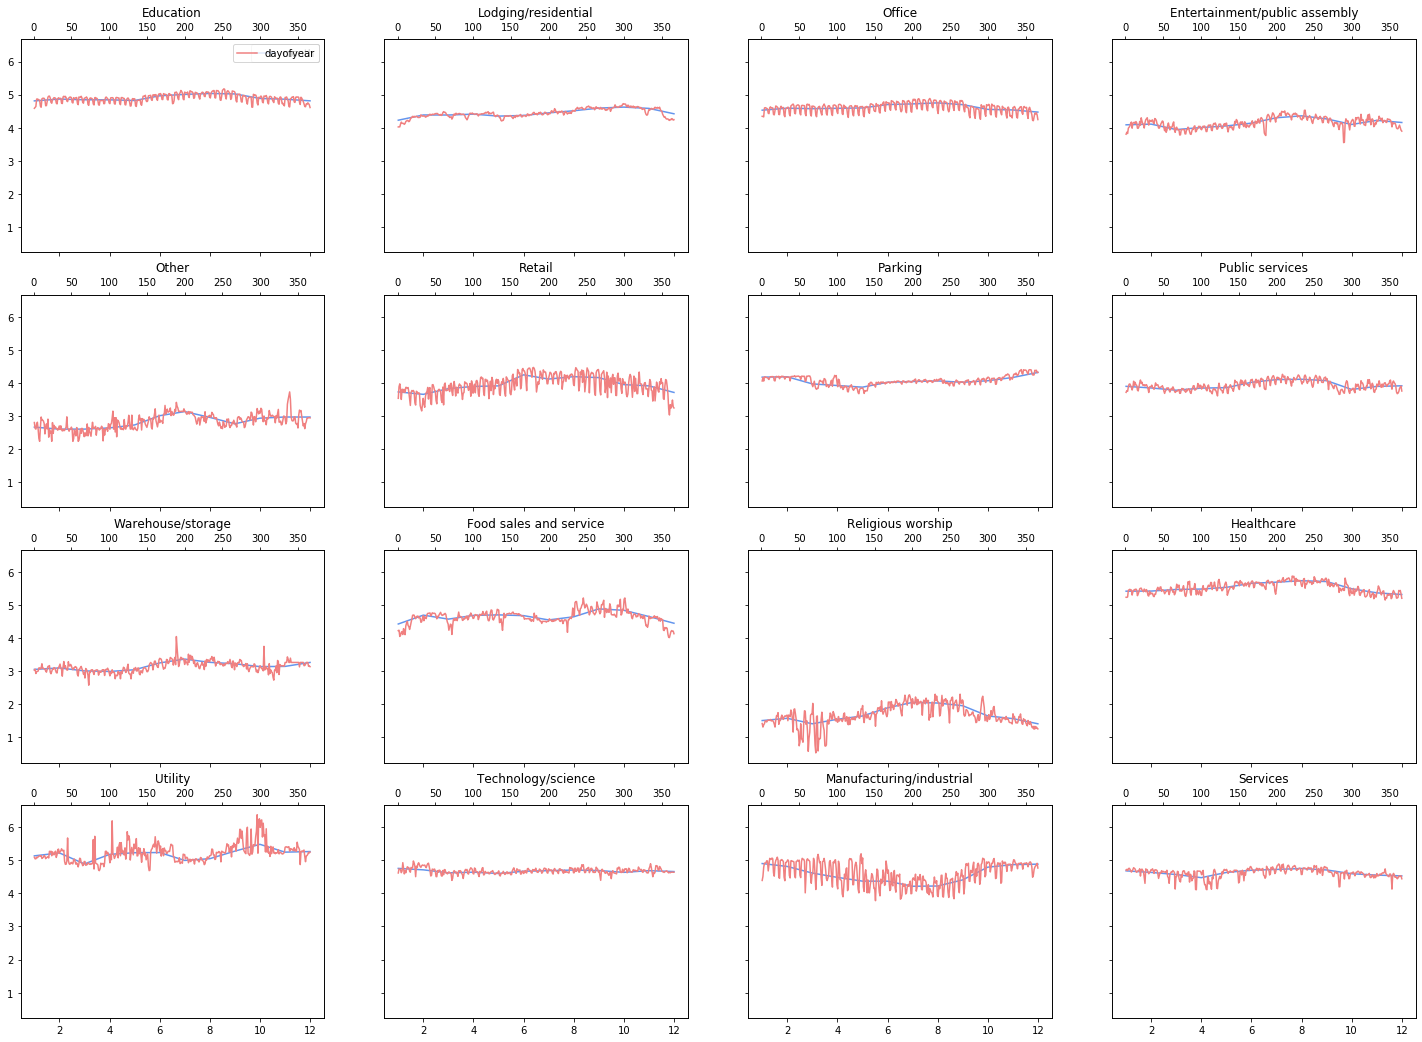

In [31]:
ef.temp_vis(df_final, 'primary_use')

There is no consistent change in energy consumption seen across all types of primary use. However, there seems to be a slight increase in energy consumption over the summer months/mid year in: religious worship, retail, other, public services, entertainment and a slight decrease in manufacturing. 

The highest energy consumption appears to be in utility and healthcare. 

Let's see whether there is any pattern over the year in individual regions. 

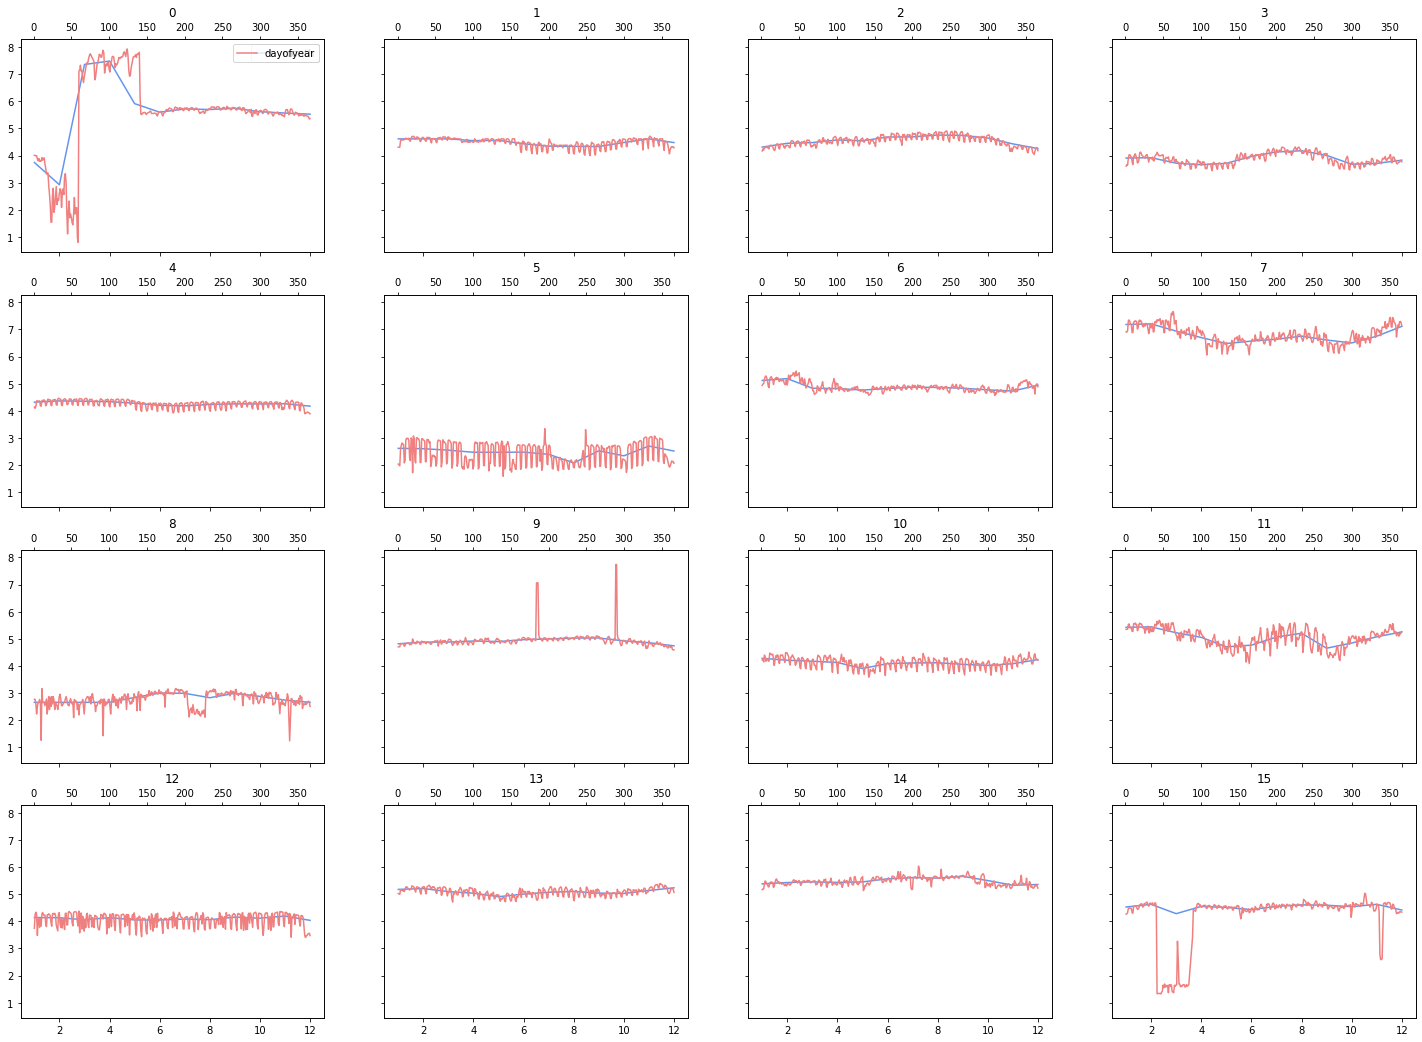

In [32]:
ef.temp_vis(df_final,'site_id')

Although there are slight variations in consumption over time, the most substantial observation is that sites 0, 7, and 11 have the highest overall energy consumption. As per prior analysis, we also know that sites 7 and 11 have some of the lowest mean air_temperature of all the sites. 

These observations suggest that the month may not be that useful of a feature to put into our model. We will, however, still give it a try. 

Now, I'm interested in taking a look at how energy consumption changes by hour and by day of the week. 

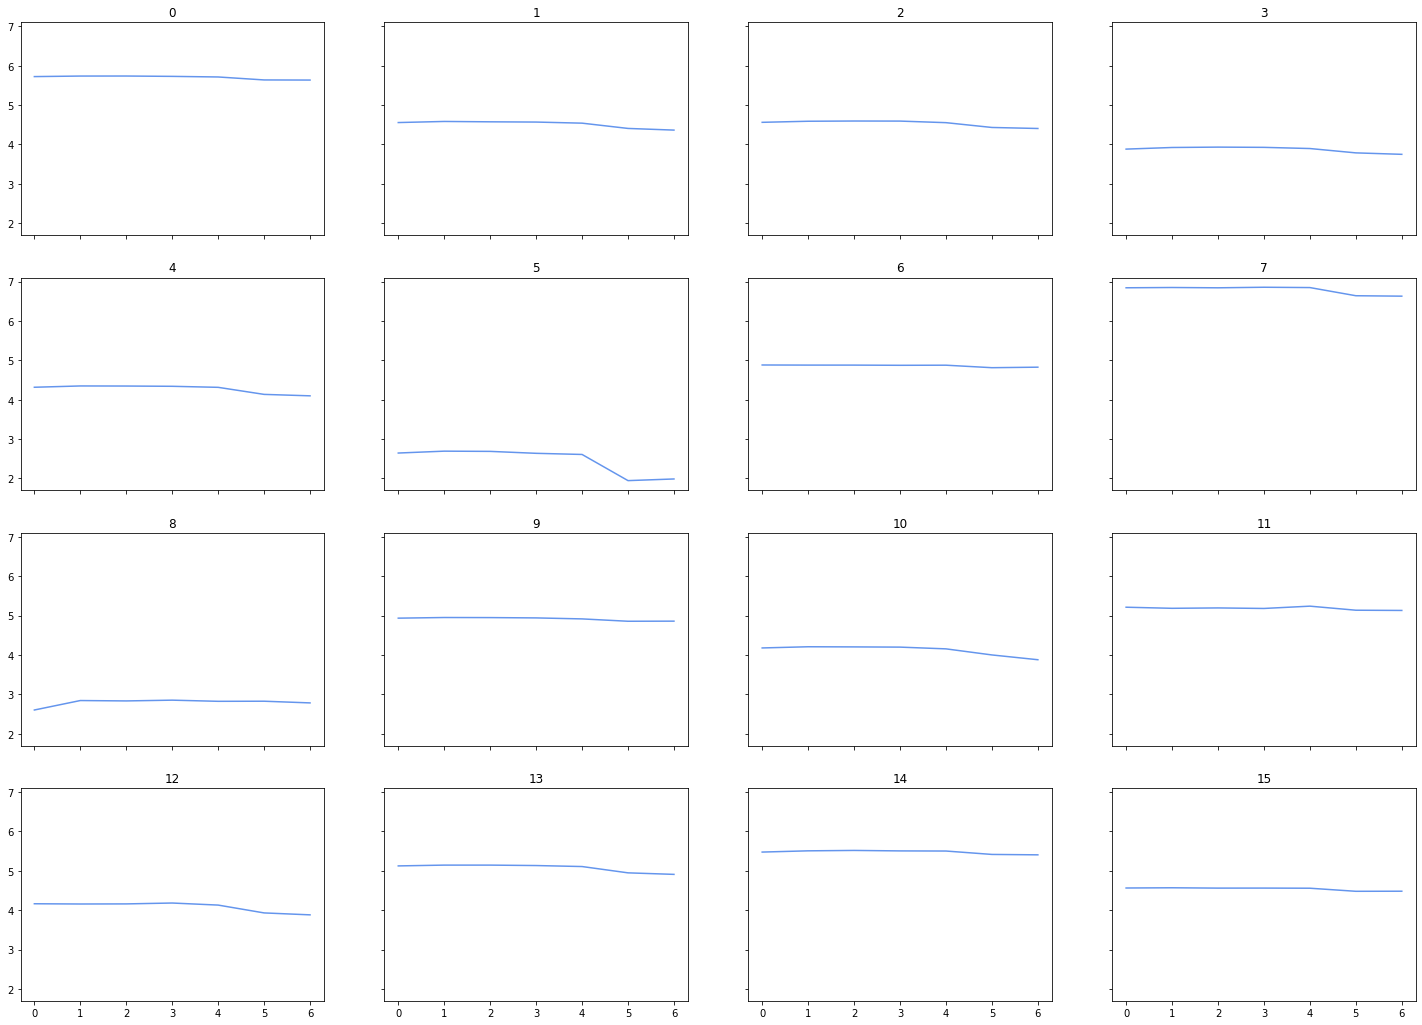

In [33]:
ef.temp_vis(df_final, 'site_id','weekday')

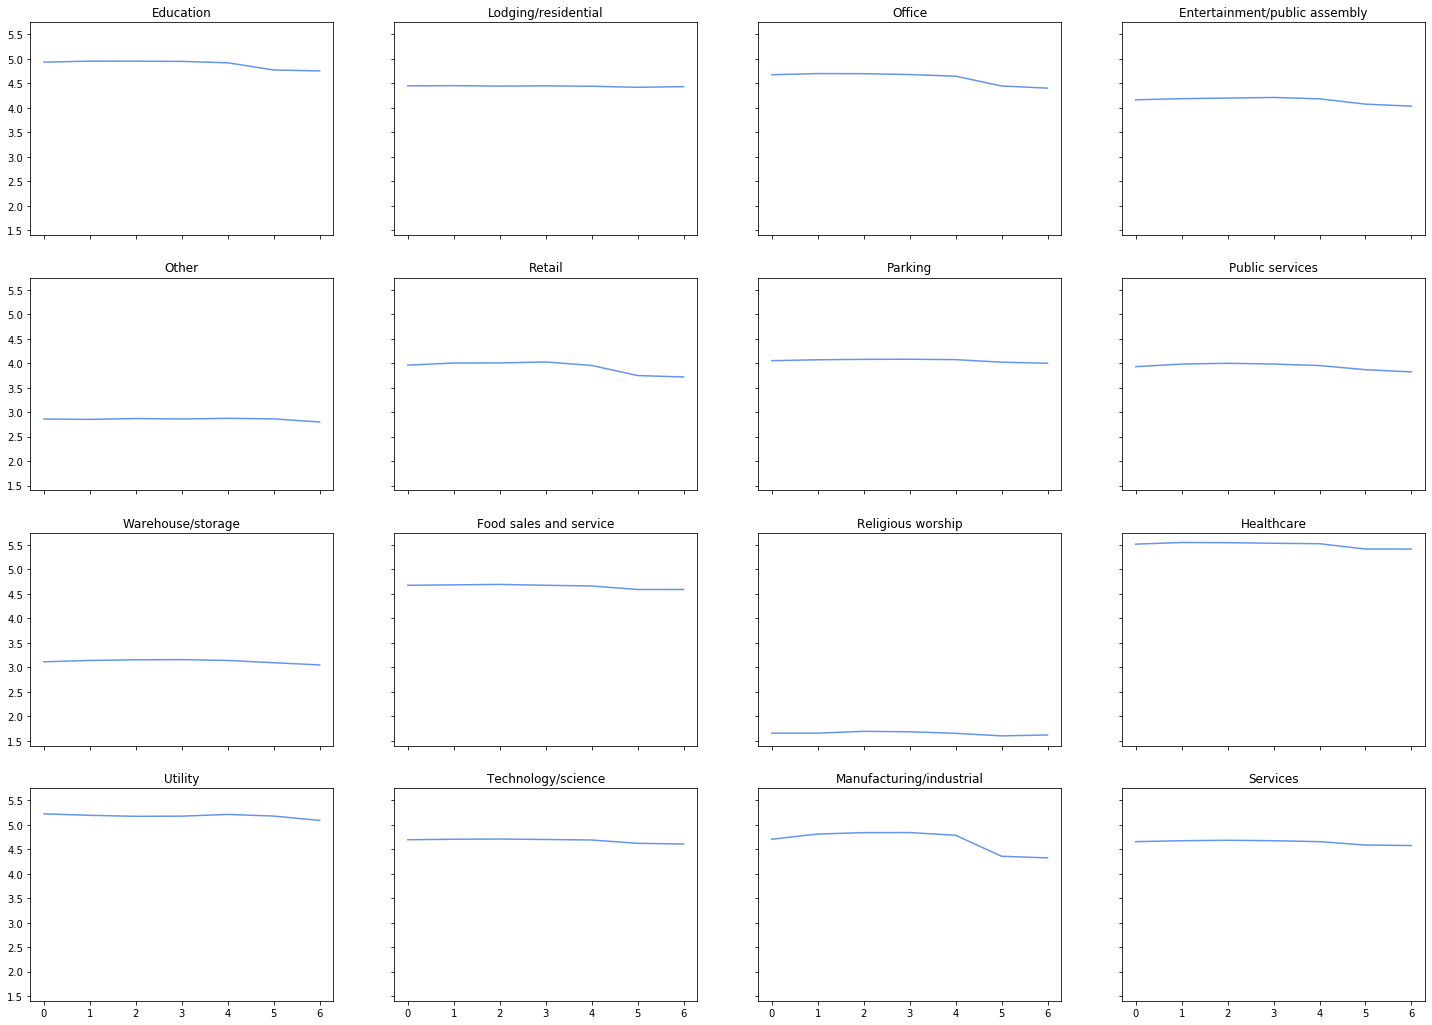

In [34]:
ef.temp_vis(df_final,'primary_use','weekday')

Consumption across the majority of sites and building use-types falls over the weekend. This means we can likely simplify our 'weekday' column into a binary column to indicate whether it is a weekday or weekend without losing too much information. 

In [35]:
#since the column is already named 'weekday', weekend=0, weekday=1

df_final['weekday'][df_final.weekday<5]=1
df_final['weekday'][df_final.weekday>=5]=0

df_final.head()

building_id  meter  meter_reading  site_id primary_use  square_feet  \
0            0      0            0.0        0   Education     8.913685   
1            1      0            0.0        0   Education     7.908755   
2            2      0            0.0        0   Education     8.589886   
3            3      0            0.0        0   Education    10.072639   
4            4      0            0.0        0   Education    11.666573   

   air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
0             25.0             6.0             20.0                0.0   
1             25.0             6.0             20.0                0.0   
2             25.0             6.0             20.0                0.0   
3             25.0             6.0             20.0                0.0   
4             25.0             6.0             20.0                0.0   

   sea_level_pressure  wind_direction  wind_speed  month  weekday  hour  \
0              1019.5             0.0         0.0      1        1     0   
1              1019.5             0.0         0.0      1        1     0   
2              1019.5             0.0         0.0      1        1     0   
3              1019.5             0.0         0.0      1        1     0   
4              1019.5             0.0         0.0      1        1     0   

   dayofyear  
0          1  
1          1  
2          1  
3          1  
4          1

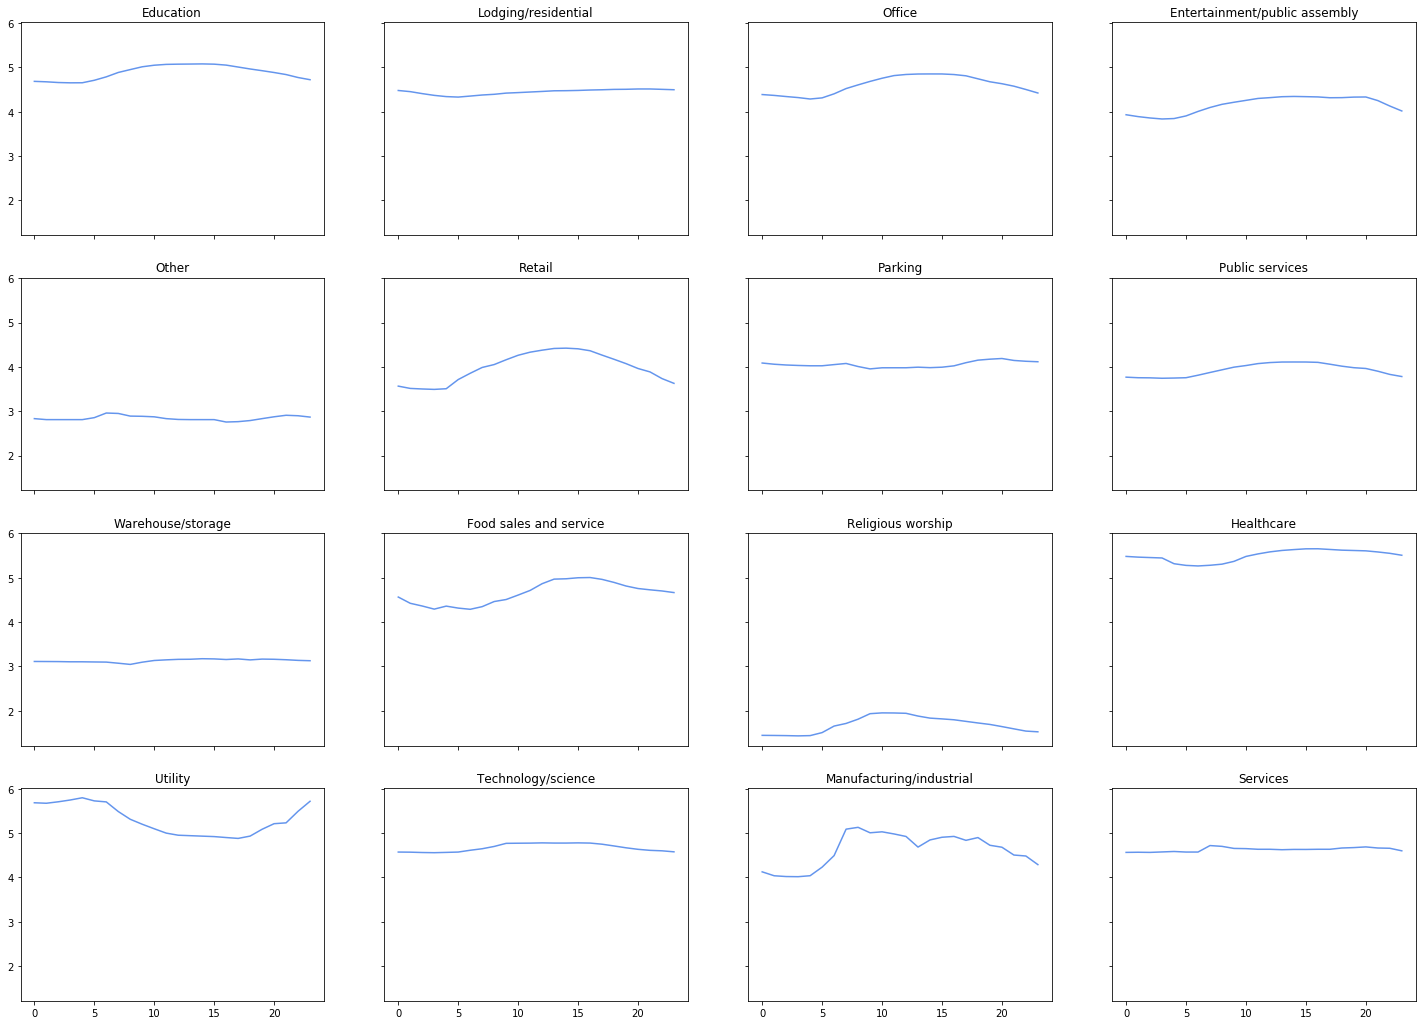

In [36]:
#now let's look at the hour, first based divided by primary use

ef.temp_vis(df_final,'primary_use','hour')

The majority of building use-types see a spike in energy consumption during regular working hours, the major exception being utility.
Let's see if the results are any different if we separate by site_id

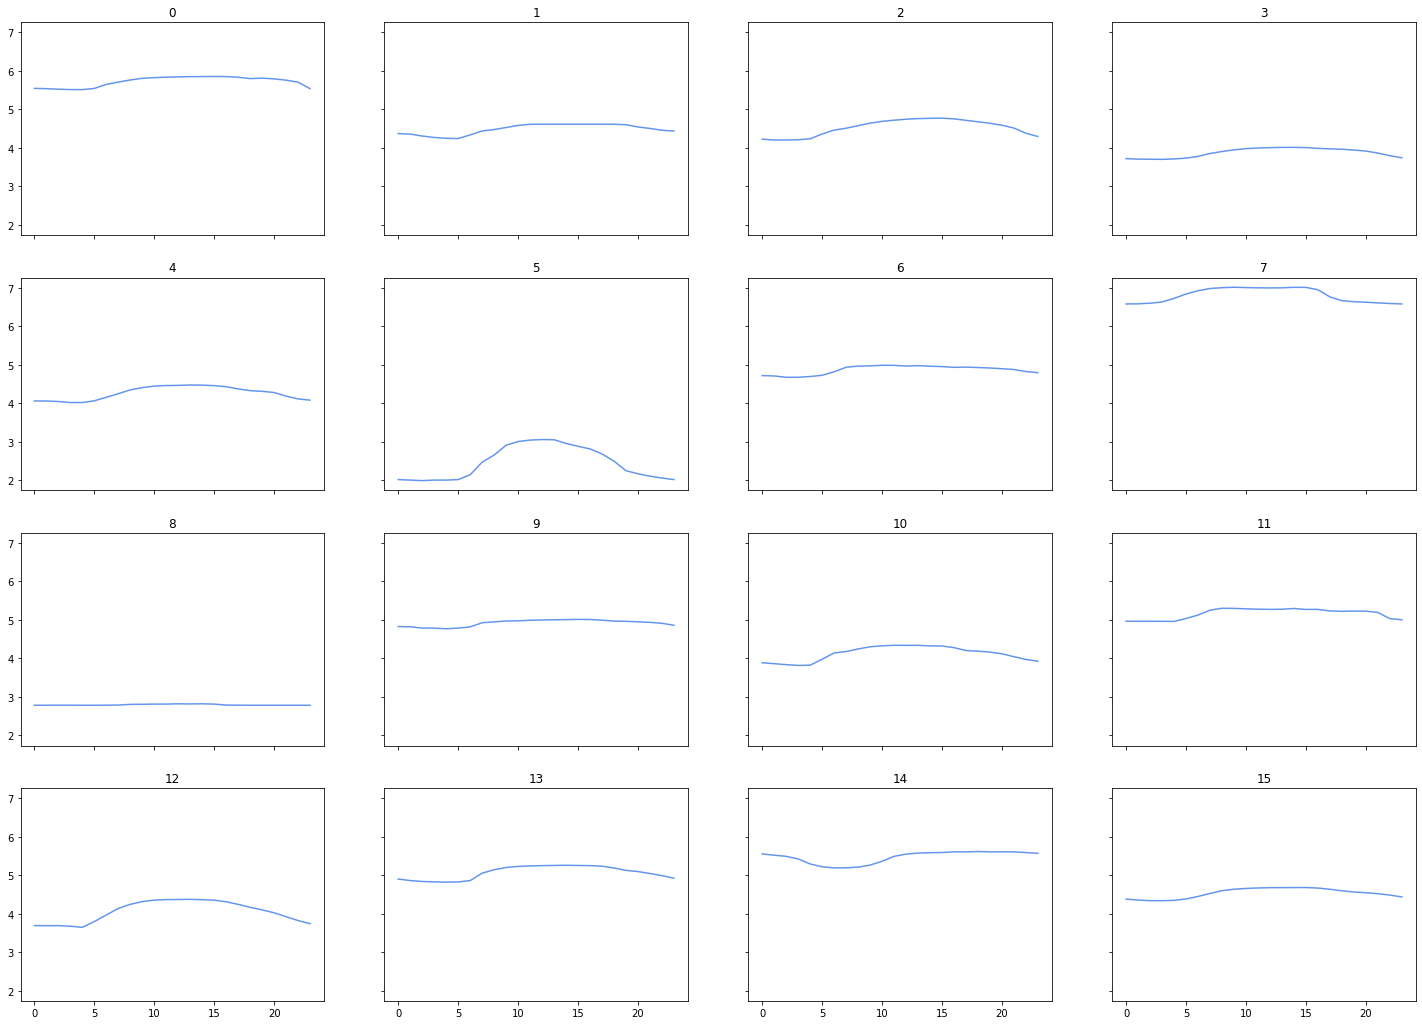

In [37]:
ef.temp_vis(df_final,'site_id','hour')

More or less the same results. 

Now that we've done a bit more exploration, let's look at our final features with which we will start modelling. 

## 5. Modelling 

We will use an LGBM for prediction. LGBM is efficient at handling large datasets and can handle a large number of categorical features without the need to create dummy variables. This is particularly important as all 1500 buildings should be treated as categorical variables. 

Before running the model, we need to address the outliers we identified during our EDA, specifically the water-based meter readings in building 1099 and the 0 electricity meter readings in the first ~150 buildings. 

There is no guarantee that removing these values will minimize loss, particularly if the test data have similar errors in them. However, removing these values is likely to move the predictions closer to the actual energy consumption in these buildings. 

In [38]:
df_final=df_final[(df_final.site_id!=1099)&(df_final.meter!=2)]
#using the array of saved building_ids to address, we can eliminate the approximate time range over which there are errors
df_final=df_final[((df_final.building_id.isin(zero_build))&(df_final.dayofyear<150))==False]
df_final.head()


building_id  meter  meter_reading  site_id          primary_use  \
94            96      0       0.000000        0  Lodging/residential   
103          105      0       3.190624        1            Education   
106          107      0       5.171529        1            Education   
107          108      0       4.524668        1            Education   
110          110      0       4.468529        1            Education   

     square_feet  air_temperature  cloud_coverage  dew_temperature  \
94     12.210732        25.000000             6.0        20.000000   
103    10.832181         3.800781             0.0         2.400391   
106    11.487946         3.800781             0.0         2.400391   
107    11.309352         3.800781             0.0         2.400391   
110    10.233331         3.800781             0.0         2.400391   

     precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  month  \
94                 0.0              1019.5             0.0    0.000000      1   
103                0.0              1021.0           240.0    3.099609      1   
106                0.0              1021.0           240.0    3.099609      1   
107                0.0              1021.0           240.0    3.099609      1   
110                0.0              1021.0           240.0    3.099609      1   

     weekday  hour  dayofyear  
94         1     0          1  
103        1     0          1  
106        1     0          1  
107        1     0          1  
110        1     0          1

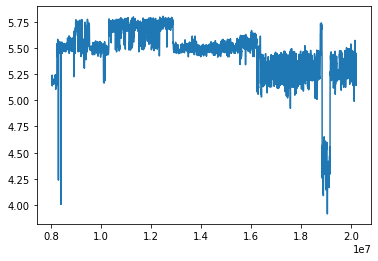

In [39]:
#let's plot one of the the buildings with the issues. 
plt.plot(df_final[df_final.building_id==0]['meter_reading'])

In [40]:
#now that we've eliminated these, we can drop day of year column and start modelling. 
df_final=df_final.drop('dayofyear',axis=1)

#reducem memory for training once more 
df_final=ef.reduce_mem_usage(df_final, True)
df_final.head()

Memory usage of dataframe is 1704.29 MB
Memory usage after optimization is: 551.87 MB
Decreased by 67.6%


building_id  meter  meter_reading  site_id          primary_use  \
94            96      0       0.000000        0  Lodging/residential   
103          105      0       3.191406        1            Education   
106          107      0       5.171875        1            Education   
107          108      0       4.523438        1            Education   
110          110      0       4.468750        1            Education   

     square_feet  air_temperature  cloud_coverage  dew_temperature  \
94     12.210938        25.000000             6.0        20.000000   
103    10.835938         3.800781             0.0         2.400391   
106    11.484375         3.800781             0.0         2.400391   
107    11.312500         3.800781             0.0         2.400391   
110    10.234375         3.800781             0.0         2.400391   

     precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  month  \
94                 0.0              1019.5             0.0    0.000000      1   
103                0.0              1021.0           240.0    3.099609      1   
106                0.0              1021.0           240.0    3.099609      1   
107                0.0              1021.0           240.0    3.099609      1   
110                0.0              1021.0           240.0    3.099609      1   

     weekday  hour  
94         1     0  
103        1     0  
106        1     0  
107        1     0  
110        1     0

We have 15 features with which we can model. 

Now we can load lgbm and start. 

Because we are working with a very large dataset, we have to think a little about how we want to set up the training. 

There are close to 20 million data points which likely have a lot of variability. We don't want to over or underfit the model, so we'll work with 1000 iterations to start. This will ensure that the model doesn't overfit to very specific data, but provides enough iterations to capture the complexity that may be found in such a large dataset. This, of course, is subject to tuning after the first round of training/testing. 

(The documentation for the lgbm model build is located in the energy_funct.py file). 

In [41]:
results=ef.pred(df_final, valid=False, cat=["building_id", "site_id", "meter", "primary_use","weekday"])

new loop
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.05976	valid_1's rmse: 1.06086
[100]	training's rmse: 0.911277	valid_1's rmse: 0.912628
[150]	training's rmse: 0.852537	valid_1's rmse: 0.854251
[200]	training's rmse: 0.821966	valid_1's rmse: 0.823863
[250]	training's rmse: 0.797063	valid_1's rmse: 0.799152
[300]	training's rmse: 0.778797	valid_1's rmse: 0.780997
[350]	training's rmse: 0.762674	valid_1's rmse: 0.764924
[400]	training's rmse: 0.753227	valid_1's rmse: 0.755602
[450]	training's rmse: 0.743701	valid_1's rmse: 0.746139
[500]	training's rmse: 0.736541	valid_1's rmse: 0.739143
[550]	training's rmse: 0.729773	valid_1's rmse: 0.732506
[600]	training's rmse: 0.723213	valid_1's rmse: 0.72612
[650]	training's rmse: 0.716108	valid_1's rmse: 0.719179
[700]	training's rmse: 0.710897	valid_1's rmse: 0.714125
[750]	training's rmse: 0.704713	valid_1's rmse: 0.70809
[800]	training's rmse: 0.700187	valid_1's rmse: 0.703746
[850]	training's rmse:

## Results and Next Steps

Having access only to data that spans 2016, our model doesn't seem to overfit too much. Let's look at feature importance in each fold. 

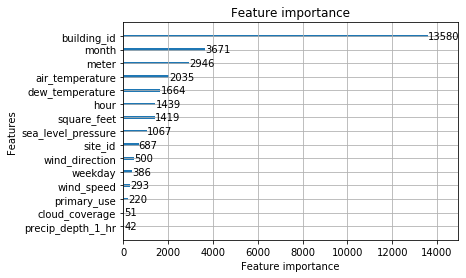

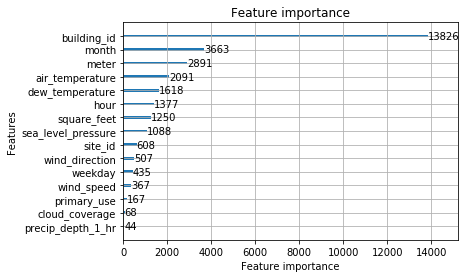

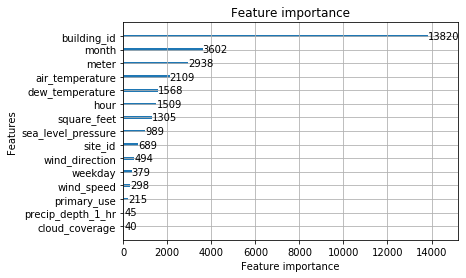

In [42]:
import lightgbm as lgb

#let's look at feature importance
for x in range(len(results)):
    lgb.plot_importance(results[0][x])

Consistently, the most important features are: building_id, month, meter, air_temperature, dew_temperature, hour, and square feet. 

Now that we have completed the initial run, the next step would be to tune the parameters and determine if any features should be removed or modified. Because the test data span 2017-2018 while the training data span 2016 it is important to compare performance of the model with the test data to avoid overfitting for 2016 conditions. 

The next steps of model tuning/feature adjustment would be to evaluate the performance while doing the following: 
1. removing the 'month' feature 
2. adding the outliers (building no. 1099, etc.) back into the dataset
3. adjusting number of folds 
4. adjusting number of iterations/early stopping rounds 
5. adjusting the way missing values are filled (daily averages instead of forward/back propagation) 
6. conduct a grid search to tune hyperparameters 
7. remove features with low importance, such as cloud coverage and precipitation depth. 

With each of these steps it would be important to test the performance not only on the training data, but on the test data to ensure the most robust model is built.